# Init

In [1]:
import os
# import subprocess
import numpy as np
import pandas as pd
np.random.seed(42)
pd.set_option('future.no_silent_downcasting', True)

import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

import scipy.stats as st

from gseapy import Biomart

import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib_venn import venn2
# from upsetplot import UpSet

In [2]:
ROOT_DIR = '/tank/projects/omics2022/efimov/scripts/soma_mut/'
datasets_dir = f'{ROOT_DIR}/datasets/'
processed_dir = f'{ROOT_DIR}/datasets_processed/'
essentialomes_dir = f'{ROOT_DIR}/essentialomes/'
results_dir = f'{ROOT_DIR}/results/'

favor_dir = f'{processed_dir}/favor'
vep_dir = f'{processed_dir}/vep'
ann_dir = f'{processed_dir}/ann'
deless_dir = f'{processed_dir}/deless'

COLS_MAIN = ['CHROM', 'POS', 'REF', 'ALT']
cols_short = COLS_MAIN + ['SAMPLE_ID', 'DATASET_ID']
cols_classified = COLS_MAIN + ['CLASS']

tissues = ['Brain', 'Heart', 'Liver', 'Lung']
tissues_full = ['Brain', 'Heart', 'Liver', 'Liver_LSC', 'Lung']

classes = ['CDS', 'SPLICE', 'NCREG', 'NCRNA', 'NCOTH']

In [3]:
feat_col = 'Feature'
conseq_col = 'Consequence'
conseq_num_col = f'{conseq_col}_num'
gene_symbol_col = 'SYMBOL'
combined_score_col = 'COMBINED_SCORE'
del_col = 'DELETERIOUS'
del_trans_col = 'DELETERIOUS_TRANSFORMED'
ess_col = 'ESSENTIAL_RELATED'
deless_col = 'DELETERIOUS|ESSENTIAL_RELATED'

In [4]:
outliers = {
    'Brain': ['4638-Neuron-4'],
    'Heart': ['1039_A1', '1039_A5', '5828_E6'],
    'Liver': [],
    'Lung': ['N1274_2', 'N1274_8A', 'N1276_4', 'N1407_2', 'N1410_1', 'N1410_6', 'N1415_3']
    }

# Brain

## Motyer et al., 2025

In [4]:
meta_motyer = pd.read_csv(f'{datasets_dir}/2025motyer/data/MS_sSNV_burden_data.csv')
meta_motyer

,Sample,Individual,WGA,Disease,Tissue,Cell,Region,Age,Sex,PMI,...,ncalls,callable.sens,callable.bp,callable.burden,rate.per.gb,burden,somatic.sens,pre.genotyping.burden,total.ncalls,eff.sens
0,CT4_FC_Neu2,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,Female,30.0,...,232,0.393965,1286694521,588.885496,228.836560,1337.549953,0.173451,1046,383,0.286344
1,CT4_FC_Neu5,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,Female,30.0,...,193,0.379551,1272848345,508.496220,199.747371,1167.523608,0.165307,1184,399,0.341749
2,CT4_FC_Neu6,CT4,PTA,CTL,CTL,Neuron,Frontal cortex,59.0,Female,30.0,...,174,0.368876,1293864559,471.703583,182.284761,1065.454633,0.163311,1110,371,0.348208
3,CT6_FC_Neu10,CT6,PTA,CTL,CTL,Neuron,Frontal cortex,79.0,Female,19.0,...,256,0.367261,1311221324,697.051388,265.802338,1553.614969,0.164777,1468,489,0.314750
4,CT6_FC_Neu3,CT6,PTA,CTL,CTL,Neuron,Frontal cortex,79.0,Female,19.0,...,271,0.418973,1307849973,646.819148,247.283389,1445.371692,0.187495,1269,514,0.355618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,MS11_N_Neu4,MS11,PTA,MS,MS normal,Neuron,MS,73.0,Male,24.0,...,331,0.407682,1302870484,811.907191,311.583999,1821.208826,0.181747,1481,580,0.318470
69,MS12_N_Neu3,MS12,PTA,MS,MS normal,Neuron,MS,42.0,Female,11.0,...,172,0.377544,1300206167,455.575572,175.193590,1024.006731,0.167968,1147,342,0.333982
70,MS12_N_Neu4,MS12,PTA,MS,MS normal,Neuron,MS,42.0,Female,11.0,...,201,0.395837,1293128160,507.784502,196.339589,1147.605119,0.175147,1111,394,0.343324
71,MS12_N_Neu5,MS12,PTA,MS,MS normal,Neuron,MS,42.0,Female,11.0,...,189,0.400726,1296350641,471.644318,181.912325,1063.277745,0.177752,1085,377,0.354564


In [46]:
motyer_data_dir = f'{datasets_dir}/2025motyer/data/vcf'

data_motyer = pd.concat(
    [pd.read_csv(f'{motyer_data_dir}/{f}', skiprows=92, sep='\t').assign(SAMPLE_ID=f.rstrip('.vcf')) for f in os.listdir(motyer_data_dir)]
).rename(columns={'#CHROM':'CHROM'}).reset_index(drop=True).assign(DATASET_ID='MOTYER')
data_motyer.to_csv(f'{processed_dir}/2025motyer/2025motyer_hg19_raw.tsv.gz', sep='\t', compression='gzip', index=None)

data_motyer = data_motyer[cols_short]
data_motyer = data_motyer[data_motyer['SAMPLE_ID'].str.startswith('CT')].sort_values(['CHROM', 'POS']).reset_index(drop=True)

data_motyer.to_csv(f'{processed_dir}/2025motyer/2025motyer_hg19.tsv.gz', sep='\t', compression='gzip', index=None)
data_motyer.to_csv(f'{processed_dir}/2025motyer/2025motyer_hg19_headless.tsv.gz', sep='\t', compression='gzip', index=None, header=None)
data_motyer

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,2829442,T,C,CT5_FC_Neu10.scan2,MOTYER
1,1,3003315,C,T,CT5_FC_Neu9.scan2,MOTYER
2,1,3122511,G,A,CT5_FC_Neu9.scan2,MOTYER
3,1,4440087,C,T,CT5_FC_Neu9.scan2,MOTYER
4,1,4700891,G,A,CT5_FC_Neu9.scan2,MOTYER
...,...,...,...,...,...,...
5776,22,48856171,C,T,CT2_PL_Neu2.scan2,MOTYER
5777,22,49266957,G,C,CT2_PL_Neu3.scan2,MOTYER
5778,22,49767099,C,T,CT2_PL_Neu3.scan2,MOTYER
5779,22,49978244,A,G,CT5_FC_Neu9.scan2,MOTYER


## Luquette et al., 2022

In [105]:
meta_luquette = pd.read_csv(f'{datasets_dir}/2022luquette/metadata.csv')
meta_luquette = meta_luquette[(meta_luquette['amp'] == 'PTA') & (~meta_luquette['sample'].isin(outliers['Brain']))].reset_index(drop=True)
meta_luquette.to_csv(f'{datasets_dir}/2022luquette/metadata_clean.csv')
meta_luquette

,sample,donor,amp,type,age,color,plotage,outlier,gtype,sex,mapd,imbal
0,1278BA9-A,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.187941,0.171492
1,1278BA9-B,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186950,0.172220
2,1278BA9-C,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186063,0.179704
3,5817PFC-A,5817,PTA,PFC neuron,0.6,#c0c0c0,0.5,False,NaN,M,0.231573,0.252280
4,5817PFC-B,5817,PTA,PFC neuron,0.6,#c0c0c0,0.5,False,NaN,M,0.226378,0.268801
5,5817PFC-C,5817,PTA,PFC neuron,0.6,#c0c0c0,0.5,False,NaN,M,0.214240,0.236615
6,5871-Neuron-4,5871,PTA,PFC neuron,2.0,#006400,2.0,False,NaN,M,0.215041,0.286696
7,5871-Neuron-5,5871,PTA,PFC neuron,2.0,#006400,2.0,False,NaN,M,0.195988,0.196123
8,5871-Neuron-6,5871,PTA,PFC neuron,2.0,#006400,2.0,False,NaN,M,0.198563,0.198142
9,4638-Neuron-5,4638,PTA,PFC neuron,15.1,#191970,15.1,False,NaN,F,0.189251,0.189586


In [106]:
data_luquette = pd.read_csv(f'{datasets_dir}/2022luquette/data/Collected_SCANSNV_SCAN2_sSNV_calls.csv.gz')
data_luquette_indel = pd.read_csv(f'{datasets_dir}/2022luquette/data/Collected_SCAN2_sIndel_calls.csv.gz', index_col=0)

data_luquette = data_luquette[data_luquette['sample'].isin(meta_luquette['sample'])].sort_values(['chr', 'pos']).reset_index(drop=True)
data_luquette_indel = data_luquette_indel[data_luquette_indel['sample'].isin(meta_luquette['sample'])].sort_values(['chr', 'pos']).reset_index(drop=True)

data_luquette

,sample,chr,pos,refnt,altnt,dbsnp,muttype,dp,af,bulk.dp,...,ctx.rc,type.and.ctx,donor,id,rec.filter,nearest,clustered.filt.50,lineage.filter,final.filter,status
0,5657PFC-B,1,853262,C,G,.,C>G,13,0.769231,43,...,GGC,GCC:C>G,5657,1 853262 C G,False,14672670.0,False,False,False,A
1,UMB5451_B3,1,930822,A,G,.,T>C,14,0.714286,27,...,CTA,CTA:T>C,UMB5451,1 930822 A G,False,2831430.0,False,False,False,A
2,5871-Neuron-4,1,995179,G,A,.,C>T,8,0.875000,47,...,GCC,GCC:C>T,5871,1 995179 G A,False,35585581.0,False,False,False,A
3,5087PFC-B,1,1068847,C,T,.,C>T,8,0.750000,26,...,CGG,CCG:C>T,5087,1 1068847 C T,False,505124.0,False,False,False,A
4,4643-Neuron-6,1,1193598,A,G,.,T>C,23,0.478261,57,...,ATT,ATT:T>C,4643,1 1193598 A G,False,35992.0,False,False,False,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,5823PFC-A,22,50178907,C,A,.,C>A,22,0.636364,44,...,GGT,ACC:C>A,5823,22 50178907 C A,False,904268.0,False,False,False,A
20056,UMB4976_E2,22,50228044,C,G,.,C>G,17,0.588235,28,...,GGG,CCC:C>G,UMB4976,22 50228044 C G,False,1401076.0,False,False,False,A
20057,UMB5451_B3,22,50562028,A,G,.,T>C,45,0.555556,21,...,ATA,ATA:T>C,UMB5451,22 50562028 A G,False,4144574.0,False,False,False,A
20058,UMB5943_C2,22,50616990,C,T,.,C>T,6,0.666667,33,...,CGG,CCG:C>T,UMB5943,22 50616990 C T,False,3067664.0,False,False,False,B


In [107]:
data_luquette_indel

,sample,chr,pos,refnt,altnt,dbsnp,dp,af,bulk.dp,gp.mu,...,donor,id,id2,muttype,rec.filter,nearest,clustered.filt.50,lineage.filter,final.filter,status
0,UMB5943_C4,1,1058554,TTAA,T,.,14,0.714286,31,0.273688,...,UMB5943,1 1058554 TTAA T,1 1058554 3,3:Del:R:0,False,36218480.0,False,False,False,A
1,5219-Neuron-2,1,2162942,TCC,T,.,83,0.566265,45,0.000266,...,5219,1 2162942 TCC T,1 2162942 2,2:Del:M:1,False,23678159.0,False,False,False,A
2,5219-Neuron-5,1,2334054,CG,C,.,25,0.600000,33,0.018030,...,5219,1 2334054 CG C,1 2334054 1,1:Del:C:1,False,55487594.0,False,False,False,A
3,5657PFC-C,1,3667513,TTAGA,T,.,41,0.463415,50,-0.310050,...,5657,1 3667513 TTAGA T,1 3667513 4,4:Del:M:3,False,47450214.0,False,False,False,B
4,5087PFC-C,1,7087066,T,TATAA,.,30,0.566667,47,0.391757,...,5087,1 7087066 T TATAA,1 7087066 -4,4:Ins:R:0,False,24375602.0,False,False,False,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1278BA9-B,22,43847218,AT,A,.,22,0.590909,32,0.461728,...,1278,22 43847218 AT A,22 43847218 1,1:Del:T:1,False,inf,False,False,False,A
2708,UMB5666_F2,22,47526726,GAACTAAC,G,.,29,0.586207,26,0.005447,...,UMB5666,22 47526726 GAACTAAC G,22 47526726 7,5:Del:M:1,False,30418170.0,False,False,False,A
2709,UMB4976_E3,22,47622680,TATGA,T,.,28,0.571429,33,0.073490,...,UMB4976,22 47622680 TATGA T,22 47622680 4,4:Del:R:1,False,2703464.0,False,False,False,A
2710,UMB5943_C2,22,47865676,T,TA,.,43,0.488372,30,-0.485922,...,UMB5943,22 47865676 T TA,22 47865676 -1,1:Ins:T:1,False,7219851.0,False,False,False,B


In [108]:
meta_motyer_ext = pd.read_csv(f'{datasets_dir}/2025motyer/external_data/luquette_sSNV_burden_data.csv')
meta_motyer_ext

,Sample,Individual,WGA,type,Age,color,plotage,outlier,gtype,Sex,...,callable.burden,rate.per.gb,burden,genome.sens,total.ncalls,Region,Cell,Disease,Tissue,eff.sens
0,4643-Neuron-3,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,Female,...,549.788824,208.868983,1220.839443,0.152354,343,PFC,Neuron,CTL,CTL,0.280954
1,4643-Neuron-4,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,Female,...,363.949667,137.115564,801.440628,0.157217,274,PFC,Neuron,CTL,CTL,0.341884
2,4643-Neuron-6,4643,PTA,PFC neuron,42.2,#ee82ee,42.2,False,NaN,Female,...,455.468242,175.332092,1024.816275,0.156126,287,PFC,Neuron,CTL,CTL,0.280050
3,5087PFC-A,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,Male,...,329.028044,124.664065,728.661599,0.168803,263,PFC,Neuron,CTL,CTL,0.360936
4,5087PFC-B,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,Male,...,426.120689,160.450379,937.832650,0.166341,319,PFC,Neuron,CTL,CTL,0.340146
5,5087PFC-C,5087,PTA,PFC neuron,44.9,#f0e68c,44.9,False,NaN,Male,...,295.968107,116.603787,681.549269,0.139388,239,PFC,Neuron,CTL,CTL,0.350672
6,5219-Neuron-2,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,Female,...,626.466204,234.037734,1367.950821,0.171059,448,PFC,Neuron,CTL,CTL,0.327497
7,5219-Neuron-4,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,Female,...,608.154807,236.392247,1381.712953,0.150538,431,PFC,Neuron,CTL,CTL,0.311932
8,5219-Neuron-5,5219,PTA,PFC neuron,77.0,#ffff00,77.0,False,NaN,Female,...,609.750419,237.484577,1388.097620,0.149125,463,PFC,Neuron,CTL,CTL,0.333550
9,5657PFC-A,5657,PTA,PFC neuron,82.0,#ff00ff,81.0,False,NaN,Male,...,621.389790,237.533761,1388.385100,0.146213,380,PFC,Neuron,CTL,CTL,0.273699


In [109]:
pd.concat([(meta_motyer_ext['mapd'] * meta_motyer_ext['imbal'] * meta_motyer_ext['ncalls']), meta_motyer_ext['gsens']], axis=1)

,0,gsens
0,7.010913,0.338312
1,4.375194,0.346202
2,5.787648,0.351287
3,4.554703,0.373828
4,6.369132,0.366093
5,3.681626,0.320981
6,8.624238,0.373524
7,7.646557,0.342018
8,7.273642,0.339483
9,7.647760,0.326687


In [110]:
pd.concat([(meta_motyer_ext['burden'] * meta_motyer_ext['genome.sens']), meta_motyer_ext['ncalls']], axis=1)

,0,ncalls
0,186.0,186
1,126.0,126
2,160.0,160
3,123.0,123
4,156.0,156
5,95.0,95
6,234.0,234
7,208.0,208
8,207.0,207
9,203.0,203


In [111]:
meta_luquette.set_index('sample').loc[meta_luquette.set_index('sample').index.difference(meta_motyer_ext.set_index('Sample').index)]

,donor,amp,type,age,color,plotage,outlier,gtype,sex,mapd,imbal
1278BA9-A,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.187941,0.171492
1278BA9-B,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186950,0.172220
1278BA9-C,1278,PTA,PFC neuron,0.4,#0000cd,-1.0,False,NaN,M,0.186063,0.179704
1465BA9-A,1465,PTA,PFC neuron,17.5,#ffa500,17.5,False,NaN,M,0.207230,0.233048
1465BA9-B,1465,PTA,PFC neuron,17.5,#ffa500,17.5,False,NaN,M,0.279514,0.319224
1465BA9-C,1465,PTA,PFC neuron,17.5,#ffa500,17.5,False,NaN,M,0.231828,0.252879
1465BA9-D,1465,PTA,PFC neuron,17.5,#ffa500,17.5,False,NaN,M,0.271921,0.317050
4638-Neuron-5,4638,PTA,PFC neuron,15.1,#191970,15.1,False,NaN,F,0.189251,0.189586
4638-Neuron-6,4638,PTA,PFC neuron,15.1,#191970,15.1,False,NaN,F,0.195997,0.203497
5559PFC-A,5559,PTA,PFC neuron,19.8,#00ffff,19.8,False,NaN,F,0.209674,0.241154


In [112]:
hg38fa = pd.read_csv(f'/tank/projects/computagehub/annotation/genomes/hg38.fa', nrows=100)
hg38fa

,>chr1 AC:CM000663.2 gi:568336023 LN:248956422 rl:Chromosome M5:6aef897c3d6ff0c78aff06ac189178dd AS:GRCh38
0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...
95,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
96,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
97,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
98,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [113]:
motyer_ext_data_dir = f'{datasets_dir}/2025motyer/external_data/vcf'
data_motyer_ext = pd.concat(
    [pd.read_csv(f'{motyer_ext_data_dir}/{f}', skiprows=92, sep='\t').assign(SAMPLE_ID=f.replace('.scan2.vcf', '')) for f in os.listdir(motyer_ext_data_dir)]
).rename(columns={'#CHROM':'CHROM'}).reset_index(drop=True).assign(DATASET_ID='LUQUETTE')
data_motyer_ext.to_csv(f'{processed_dir}/2025motyer/2025motyer_ext_hg19_raw.tsv.gz', index=None, compression='gzip')

# data_motyer_ext['#CHROM'] = 'chr' + data_motyer_ext['#CHROM'].astype(str)
# data_motyer_ext = data_motyer_ext.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO'])

data_motyer_ext = data_motyer_ext[cols_short]
data_motyer_ext = data_motyer_ext[data_motyer_ext['SAMPLE_ID'].isin(meta_luquette['sample'])].sort_values(['CHROM', 'POS']).reset_index(drop=True)

data_motyer_ext.to_csv(f'{processed_dir}/2025motyer/2025motyer_ext_hg19.tsv.gz', index=None, compression='gzip')
data_motyer_ext.to_csv(f'{processed_dir}/2025motyer/2025motyer_ext_hg19_headless.tsv.gz', index=None, header=None, compression='gzip')

data_motyer_ext

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,853262,C,G,5657PFC-B,LUQUETTE
1,1,930822,A,G,UMB5451_B3,LUQUETTE
2,1,1068847,C,T,5087PFC-B,LUQUETTE
3,1,1193598,A,G,4643-Neuron-6,LUQUETTE
4,1,1215272,A,T,UMB5943_C5,LUQUETTE
...,...,...,...,...,...,...
18282,22,50178907,C,A,5823PFC-A,LUQUETTE
18283,22,50228044,C,G,UMB4976_E2,LUQUETTE
18284,22,50562028,A,G,UMB5451_B3,LUQUETTE
18285,22,50616990,C,T,UMB5943_C2,LUQUETTE


In [114]:
# data_motyer_ext = pd.read_csv(f'{processed_dir}/2025motyer/2025motyer_ext_hg19.tsv.gz')
# data_motyer_ext

In [115]:
data_luquette_young = data_luquette[~data_luquette['sample'].isin(data_motyer_ext['SAMPLE_ID'])].copy()

data_luquette_young = data_luquette_young.rename(columns={'chr':'CHROM', 'pos':'POS', 'refnt':'REF', 'altnt':'ALT', 'sample':'SAMPLE_ID'}).assign(DATASET_ID='LUQUETTE')[cols_short].reset_index(drop=True)

data_luquette_young

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,995179,G,A,5871-Neuron-4,LUQUETTE
1,1,1385175,A,G,4638-Neuron-5,LUQUETTE
2,1,4512132,T,A,1465BA9-A,LUQUETTE
3,1,4803593,C,T,5559PFC-B,LUQUETTE
4,1,9393333,C,T,4638-Neuron-6,LUQUETTE
...,...,...,...,...,...,...
1768,22,47551380,C,T,1465BA9-B,LUQUETTE
1769,22,48013723,G,A,1278BA9-B,LUQUETTE
1770,22,48116251,T,C,4638-Neuron-5,LUQUETTE
1771,22,49119990,G,A,1465BA9-C,LUQUETTE


In [116]:
data_luquette_total = pd.concat([data_luquette_young, data_motyer_ext], axis=0).reset_index(drop=True)

data_luquette_total.to_csv(f'{processed_dir}/2022luquette/2022luquette_hg19.tsv.gz', sep='\t', index=None, compression='gzip')
data_luquette_total.to_csv(f'{processed_dir}/2022luquette/2022luquette_hg19_headless.tsv.gz', sep='\t', index=None, header=None, compression='gzip')

data_luquette_total

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,995179,G,A,5871-Neuron-4,LUQUETTE
1,1,1385175,A,G,4638-Neuron-5,LUQUETTE
2,1,4512132,T,A,1465BA9-A,LUQUETTE
3,1,4803593,C,T,5559PFC-B,LUQUETTE
4,1,9393333,C,T,4638-Neuron-6,LUQUETTE
...,...,...,...,...,...,...
20055,22,50178907,C,A,5823PFC-A,LUQUETTE
20056,22,50228044,C,G,UMB4976_E2,LUQUETTE
20057,22,50562028,A,G,UMB5451_B3,LUQUETTE
20058,22,50616990,C,T,UMB5943_C2,LUQUETTE


In [ ]:
data_luquette_indel = data_luquette_indel \
    .rename(columns={'chr':'CHROM', 'pos':'POS', 'refnt':'REF', 'altnt':'ALT', 'sample':'SAMPLE_ID'}) \
    .assign(DATASET_ID='LUQUETTE')[cols_short].reset_index(drop=True)

data_luquette_indel.to_csv(f'{processed_dir}/2022luquette/2022luquette_indel_hg19.tsv.gz', sep='\t', index=None, compression='gzip')
data_luquette_indel.to_csv(f'{processed_dir}/2022luquette/2022luquette_indel_hg19_headless.tsv.gz', sep='\t', index=None, header=None, compression='gzip')
data_luquette_indel

## Miller et al., 2022 [EXCLUDED, already contained in LUQUETTE]

In [81]:
miller_dir = f'{datasets_dir}/2022miller_hg38'
miller_hc_sample_names = [f for f in sorted(os.listdir(miller_dir)) 
    if (f.rstrip('.vcf').endswith(('-A', '-B', '-C', '-D')) or 
        f in [
            'UMB4976_E1.vcf', 'UMB4976_E2.vcf', 'UMB4976_E3.vcf'
            'UMB5451_B2.vcf', 'UMB5451_B3.vcf', 'UMB5451_B5.vcf',
            'UMB5572_D2.vcf', 'UMB5572_D3.vcf', 'UMB5572_D4.vcf',
            'UMB5666_F1.vcf', 'UMB5666_F2.vcf', 'UMB5666_F5.vcf',
            'UMB5943_C2.vcf', 'UMB5943_C4.vcf', 'UMB5943_C5.vcf',
        ])]

data_miller = pd.concat([
    pd.read_csv(f'{miller_dir}/{f}', skiprows=31, sep='\t').assign(SAMPLE_ID=f.rstrip('.vcf')).drop(columns=[f.rstrip('.vcf')])
    for f in miller_hc_sample_names]) \
        .reset_index(drop=True) \
        .assign(DATASET_ID='MILLER') 
data_miller['#CHROM'] = data_miller['#CHROM'].str.lstrip('chr').astype(int)

# data_miller[['#CHROM', 'POS']] = data_miller[['#CHROM', 'POS']].astype(float)
data_miller[['REF', 'ALT', 'SAMPLE_ID']] = data_miller[['REF', 'ALT', 'SAMPLE_ID']].astype(str)

# print(f'{data_miller.shape[0]} entries before deduplication')
# data_miller.drop_duplicates(['#CHROM','POS', 'REF', 'ALT'], inplace=True)
# print(f'{data_miller.shape[0]} entries after deduplication')

data_miller = data_miller.sort_values(['#CHROM','POS', 'REF', 'ALT']).reset_index(drop=True)
# data_miller.rename(columns={'#CHROM': '#CHROM'}, inplace=True)

# data_miller.to_csv(f'{processed_dir}/data_2022miller.tsv.gz', sep='\t', compression='gzip')
# data_miller.iloc[:100].to_csv(f'{processed_dir}/data_2022miller_sample.tsv.gz', sep='\t', compression='gzip')

data_miller_clean = data_miller.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
# data_miller_clean['REF/ALT'] = data_miller_clean['REF'].astype(str) + '/' + data_miller_clean['ALT'].astype(str)
# data_miller_clean = data_miller_clean.drop(columns=['REF', 'ALT'])
data_miller_clean.to_csv(f'{processed_dir}/2022miller_clean.tsv.gz', sep='\t', index=None)

data_miller = data_miller.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
data_miller.rename(columns={'#CHROM': 'CHROM'}, inplace=True)
data_miller.to_csv(f'{processed_dir}/2022miller.tsv.gz', index=False, sep='\t', compression='gzip')
data_miller.to_csv(f'{processed_dir}/2022miller_headless.tsv.gz', index=False, header=None, sep='\t', compression='gzip')
data_miller.iloc[:100].to_csv(f'{processed_dir}/2022miller_sample.tsv.gz', index=False, sep='\t', compression='gzip')
data_miller.iloc[:100].to_csv(f'{processed_dir}/2022miller_headless_sample.tsv.gz', index=False, header=None, sep='\t', compression='gzip')
# .replace('.', np.nan) \

data_miller
data_miller_clean

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
0,1,917882,.,C,G,.,.,.,.
1,1,995442,.,A,G,.,.,.,.
2,1,1133467,.,C,T,.,.,.,.
3,1,1279892,.,A,T,.,.,.,.
4,1,2090048,.,T,G,.,.,.,.
...,...,...,...,...,...,...,...,...,...
15998,22,49785259,.,C,A,.,.,.,.
15999,22,49834396,.,C,G,.,.,.,.
16000,22,50123599,.,A,G,.,.,.,.
16001,22,50178561,.,C,T,.,.,.,.


In [37]:
data_miller

,#CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,917882,C,G,5657PFC-B,MILLER
1,1,995442,A,G,UMB5451_B3,MILLER
2,1,1133467,C,T,5087PFC-B,MILLER
3,1,1279892,A,T,UMB5943_C5,MILLER
4,1,2090048,T,G,5823PFC-A,MILLER
...,...,...,...,...,...,...
15998,22,49785259,C,A,5823PFC-A,MILLER
15999,22,49834396,C,G,UMB4976_E2,MILLER
16000,22,50123599,A,G,UMB5451_B3,MILLER
16001,22,50178561,C,T,UMB5943_C2,MILLER


In [51]:
data_miller = pd.read_csv(f'{processed_dir}/2022miller_headless.tsv.gz', sep='\t', index_col=None, names=cols_short)
# data_miller = pd.read_csv(f'{processed_dir}/2022miller_headless_sample.csv.gz', sep=',', index_col=0)
data_miller

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,917882,C,G,5657PFC-B,MILLER
1,1,995442,A,G,UMB5451_B3,MILLER
2,1,1133467,C,T,5087PFC-B,MILLER
3,1,1279892,A,T,UMB5943_C5,MILLER
4,1,2090048,T,G,5823PFC-A,MILLER
...,...,...,...,...,...,...
15998,22,49785259,C,A,5823PFC-A,MILLER
15999,22,49834396,C,G,UMB4976_E2,MILLER
16000,22,50123599,A,G,UMB5451_B3,MILLER
16001,22,50178561,C,T,UMB5943_C2,MILLER


In [52]:
data_miller_clean = data_miller.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
data_miller_clean.to_csv(f'{processed_dir}/2022miller_headless_clean.tsv.gz', sep='\t', index=None, header=None)
data_miller_clean

,CHROM,POS,REF,ALT
0,1,917882,C,G
1,1,995442,A,G
2,1,1133467,C,T
3,1,1279892,A,T
4,1,2090048,T,G
...,...,...,...,...
15998,22,49785259,C,A
15999,22,49834396,C,G
16000,22,50123599,A,G
16001,22,50178561,C,T


In [26]:
data_miller_clean = pd.read_csv(f'{processed_dir}/2022miller_headless_clean.tsv.gz', sep='\t', index_col=None)
data_miller_clean

,1,917882,C,G
0,1,995442,A,G
1,1,1133467,C,T
2,1,1279892,A,T
3,1,2090048,T,G
4,1,2408606,G,A
...,...,...,...,...
15997,22,49785259,C,A
15998,22,49834396,C,G
15999,22,50123599,A,G
16000,22,50178561,C,T


In [131]:
n_jobs_miller = data_miller.shape[0] // 1000 + 1
os.makedirs(f'{processed_dir}/2022miller', exist_ok=True)

for i, chunk in enumerate(np.array_split(data_miller, n_jobs_miller)):
    chunk.to_csv(f'{processed_dir}/2022miller/2022miller_data_{i}.csv', index=False, header=False)

/Users/efimov/Software/miniforge3/envs/soma_mut/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Ganz et al., 2024

In [120]:
meta_ganz = pd.read_excel(f'{datasets_dir}/2024ganz/2024ganz_meta.xlsx')
meta_ganz

,donor,sample,amp,type,selection,age,ageclass,batch,outlier,sex,plotage,color
0,UMB1278,GliaLC-5-B12,MDA,oligo,SOX10,0.4,infant,1,NORMAL,M,0.0,orange
1,UMB1278,GliaLC-5-B7,MDA,mixed,GFAP,0.4,infant,1,NORMAL,M,0.0,purple
2,UMB1278,GliaLC-5-B8,MDA,mixed,GFAP,0.4,infant,1,NORMAL,M,0.0,purple
3,UMB1278,GliaLC-5-C7,MDA,mixed,GFAP,0.4,infant,1,NORMAL,M,0.0,purple
4,UMB1278,GliaLC-5-D10,MDA,oligo,SOX10,0.4,infant,1,NORMAL,M,0.0,orange
...,...,...,...,...,...,...,...,...,...,...,...,...
178,UMB5817,5817_liver_bulk,bulk,bulk,bulk,0.6,infant,1,NORMAL,M,0.6,green
179,UMB5823,5823-tempmusc-1b1_20170221-WGS,bulk,bulk,bulk,82.7,elderly,1,NORMAL,F,82.7,green
180,UMB936,936-hrt-1b1_20170221-WGS,bulk,bulk,bulk,49.2,adult,1,NORMAL,F,49.2,green
181,UMB5559,5559-bulk,bulk,bulk,bulk,19.8,adolescent,1,NORMAL,F,19.8,green


In [121]:
meta_ganz_neurons_pta_new = meta_ganz[(meta_ganz['type'] == 'neuron') & (meta_ganz['amp'] == 'PTA') & (meta_ganz['batch'] == 2)].sort_values('sample').reset_index(drop=True)
meta_ganz_neurons_pta_new.to_csv(f'{datasets_dir}/2024ganz/2024ganz_meta_clean.csv')
meta_ganz_neurons_pta_new

,donor,sample,amp,type,selection,age,ageclass,batch,outlier,sex,plotage,color
0,190106,190106_Gy_C1,PTA,neuron,NeuN,67.0,elderly,2,NORMAL,M,67.0,black
1,190106,190106_Gy_C2,PTA,neuron,NeuN,67.0,elderly,2,NORMAL,M,67.0,black
2,301159,301159_Gyrus_D1,PTA,neuron,NeuN,51.0,adult,2,NORMAL,M,51.0,black
3,301159,301159_Gyrus_D3,PTA,neuron,NeuN,51.0,adult,2,NORMAL,M,51.0,black


In [122]:
data_ganz = pd.read_excel(f'{datasets_dir}/2024ganz/2024ganz.xlsx')
data_ganz

,sample,chr,pos,refnt,altnt,muttype,mutsig,pass,rescue,subject,id,rec.filter,nearest,cluster.filter,lineage.filter,final.filter,Unnamed: 16,Unnamed: 17
0,5657_OL2,1,568588,G,A,snv,ACG:C>T,True,False,UMB5657,1 568588 G A,False,1444496.0,False,False,False,NaN,UMBUMB5657
1,5817_OL2,1,783125,G,A,snv,ACT:C>T,True,False,UMB5817,1 783125 G A,False,4778488.0,False,False,False,NaN,UMBUMB5817
2,936-Oligo-6,1,847408,G,A,snv,GCT:C>T,True,False,UMB936,1 847408 G A,False,218760.0,False,False,False,NaN,UMBUMB936
3,5657PFC-B,1,853262,C,G,snv,GCC:C>G,True,False,UMB5657,1 853262 C G,False,15129252.0,False,False,False,NaN,UMBUMB5657
4,4643_OL3,1,918639,C,T,snv,CCG:C>T,True,False,UMB4643,1 918639 C T,False,4057259.0,False,False,False,NaN,UMBUMB4643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93776,GliaLC-4-H8,22,50870152,G,A,snv,CCG:C>T,True,False,UMB5657,22 50870152 G A,False,632.0,False,False,False,NaN,UMBUMB5657
93777,5657-Oligo-3,22,51060461,T,C,snv,TTA:T>C,False,True,UMB5657,22 51060461 T C,False,1102927.0,False,False,False,NaN,UMBUMB5657
93778,5823_OL4,22,51126380,C,T,snv,GCG:C>T,True,False,UMB5823,22 51126380 C T,False,6299881.0,False,False,False,NaN,UMBUMB5823
93779,GliaLC-6-B10,22,51138847,T,A,snv,CTG:T>A,True,False,UMB5871,22 51138847 T A,False,8045981.0,False,False,False,NaN,UMBUMB5871


In [123]:
data_ganz = data_ganz[data_ganz['sample'].isin(meta_ganz_neurons_pta_new['sample'])].sort_values(['chr', 'pos'])
data_ganz = data_ganz \
    .rename(columns={'chr':'CHROM', 'pos':'POS', 'refnt':'REF', 'altnt':'ALT', 'sample':'SAMPLE_ID'}) \
    .assign(DATASET_ID='GANZ')[cols_short]

data_ganz_snv = data_ganz[(data_ganz['REF'].str.len() == 1) & (data_ganz['ALT'].str.len() == 1)].reset_index(drop=True)
data_ganz_indel = data_ganz[(data_ganz['REF'].str.len() > 1) | (data_ganz['ALT'].str.len() > 1)].reset_index(drop=True)

data_ganz_snv.to_csv(f'{processed_dir}/2024ganz/2024ganz_hg19.tsv.gz', sep='\t', index=None, compression='gzip')
data_ganz_snv.to_csv(f'{processed_dir}/2024ganz/2024ganz_hg19_headless.tsv.gz', sep='\t', index=None, header=None, compression='gzip')

data_ganz_indel.to_csv(f'{processed_dir}/2024ganz/2024ganz_indel_hg19.tsv.gz', sep='\t', index=None, compression='gzip')
data_ganz_indel.to_csv(f'{processed_dir}/2024ganz/2024ganz_indel_hg19_headless.tsv.gz', sep='\t', index=None, header=None, compression='gzip')

data_ganz

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
59,1,3748717,T,C,301159_Gyrus_D3,GANZ
131,1,6042543,C,T,190106_Gy_C2,GANZ
155,1,6696964,A,T,190106_Gy_C1,GANZ
196,1,8482039,C,CT,301159_Gyrus_D3,GANZ
243,1,10331067,T,C,301159_Gyrus_D1,GANZ
...,...,...,...,...,...,...
93497,22,43397656,T,C,190106_Gy_C2,GANZ
93571,22,45172816,A,G,190106_Gy_C2,GANZ
93587,22,45773913,A,G,301159_Gyrus_D1,GANZ
93638,22,47152625,G,A,190106_Gy_C2,GANZ


In [124]:
data_ganz_snv

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,3748717,T,C,301159_Gyrus_D3,GANZ
1,1,6042543,C,T,190106_Gy_C2,GANZ
2,1,6696964,A,T,190106_Gy_C1,GANZ
3,1,10331067,T,C,301159_Gyrus_D1,GANZ
4,1,10490176,G,T,190106_Gy_C1,GANZ
...,...,...,...,...,...,...
2150,22,43397656,T,C,190106_Gy_C2,GANZ
2151,22,45172816,A,G,190106_Gy_C2,GANZ
2152,22,45773913,A,G,301159_Gyrus_D1,GANZ
2153,22,47152625,G,A,190106_Gy_C2,GANZ


In [125]:
data_ganz_indel

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,8482039,C,CT,301159_Gyrus_D3,GANZ
1,1,11253354,T,TTTTC,190106_Gy_C2,GANZ
2,1,44789534,AG,A,190106_Gy_C2,GANZ
3,1,49374105,ATAAAG,A,301159_Gyrus_D1,GANZ
4,1,67845685,C,CT,190106_Gy_C2,GANZ
...,...,...,...,...,...,...
268,21,26818981,AAG,A,190106_Gy_C1,GANZ
269,21,27027437,TAAA,T,190106_Gy_C2,GANZ
270,21,41785819,CATACA,C,301159_Gyrus_D3,GANZ
271,22,26078609,GT,G,190106_Gy_C2,GANZ


# Heart
## Choudhury et al., 2025

In [4]:
data_choudhury = pd.read_excel(f'{datasets_dir}/2025choudhury/2025choudhury.xlsx', sheet_name='Control_SNVs')
data_choudhury

,Cell_ID,Case_ID,Condition,age,gender,mutation_type,Chr,Start,End,Ref,...,MetaLR_score,MetaLR_pred,integrated_fitCons_score,integrated_confidence_value,GERP.._RS,phyloP7way_vertebrate,phyloP20way_mammalian,phastCons7way_vertebrate,phastCons20way_mammalian,SiPhy_29way_logOdds
0,1039_A0,1039,Control,49.0,Male,ssnv,1,30141044,30141044,C,...,.,.,.,.,.,.,.,.,.,.
1,1039_A0,1039,Control,49.0,Male,ssnv,1,47871658,47871658,G,...,.,.,.,.,.,.,.,.,.,.
2,1039_A0,1039,Control,49.0,Male,ssnv,1,48013714,48013714,C,...,.,.,.,.,.,.,.,.,.,.
3,1039_A0,1039,Control,49.0,Male,ssnv,1,62060536,62060536,G,...,.,.,.,.,.,.,.,.,.,.
4,1039_A0,1039,Control,49.0,Male,ssnv,1,63626277,63626277,C,...,.,.,.,.,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26441,6032_E7,6032,Control,4.0,Male,ssnv,20,39522512,39522512,C,...,.,.,.,.,.,.,.,.,.,.
26442,6032_E7,6032,Control,4.0,Male,ssnv,20,41400447,41400447,G,...,.,.,.,.,.,.,.,.,.,.
26443,6032_E7,6032,Control,4.0,Male,ssnv,21,15255065,15255065,C,...,.,.,.,.,.,.,.,.,.,.
26444,6032_E7,6032,Control,4.0,Male,ssnv,21,30860757,30860757,T,...,.,.,.,.,.,.,.,.,.,.


In [60]:
data_choudhury = data_choudhury.rename(columns={
    'Cell_ID':'SAMPLE_ID', 'Case_ID':'DONOR_ID', 'Condition':'CONDITION', 'age':'AGE', 'gender':'GENDER', 'Chr':'CHROM', 'Start':'POS', 'Ref':'REF', 'Alt':'ALT'})

In [61]:
meta_choudhury = pd.read_excel(f'{datasets_dir}/2025choudhury/2025choudhury_meta.xlsx', sheet_name='ischemic-heart-CM')
meta_choudhury = meta_choudhury[(meta_choudhury['Condition'] == 'Control') & (meta_choudhury['scan2.snv.burden.per.cell'] != 'failed QC')].reset_index(drop=True)
# ['SAMPLE_ID', 'DONOR_ID', 'CONDITION', 'AGE', 'GENDER']
meta_choudhury.to_csv(f'{datasets_dir}/2025choudhury/2025choudhury_meta.csv', index=None)
meta_choudhury

,Cell_ID,Case_ID,Condition,age,gender,snv.called.per.cell,scan2.snv.burden.per.cell,scan2.snv.burden.per.gb,Coverage,Depth,MAPD,CoV,Utilized in downstream analysis
0,4402_A1,4402,Control,0.2,Male,70,196.016489,33.535749,0.842,45.140,0.233836,1.192940,Y
1,4402_A3,4402,Control,0.2,Male,49,99.293058,16.987688,0.929,64.216,0.198070,1.518221,Y
2,1864_E3,1864,Control,2.0,Female,125,426.025925,72.887227,0.925,43.495,0.276325,4.818451,Y
3,6032_A1,6032,Control,4.0,Male,143,289.845843,49.588672,0.930,73.990,0.222190,1.135914,Y
4,6032_C7,6032,Control,4.0,Male,123,323.529438,55.351476,0.391,37.729,0.624341,30.679403,Y
5,6032_E7,6032,Control,4.0,Male,156,457.942535,78.347724,0.928,48.289,0.228855,1.933313,Y
6,4638_A1,4638,Control,15.1,Female,220,495.845081,84.832333,0.930,57.649,0.188043,15.638557,Y
7,4638_A4,4638,Control,15.1,Female,392,954.513353,163.30422,0.929,42.665,0.205252,12.050384,Y
8,4638_B2,4638,Control,15.1,Female,283,873.924645,149.516591,0.924,42.018,0.271865,4.784992,Y
9,1863_C1,1863,Control,30.0,Female,109,274.877146,47.027732,0.927,31.057,0.156673,7.034984,N


In [ ]:
data_choudhury

In [62]:
data_choudhury['DATASET_ID'] = 'CHOUDHURY'
data_choudhury = data_choudhury[cols_short].copy()

data_choudhury = data_choudhury[data_choudhury['SAMPLE_ID'].isin(meta_choudhury['Cell_ID'])].reset_index(drop=True)
data_choudhury = data_choudhury[~data_choudhury['SAMPLE_ID'].isin(outliers['Heart'])].reset_index(drop=True)

data_choudhury.to_csv(f'{processed_dir}/2025choudhury/2025choudhury_hg19.tsv.gz', sep='\t', index=None, compression='gzip')
data_choudhury.to_csv(f'{processed_dir}/2025choudhury/2025choudhury_hg19_headless.tsv.gz', sep='\t', index=None, header=None, compression='gzip')
data_choudhury

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,30141044,C,T,1039_A0,CHOUDHURY
1,1,47871658,G,C,1039_A0,CHOUDHURY
2,1,48013714,C,T,1039_A0,CHOUDHURY
3,1,62060536,G,A,1039_A0,CHOUDHURY
4,1,63626277,C,G,1039_A0,CHOUDHURY
...,...,...,...,...,...,...
20601,20,39522512,C,A,6032_E7,CHOUDHURY
20602,20,41400447,G,A,6032_E7,CHOUDHURY
20603,21,15255065,C,T,6032_E7,CHOUDHURY
20604,21,30860757,T,G,6032_E7,CHOUDHURY


# Liver
## Brazhnik et al. 2020

In [109]:
brazhnik_dir = f'{datasets_dir}/2020brazhnik_hg38'
brazhnik_sample_names = [f for f in sorted(os.listdir(brazhnik_dir)) if 'SCcaller' in f]

data_brazhnik = pd.concat([
    pd.read_csv(f'{brazhnik_dir}/{f}', skiprows=35, sep='\t') \
        .assign(SAMPLE_ID=f.rstrip('_SCcaller.vcf')) \
        .rename(columns={f.rstrip('.vcf'): 'SAMPLE_INFO_FORMATTED'})
    for f in brazhnik_sample_names]) \
        .reset_index(drop=True) \
        .assign(DATASET_ID='BRAZHNIK') 
data_brazhnik['#CHROM'] = data_brazhnik['#CHROM'].str.lstrip('chr')#.astype(int)

# data_miller[['#CHROM', 'POS']] = data_miller[['#CHROM', 'POS']].astype(float)
data_brazhnik[['REF', 'ALT', 'SAMPLE_ID']] = data_brazhnik[['REF', 'ALT', 'SAMPLE_ID']].astype(str)

# print(f'{data_miller.shape[0]} entries before deduplication')
# data_miller.drop_duplicates(['#CHROM','POS', 'REF', 'ALT'], inplace=True)
# print(f'{data_miller.shape[0]} entries after deduplication')

data_brazhnik = data_brazhnik.sort_values(['#CHROM','POS', 'REF', 'ALT']).reset_index(drop=True)
# data_miller.rename(columns={'#CHROM': '#CHROM'}, inplace=True)
data_brazhnik = data_brazhnik[~data_brazhnik['SAMPLE_ID'].isin(outliers['Liver'])]

### Extracting indels
data_brazhnik_indel = data_brazhnik[(data_brazhnik['REF'].str.len() > 1) | (data_brazhnik['ALT'].str.len() > 1)].reset_index(drop=True)
data_brazhnik = data_brazhnik[(data_brazhnik['REF'].str.len() == 1) & (data_brazhnik['ALT'].str.len() == 1)].reset_index(drop=True)

### Filtering
data_brazhnik_lsc = data_brazhnik[data_brazhnik['SAMPLE_ID'].str.contains('LSC')].reset_index(drop=True)
data_brazhnik = data_brazhnik[~data_brazhnik['SAMPLE_ID'].str.contains('LSC')].reset_index(drop=True)

data_brazhnik_indel_lsc = data_brazhnik_indel[data_brazhnik_indel['SAMPLE_ID'].str.contains('LSC')].reset_index(drop=True)
data_brazhnik_indel = data_brazhnik_indel[~data_brazhnik_indel['SAMPLE_ID'].str.contains('LSC')].reset_index(drop=True)

### Cleaning for VEP
data_brazhnik_clean = data_brazhnik.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
data_brazhnik_lsc_clean = data_brazhnik_lsc.drop(columns=['SAMPLE_ID', 'DATASET_ID'])

data_brazhnik_indel_clean = data_brazhnik_indel.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
data_brazhnik_indel_lsc_clean = data_brazhnik_indel_lsc.drop(columns=['SAMPLE_ID', 'DATASET_ID'])

# data_miller_clean['REF/ALT'] = data_miller_clean['REF'].astype(str) + '/' + data_miller_clean['ALT'].astype(str)
# data_miller_clean = data_miller_clean.drop(columns=['REF', 'ALT'])

### Saving for VEP
data_brazhnik_clean.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_clean.tsv.gz', sep='\t', index=None)
data_brazhnik_lsc_clean.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_lsc_clean.tsv.gz', sep='\t', index=None)
data_brazhnik_indel_clean.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_clean.tsv.gz', sep='\t', index=None)
data_brazhnik_indel_lsc_clean.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc_clean.tsv.gz', sep='\t', index=None)

### Cleaning for downstream
data_brazhnik = data_brazhnik.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).rename(columns={'#CHROM': 'CHROM'})
data_brazhnik_indel = data_brazhnik_indel.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).rename(columns={'#CHROM': 'CHROM'})

### Saving
data_brazhnik.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik.tsv.gz', index=None, sep='\t', compression='gzip')
data_brazhnik.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_headless.tsv.gz', index=None, header=None, sep='\t', compression='gzip')
data_brazhnik_indel.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel.tsv.gz', index=None, sep='\t', compression='gzip')
data_brazhnik_indel.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_headless.tsv.gz', index=None, header=None, sep='\t', compression='gzip')

data_brazhnik_lsc = data_brazhnik_lsc.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).rename(columns={'#CHROM': 'CHROM'})
data_brazhnik_lsc.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_lsc.tsv.gz', index=None, sep='\t', compression='gzip')
data_brazhnik_lsc.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_lsc_headless.tsv.gz', index=None, header=None, sep='\t', compression='gzip')
data_brazhnik_indel_lsc.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc.tsv.gz', index=None, sep='\t', compression='gzip')
data_brazhnik_indel_lsc.to_csv(f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc_headless.tsv.gz', index=None, header=None, sep='\t', compression='gzip')

data_brazhnik
# data_miller_clean

,CHROM,POS,REF,ALT,SAMPLE_INFO_FORMATTED,SAMPLE_ID,DATASET_ID
0,1,838821,C,T,"0/1:True:13,7:0.82:8:108,71,63,564",L13-H2,BRAZHNIK
1,1,861990,G,A,"0/1:True:1,30:0.926:15:455,271,21,36",L10-H1,BRAZHNIK
2,1,1267527,C,T,"0/1:True:23,12:0.615:23:185,122,98,810",L3-H1,BRAZHNIK
3,1,1578987,A,G,"0/1:True:16,8:0.673:15:124,82,66,648",L12-H1,BRAZHNIK
4,1,1580300,G,A,"0/1:True:15,12:0.816:16:183,117,101,516",L3-H3,BRAZHNIK
...,...,...,...,...,...,...,...
33342,X,155739573,G,T,"0/1:True:4,45:0.75:126:684,408,80,206",L13-H1,BRAZHNIK
33343,X,155812322,A,T,"0/1:True:4,26:0.75:97:395,237,57,153",L6-H3,BRAZHNIK
33344,X,155858913,T,C,"0/1:True:14,10:0.75:21:154,98,78,645",L13-H1,BRAZHNIK
33345,X,155881827,A,G,"0/1:True:39,22:0.75:40:338,221,182,1472",L10-H1,BRAZHNIK


In [111]:
data_brazhnik_lsc_clean

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED
0,1,856633,.,C,T,33.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:15,14:0.746:33:215,135,103,548"
1,1,1184328,.,A,G,60.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:9,14:0.75:60:214,132,72,336"
2,1,1184328,.,A,G,25.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:12,11:0.75:25:169,106,81,430"
3,1,1512106,.,C,G,61.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:10,14:0.563:61:214,132,71,388"
4,1,2240415,.,A,G,9.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:15,6:0.699:9:93,63,55,527"
...,...,...,...,...,...,...,...,...,...,...
11867,X,154605069,.,C,T,130.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:48,41:0.577:130:630,398,268,1874"
11868,X,154803153,.,C,A,39.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:10,12:0.75:39:184,114,75,369"
11869,X,154803153,.,C,A,13.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:13,7:0.75:13:108,71,58,488"
11870,X,154939277,.,G,T,53.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:16,18:0.75:53:276,172,119,551"


In [5]:
data_brazhnik_indel

,CHROM,POS,REF,ALT,SAMPLE_INFO_FORMATTED,SAMPLE_ID,DATASET_ID
0,1,1733185,ATTGCACCTTTGGCCGGGTGCAGTGGC,A,"0/1:True:4,26:0.934:104:393,237,55,159",L12-H1,BRAZHNIK
1,1,5232136,GA,G,"0/1:True:19,37:0.794:150:565,345,168,792",L10-H4,BRAZHNIK
2,1,5733474,TCCCATCAGTCCACACACAGCTTCCGTCC,T,"0/1:True:18,20:0.723:62:306,191,129,623",L12-H2,BRAZHNIK
3,1,10809094,CG,C,"0/1:True:99,79:0.623:150:1158,763,542,3507",L11-H1,BRAZHNIK
4,1,10809094,CG,C,"0/1:True:16,45:0.647:150:659,411,160,591",L11-H4,BRAZHNIK
...,...,...,...,...,...,...,...
1037,X,136075660,CT,C,"0/1:True:38,23:0.75:44:355,230,186,1503",L10-H2,BRAZHNIK
1038,X,137667733,A,AT,"0/1:True:24,29:0.85:58:444,276,218,913",L6-H1,BRAZHNIK
1039,X,138434343,TCC,T,"0/1:True:7,28:0.75:150:427,257,77,321",L12-H4,BRAZHNIK
1040,X,155711501,CT,C,"0/1:True:6,25:0.75:150:381,229,67,234",L6-H3,BRAZHNIK


In [6]:
data_brazhnik_lsc

,index,CHROM,POS,REF,ALT,SAMPLE_INFO_FORMATTED,SAMPLE_ID,DATASET_ID
0,1,1,856633,C,T,"0/1:True:15,14:0.746:33:215,135,103,548",LSC-pcl4,BRAZHNIK
1,3,1,1184328,A,G,"0/1:True:9,14:0.75:60:214,132,72,336",LSC5-pcl1,BRAZHNIK
2,4,1,1184328,A,G,"0/1:True:12,11:0.75:25:169,106,81,430",LSC5-pcl5,BRAZHNIK
3,6,1,1512106,C,G,"0/1:True:10,14:0.563:61:214,132,71,388",LSC5-pcl1,BRAZHNIK
4,14,1,2240415,A,G,"0/1:True:15,6:0.699:9:93,63,55,527",LSC5-kSC5_1,BRAZHNIK
...,...,...,...,...,...,...,...,...
11867,45197,X,154605069,C,T,"0/1:True:48,41:0.577:130:630,398,268,1874",LSC4-kSC3_1,BRAZHNIK
11868,45200,X,154803153,C,A,"0/1:True:10,12:0.75:39:184,114,75,369",LSC4-kSC3_1,BRAZHNIK
11869,45201,X,154803153,C,A,"0/1:True:13,7:0.75:13:108,71,58,488",LSC4-pcl3,BRAZHNIK
11870,45202,X,154939277,G,T,"0/1:True:16,18:0.75:53:276,172,119,551",LSC4-kSC3_1,BRAZHNIK


In [7]:
data_brazhnik_indel_lsc

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED,SAMPLE_ID,DATASET_ID
0,1,2825739,.,TG,T,129.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:20,29:0.585:129:441,273,144,707",LSC5-kSC3_1,BRAZHNIK
1,1,31837118,.,TTCACATAATATTTGTTGTATAAACTCAAAGAAA,T,59.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:35,24:0.623:59:347,234,175,1353",LSC5-kSC5_1,BRAZHNIK
2,1,51564300,.,TTAAG,T,86.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,22:0.534:86:336,210,123,682",LSC-kSC1_1,BRAZHNIK
3,1,51564300,.,TTAAG,T,33.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,13:0.515:33:200,129,96,718",LSC-pcl1,BRAZHNIK
4,1,55813721,.,A,AT,30.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:28,15:0.699:30:232,152,122,1144",LSC5-kSC3_1,BRAZHNIK
...,...,...,...,...,...,...,...,...,...,...,...,...
197,X,83452349,.,AG,A,123.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:5,28:0.914:123:426,256,64,187",LSC4-kSC3_2,BRAZHNIK
198,X,95875902,.,GT,G,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:9,47:0.899:150:716,429,111,364",LSC4-kSC3_2,BRAZHNIK
199,X,134928171,.,CT,C,97.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:22,25:0.558:97:383,239,141,825",LSC4-kSC2_2,BRAZHNIK
200,X,138020241,.,G,GT,55.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:26,24:0.75:55:368,232,177,961",LSC4-kSC3_1,BRAZHNIK


# Lung
## Huang et al., 2022

In [88]:
huang_dir = f'{datasets_dir}/2022huang_hg38'
huang_sample_names = [f for f in sorted(os.listdir(huang_dir)) if 'SCcaller' in f and not 'N11_Y' in f] # N11_Y is bulk

meta_huang = pd.read_excel(f'{datasets_dir}/2022huang_hg38/2022huang_meta.xlsx', sheet_name='Sup_Table2', skiprows=1)
meta_huang = meta_huang[(meta_huang['Smoking_status'] == 'Never_smoking') & (meta_huang['Cancer'].isnull())]
meta_huang.to_csv(f'{datasets_dir}/2022huang_hg38/2022huang_meta.csv', index=None)

data_huang = pd.concat([
    pd.read_csv(f'{huang_dir}/{f}', skiprows=35, sep='\t') \
        .assign(SAMPLE_ID=f.rstrip('_SCcaller.vcf')) \
        .rename(columns={f.rstrip('.vcf'): 'SAMPLE_INFO_FORMATTED'})
    for f in huang_sample_names]) \
        .reset_index(drop=True) \
        .assign(DATASET_ID='HUANG') 

data_huang = data_huang[data_huang['SAMPLE_ID'].isin(meta_huang['Cell ID'])]
data_huang = data_huang[~data_huang['SAMPLE_ID'].isin(outliers['Lung'])]

data_huang['#CHROM'] = data_huang['#CHROM'].str.lstrip('chr')#.astype(int)

data_huang[['REF', 'ALT', 'SAMPLE_ID']] = data_huang[['REF', 'ALT', 'SAMPLE_ID']].astype(str)

# print(f'{data_miller.shape[0]} entries before deduplication')
# data_miller.drop_duplicates(['#CHROM','POS', 'REF', 'ALT'], inplace=True)
# print(f'{data_miller.shape[0]} entries after deduplication')

data_huang = data_huang.sort_values(['#CHROM','POS', 'REF', 'ALT']).reset_index(drop=True)

data_huang_indel = data_huang[(data_huang['REF'].str.len() > 1) | (data_huang['ALT'].str.len() > 1)].reset_index(drop=True)
data_huang = data_huang[(data_huang['REF'].str.len() == 1) & (data_huang['ALT'].str.len() == 1)].reset_index(drop=True)

data_huang_clean = data_huang.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
data_huang_clean.to_csv(f'{processed_dir}/2022huang/2022huang_clean.tsv.gz', sep='\t', index=None)
data_huang_indel_clean = data_huang_indel.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
data_huang_indel_clean.to_csv(f'{processed_dir}/2022huang/2022huang_indel_clean.tsv.gz', sep='\t', index=None)

data_huang = data_huang.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).rename(columns={'#CHROM': 'CHROM'})
data_huang_indel = data_huang_indel.drop(columns=['ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT']).rename(columns={'#CHROM': 'CHROM'})

data_huang.to_csv(f'{processed_dir}/2022huang/2022huang.tsv.gz', index=False, sep='\t', compression='gzip')
data_huang_indel.to_csv(f'{processed_dir}/2022huang/2022huang_indel.tsv.gz', index=False, sep='\t', compression='gzip')
data_huang.to_csv(f'{processed_dir}/2022huang/2022huang_headless.tsv.gz', index=False, header=None, sep='\t', compression='gzip')
data_huang_indel.to_csv(f'{processed_dir}/2022huang/2022huang_indel_headless.tsv.gz', index=False, header=None, sep='\t', compression='gzip')

data_huang
data_huang_clean

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED
0,1,190911,.,G,A,14.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:25,10:0.75:14:156,105,92,819"
1,1,268833,.,T,A,9.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:23,9:0.609:9:140,95,86,817"
2,1,1016837,.,G,A,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:13,10:0.681:27:154,98,72,426"
3,1,1581817,.,G,A,34.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,13:0.561:34:200,128,94,748"
4,1,1735842,.,C,T,16.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:18,9:0.59:16:139,92,76,660"
...,...,...,...,...,...,...,...,...,...,...
15879,X,154928241,.,C,A,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:32,16:0.75:27:247,163,136,1217"
15880,X,154969951,.,A,G,94.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:8,18:0.8:94:274,167,73,279"
15881,X,154993533,.,C,T,25.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:12,10:0.712:25:153,97,72,396"
15882,X,155326630,.,A,G,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:20,12:0.568:27:185,120,93,720"


In [116]:
data_huang_indel_clean

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED
0,1,10778329,.,CA,C,54.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,17:0.619:54:260,164,111,754"
1,1,12231754,.,CA,C,51.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:21,18:0.679:51:277,175,124,770"
2,1,13877868,.,GCCCGCC,G,32.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:22,14:0.644:32:207,138,106,818"
3,1,17418035,.,A,AT,42.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:22,19:0.75:42:290,184,142,854"
4,1,17418035,.,A,AT,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:6,62:0.75:150:941,563,114,274"
...,...,...,...,...,...,...,...,...,...,...
499,X,110966717,.,T,TA,25.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,11:0.613:25:169,110,86,647"
500,X,113724831,.,TA,T,52.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:21,17:0.523:52:261,166,114,789"
501,X,115895510,.,A,AT,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:27,51:0.69:150:776,476,220,918"
502,X,143703851,.,CT,C,77.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:20,21:0.563:77:322,201,124,757"


# LiftOver

## CrossMap liftover

In [20]:
# # os.system(f"CrossMap vcf {root_dir}/hg19ToHg38.over.chain.gz {datasets_dir}/2025motyer/data/vcf/CT1_PL_Neu6.scan2.vcf /Users/efimov/research/hg38.fa/GCF_000001405.40_GRCh38.p14_genomic.fna {datasets_dir}/2025motyer/data/vcf/CT1_PL_Neu6.scan2_hg38.vcf")
# # !CrossMap vcf /Users/efimov/research/soma_mut/hg19ToHg38.over.chain.gz /Users/efimov/research/soma_mut/datasets_processed/2025motyer_ext_hg19.tsv /Users/efimov/research/hg38.fa/GCF_000001405.40_GRCh38.p14_genomic.fna /Users/efimov/research/soma_mut/datasets_processed/2025motyer_ext_hg38.tsv
# subprocess.run([
#     "CrossMap", "vcf",
#     "--chromid", "s",
#     f"{root_dir}/hg19ToHg38.over.chain.gz", 
#     # './GRCh37_to_GRCh38.chain.gz',
#     f'{processed_dir}/2025motyer_ext_hg19.tsv',
#     # f"{datasets_dir}/2025motyer/data/vcf/CT1_PL_Neu6.scan2.vcf", 
#     # f"/Users/efimov/research/hg38.fa/GCA_000001405.29_GRCh38.p14_genomic.fna",
#     f"/Users/efimov/research/hg38.fa/GCF_000001405.40_GRCh38.p14_genomic.fna",
#     # f"{datasets_dir}/2025motyer/data/vcf/CT1_PL_Neu6.scan2_hg38.vcf"
#     f'{processed_dir}/2025motyer_ext_hg38.tsv'
# ], check=True)

In [21]:
# subprocess.run([
#     "CrossMap", "viewchain",
#     f"{root_dir}/hg19ToHg38.over.chain.gz",
# ], check=True)

## pyLiftOver

In [22]:
# from pyliftover import LiftOver
# lo = LiftOver(f"{root_dir}/hg19ToHg38.over.chain.gz")

In [23]:
# data_motyer_ext_converted = data_motyer_ext.copy()
# data_motyer_ext_converted[['#CHROM', 'POS']] = pd.DataFrame(np.vstack(
#     data_motyer_ext_converted[['#CHROM', 'POS']].apply(lambda x: 
#         lo.convert_coordinate(x['#CHROM'], x['POS'])[0][:2] 
#             if len(lo.convert_coordinate(x['#CHROM'], x['POS']))==1 
#             else [np.nan, np.nan], axis=1)
# ))
# data_motyer_ext_converted = data_motyer_ext_converted[data_motyer_ext_converted['#CHROM'] != 'nan']
# data_motyer_ext_converted['POS'] = data_motyer_ext_converted['POS'].astype(int)

# data_motyer_ext_converted

## Liftover by jeremymcrae

In [429]:
ia='hg19'
oa='hg38'

from liftover import get_lifter
converter = get_lifter(ia, oa, one_based=True)
# from liftover import ChainFile
# converter = ChainFile(f"{root_dir}/hg19ToHg38.over.chain.gz", one_based=True)

def liftover_func(input_path, ia=ia, oa=oa):
    data = pd.read_csv(input_path, sep='\t', index_col=None)

    print(data.shape)
    data_converted = data.copy()
    data_converted[['CHROM', 'POS']] = pd.DataFrame(np.vstack(
        data_converted[['CHROM', 'POS']].astype({'CHROM':str, 'POS':int}) \
            .apply(lambda x: 
                converter[x['CHROM']][x['POS']][0][:2]
                    if len(converter[x['CHROM']][x['POS']])==1 
                    else [np.nan, np.nan],
                axis=1)
        ))

    data_converted = data_converted[data_converted['POS'] != 'nan']
    data_converted['CHROM'] = data_converted['CHROM'].str.lstrip('chr')
    data_converted = data_converted[data_converted['CHROM'].str.isdigit()].reset_index(drop=True)
    print(data_converted.shape)
    
    data_converted.to_csv(input_path.replace(ia, oa), sep='\t', index=None)
    data_converted.to_csv(input_path.replace(ia, f'{oa}_headless'), sep='\t', index=None, header=None)
    return data_converted

In [430]:
hg19_paths = {
    'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg19.tsv.gz',
    'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg19.tsv.gz',
    'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg19.tsv.gz',
    'CHOUDHURY': f'{processed_dir}/2025choudhury/2025choudhury_hg19.tsv.gz',
}

hg19_indel_paths = {
    'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_indel_hg19.tsv.gz',
    'GANZ': f'{processed_dir}/2024ganz/2024ganz_indel_hg19.tsv.gz',
}

data_converted = {}
for k,v in hg19_paths.items():
    data_converted[k] = liftover_func(v)

data_indel_converted = {}
for k,v in hg19_indel_paths.items():
    data_indel_converted[k] = liftover_func(v)

(20060, 6)
(20056, 6)
(5781, 6)
(5781, 6)
(2155, 6)
(2155, 6)
(20606, 6)
(20596, 6)
(2712, 6)
(2711, 6)
(273, 6)
(273, 6)


In [431]:
data_converted['LUQUETTE']#.drop_duplicates(['CHROM','POS','REF','ALT'])

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,1059799,G,A,5871-Neuron-4,LUQUETTE
1,1,1449795,A,G,4638-Neuron-5,LUQUETTE
2,1,4452072,T,A,1465BA9-A,LUQUETTE
3,1,4743533,C,T,5559PFC-B,LUQUETTE
4,1,9333274,C,T,4638-Neuron-6,LUQUETTE
...,...,...,...,...,...,...
20051,22,49785259,C,A,5823PFC-A,LUQUETTE
20052,22,49834396,C,G,UMB4976_E2,LUQUETTE
20053,22,50123599,A,G,UMB5451_B3,LUQUETTE
20054,22,50178561,C,T,UMB5943_C2,LUQUETTE


In [308]:
data_motyer_converted = pd.read_csv(f'{processed_dir}/2025motyer_hg38_headless.tsv.gz', sep='\t', index_col=None, names=cols_short)
data_motyer_converted

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,4821630,C,T,MS8_L_Neu7.scan2,MOTYER
1,1,6629127,G,C,MS8_L_Neu7.scan2,MOTYER
2,1,6644814,G,T,MS8_L_Neu7.scan2,MOTYER
3,1,12481346,C,G,MS8_L_Neu7.scan2,MOTYER
4,1,14641715,G,A,MS8_L_Neu7.scan2,MOTYER
...,...,...,...,...,...,...
41113,22,34922708,C,T,MS6_L_Neu2.scan2,MOTYER
41114,22,35534443,A,G,MS6_L_Neu2.scan2,MOTYER
41115,22,36907162,G,T,MS6_L_Neu2.scan2,MOTYER
41116,22,47312109,G,A,MS6_L_Neu2.scan2,MOTYER


In [129]:
data_ganz_indel_hg19 = pd.read_csv(f'{processed_dir}/2024ganz/2024ganz_indel_hg19.tsv.gz', sep='\t', index_col=None)
data_ganz_indel_hg19

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,8482039,C,CT,301159_Gyrus_D3,GANZ
1,1,11253354,T,TTTTC,190106_Gy_C2,GANZ
2,1,44789534,AG,A,190106_Gy_C2,GANZ
3,1,49374105,ATAAAG,A,301159_Gyrus_D1,GANZ
4,1,67845685,C,CT,190106_Gy_C2,GANZ
...,...,...,...,...,...,...
268,21,26818981,AAG,A,190106_Gy_C1,GANZ
269,21,27027437,TAAA,T,190106_Gy_C2,GANZ
270,21,41785819,CATACA,C,301159_Gyrus_D3,GANZ
271,22,26078609,GT,G,190106_Gy_C2,GANZ


In [128]:
data_indel_converted[k]

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,8421979,C,CT,301159_Gyrus_D3,GANZ
1,1,11193297,T,TTTTC,190106_Gy_C2,GANZ
2,1,44323862,AG,A,190106_Gy_C2,GANZ
3,1,48908433,ATAAAG,A,301159_Gyrus_D1,GANZ
4,1,67380002,C,CT,190106_Gy_C2,GANZ
...,...,...,...,...,...,...
268,21,25446669,AAG,A,190106_Gy_C1,GANZ
269,21,25655125,TAAA,T,190106_Gy_C2,GANZ
270,21,40413892,CATACA,C,301159_Gyrus_D3,GANZ
271,22,25682642,GT,G,190106_Gy_C2,GANZ


## LiftOver drop matches

In [ ]:
# from genome_kit import Genome
# from genome_kit import Interval
# hg38 = 'hg38.p14'
# genome = Genome(hg38)

# (+) or (-) ?
# data_luquette_converted['REF'] = data_luquette_converted[['CHROM', 'POS']].apply(lambda x:
#     genome.dna(Interval(x['CHROM'], "+", int(x['POS'])-1, int(x['POS']), hg38)), axis=1) #
# data_luquette_converted = data_luquette_converted[data_luquette_converted['REF'].ne(data_luquette_converted['ALT'])].reset_index(drop=True)

# data_luquette_converted.to_csv(f'{processed_dir}/2022luquette_hg38.tsv.gz', sep='\t', index=None)
# data_luquette_converted.to_csv(f'{processed_dir}/2022luquette_hg38_headless.tsv.gz', sep='\t', index=None, header=None)
# data_luquette_converted

,CHROM,POS,REF,ALT,SAMPLE_ID,DATASET_ID
0,1,1059799,G,A,5871-Neuron-4,LUQUETTE
1,1,1449795,A,G,4638-Neuron-5,LUQUETTE
2,1,4452072,T,A,1465BA9-A,LUQUETTE
3,1,4743533,C,T,5559PFC-B,LUQUETTE
4,1,9333274,C,T,4638-Neuron-6,LUQUETTE
...,...,...,...,...,...,...
20055,22,40231681,T,A,UMB4976_E1,LUQUETTE
20056,22,40850490,G,A,UMB4976_E1,LUQUETTE
20057,22,43994736,C,G,UMB4976_E1,LUQUETTE
20058,22,46429996,C,G,UMB4976_E1,LUQUETTE


# ANNOTATION

In [8]:
ann_dict = {
    'Brain': {
        'LUQUETTE': '2022luquette_hg38', 
        'MOTYER': '2025motyer_hg38',
        'GANZ': '2024ganz_hg38'},
    'Heart': {'CHOUDHURY': '2025choudhury_hg38'},
    'Liver': {'BRAZHNIK': '2020brazhnik'},
    'Liver_LSC': {'BRAZHNIK': '2020brazhnik_lsc'},
    'Lung': {'HUANG': '2022huang'}
    }

In [9]:
# === Preparation for annotation ===

# data_tsvs = {
#     'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg38.tsv.gz', 
#     'LUQUETTE_INDEL': f'{processed_dir}/2022luquette/2022luquette_indel_hg38.tsv.gz',
#     'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg38.tsv.gz',
#     'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg38.tsv.gz',
#     'GANZ_INDEL': f'{processed_dir}/2024ganz/2024ganz_indel_hg38.tsv.gz',
#     # 'BRAZHNIK': f'{processed_dir}/2020brazhnik/2020brazhnik.tsv.gz',
#     # 'BRAZHNIK_INDEL': f'{processed_dir}/2020brazhnik/2020brazhnik_indel.tsv.gz',
#     # 'BRAZHNIK_LCS': f'{processed_dir}/2020brazhnik/2020brazhnik_lsc.tsv.gz',
#     # 'BRAZHNIK_LCS_INDEL': f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc.tsv.gz',
#     # 'HUANG': f'{processed_dir}/2022huang/2022huang.tsv.gz',
#     # 'HUANG_INDEL': f'{processed_dir}/2022huang/2022huang_indel.tsv.gz',
#     'CHOUDHURY': f'{processed_dir}/2025choudhury/2025choudhury_hg38.tsv.gz',
#     }

# data_tsvs_vcflike = {
#     'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg38_vcflike.tsv.gz', 
#     'LUQUETTE_INDEL': f'{processed_dir}/2022luquette/2022luquette_indel_hg38_vcflike.tsv.gz',
#     'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg38_vcflike.tsv.gz',
#     'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg38_vcflike.tsv.gz',
#     'GANZ_INDEL': f'{processed_dir}/2024ganz/2024ganz_indel_hg38_vcflike.tsv.gz',
#     # 'BRAZHNIK': f'{processed_dir}/2020brazhnik/2020brazhnik_vcflike.tsv.gz',
#     # 'BRAZHNIK_INDEL': f'{processed_dir}/2020brazhnik/2020brazhnik_indel_vcflike.tsv.gz',
#     # 'BRAZHNIK_LCS': f'{processed_dir}/2020brazhnik/2020brazhnik_lsc_vcflike.tsv.gz',
#     # 'BRAZHNIK_LCS_INDEL': f'{processed_dir}/2020brazhnik/2020brazhnik_indel_lsc_vcflike.tsv.gz',
#     # 'HUANG': f'{processed_dir}/2022huang/2022huang_vcflike.tsv.gz',
#     # 'HUANG_INDEL': f'{processed_dir}/2022huang/2022huang_indel_vcflike.tsv.gz',
#     'CHOUDHURY': f'{processed_dir}/2025choudhury/2025choudhury_hg38_vcflike.tsv.gz',
#     }

# data_dfs = {k: pd.read_csv(v, sep='\t', index_col=None) for k,v in data_tsvs.items()}

# brain_dfs_vep = {}
# for k, df_k in data_dfs.items():
#     print(k)
#     df_k = df_k.drop(columns=['SAMPLE_ID', 'DATASET_ID'])
#     df_k[['ID', 'QUAL', 'FILTER', 'INFO']] = ['.', '.', '.', '.']
#     print(df_k.head(1))
#     df_k = df_k[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']]
#     df_k.to_csv(data_tsvs_vcflike[k], index=None, header=None, sep='\t', compression='gzip')
#     brain_dfs_vep[k] = df_k

# brain_dfs_vep['CHOUDHURY']

In [10]:
# brain_dfs_vep['GANZ'].set_index(['CHROM', 'POS']).loc[(9, 131470241)]

## FAVOR post-processing

In [22]:
# === Brain ===

# brain_tsvs = {
#     # 'MILLER': f'{processed_dir}/2022miller/2022miller.tsv.gz', 
#     'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg38.tsv.gz', 
#     'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg38.tsv.gz',
#     'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg38.tsv.gz'}

# brain_ann_favor_tsvs = {
#     # 'MILLER': f'{processed_dir}/2022miller/2022miller_ann_favor.tsv.gz', 
#     'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg38_ann_favor.tsv.gz', 
#     'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg38_ann_favor.tsv.gz',
#     'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg38_ann_favor.tsv.gz'}

# brain_ann_favor_final_tsvs = {
#     # 'MILLER': f'{processed_dir}/2022miller/2022miller_ann_favor_final.tsv.gz', 
#     'LUQUETTE': f'{processed_dir}/2022luquette/2022luquette_hg38_ann_favor_final.tsv.gz', 
#     'MOTYER': f'{processed_dir}/2025motyer/2025motyer_hg38_ann_favor_final.tsv.gz',
#     'GANZ': f'{processed_dir}/2024ganz/2024ganz_hg38_ann_favor_final.tsv.gz'}

# brain_dfs = {k: pd.read_csv(v, sep='\t', index_col=None) for k,v in brain_tsvs.items()}
# brain_favor_dfs = {k: pd.read_csv(v, sep='\t', index_col=None) for k,v in brain_ann_favor_tsvs.items()}
# brain_favor_final_dfs = {k:[] for k in brain_ann_favor_tsvs.keys()}

# brain_favor_dfs

# for k in brain_favor_dfs:

#     print(f'{k}: {brain_dfs[k].shape[0]} SNVs in the processed dataset')
#     # dfk_chrpos_counts = (
#     #     neurons_dfs[k].groupby(['CHROM','POS', 'REF', 'ALT']).size().rename('count').reset_index()
#     # )

#     dfk_favor_final = brain_favor_dfs[k].copy()
#     print(f'{k}: {dfk_favor_final.shape[0]} SNVs after annotating')

#     dfk_favor_final = dfk_favor_final[dfk_favor_final['VariantVcf.String'] != 'VariantVcf.String']
#     print(f'{k}: {dfk_favor_final.shape[0]} SNVs after cleaning annotation')

#     # dfk_favor_final[['CHROM', 'POS', 'REF', 'ALT']] = dfk_favor_final['VariantVcf.String'].str.split('-', expand=True)
#     # dfk_favor_final[['CHROM', 'POS']] = dfk_favor_final[['CHROM', 'POS']].astype(int)

#     # dfk_favor_final = dfk_favor_final.merge(
#     #     dfk_chrpos_counts, 
#     #     on=['CHROM','POS', 'REF', 'ALT'], how='left').fillna({'count':0})
#     # dfk_favor_final['count'] = dfk_favor_final['count'].astype(int)

#     # dfk_favor_final = (
#     #     dfk_favor_final
#     #     .loc[dfk_favor_final.index.repeat(dfk_favor_final['count']), brain_favor_dfs[k].columns]  # only keep original cols
#     #     .reset_index(drop=True)
#     # )

#     # print(f'{k}: {dfk_favor_final.shape[0]} SNVs after multiplying back')
#     brain_favor_final_dfs[k] = dfk_favor_final.copy()
#     brain_favor_final_dfs[k].to_csv(brain_ann_favor_final_tsvs[k], sep='\t', index=None, compression='gzip')

# brain_favor_final_dfs

In [284]:
def favor_cleanup(favor_fname, dataset):
    df_favor = pd.read_csv(
        f'{favor_dir}/{favor_fname}.tsv.gz', sep='\t', index_col=None,
        # dtype={'Chromosome.String':str, 'Position.String':str, 'BravoAn.Int32':str, 'BravoAc.Int32':str, 'BravoAf.Float64':str, 'Polyphen2HdivScore.Float64':str,
        #        'Polyphen2HvarScore.Float64':str, 'MutationTasterScore.Float64':str, 'MutationAssessorScore.Float64':str}
               )
    print(f'{dataset}: {df_favor.shape[0]} SNVs after annotating')

    df_favor = df_favor[df_favor['VariantVcf.String'] != 'VariantVcf.String']
    print(f'{dataset}: {df_favor.shape[0]} SNVs after cleaning annotation')
    
    df_favor = df_favor.sort_values(['Chromosome.String', 'Position.String']).reset_index(drop=True)
    df_favor.to_csv(f'{favor_dir}/{favor_fname}_filtered.tsv.gz', sep='\t', index=None, compression='gzip')
    return df_favor

dfs_favor = {}
for t in ann_dict.keys():
    dfs_favor[t] = []

    for dataset in ann_dict[t].keys():
        favor_fname = f'{ann_dict[t][dataset]}_favor'
        df_favor = favor_cleanup(favor_fname, dataset)

        dfs_favor[t].append(df_favor)
    
    dfs_favor[t] = pd.concat(dfs_favor[t]).sort_values(['Chromosome.String', 'Position.String']).reset_index(drop=True)
    # dfs_favor[t][COLS_MAIN] = dfs_favor[t]['VariantVcf.String'].str.split('-', expand=True)

    dfs_favor[t].drop(columns=[col for col in dfs_favor[t].columns if col.endswith('.Valid')], inplace=True)
    dfs_favor[t].to_csv(f'{favor_dir}/{t.lower()}_favor.tsv.gz', sep='\t', index=None, compression='gzip')
    # dfs_favor[t].to_parquet(f'{favor_dir}/{t}_favor.parquet')

dfs_favor[t]

LUQUETTE: 19948 SNVs after annotating
LUQUETTE: 19908 SNVs after cleaning annotation
MOTYER: 5786 SNVs after annotating
MOTYER: 5775 SNVs after cleaning annotation


/tmp/ipykernel_240488/3280880669.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,13,15,17,19,21,23,25,27,28,29,30,31,32,33,34,35,37,38,39,41,43,45,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,27

GANZ: 2156 SNVs after annotating
GANZ: 2152 SNVs after cleaning annotation


/tmp/ipykernel_240488/3280880669.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,13,15,17,19,21,23,25,27,28,29,30,31,32,33,34,35,37,38,39,41,43,45,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,27

CHOUDHURY: 20575 SNVs after annotating
CHOUDHURY: 20534 SNVs after cleaning annotation
BRAZHNIK: 32472 SNVs after annotating
BRAZHNIK: 32406 SNVs after cleaning annotation
HUANG: 14828 SNVs after annotating
HUANG: 14797 SNVs after cleaning annotation


,VariantVcf.String,Chromosome.String,Position.String,BravoAn.Int32,BravoAc.Int32,BravoAf.Float64,FilterStatus.String,Rsid.String,GenecodeComprehensiveCategory.String,GenecodeComprehensiveInfo.String,...,K50Bismap.Float64,K50Umap.Float64,K100Bismap.Float64,K100Umap.Float64,RecombinationRate.Float64,Nucdiv.Float64,AloftValue.String,AloftDescription.String,FunseqValue.String,FunseqDescription.String
0,1-100590015-C-T,1,100590015,0,0,0,NaN,NaN,intergenic,"GPR88(dist=47994),LINC01349(dist=37034)",...,1,1,1,1,0.647,3.5,NaN,NaN,NaN,noncoding
1,1-101121209-A-T,1,101121209,0,0,0,NaN,NaN,intergenic,"AC093157.1(dist=30696),RF00424(dist=11944)",...,1,1,1,1,0,2.9,NaN,NaN,NaN,noncoding
2,1-101167481-C-T,1,101167481,0,0,0,NaN,NaN,intergenic,"RF00424(dist=34142),AL109741.1(dist=68202)",...,1,1,1,1,0.1805,3.2,NaN,NaN,NaN,noncoding
3,1-10125179-C-G,1,10125179,0,0,0,NaN,NaN,intronic,UBE4B,...,1,1,1,1,0.4284,2.85,NaN,NaN,NaN,noncoding
4,1-101354703-C-A,1,101354703,0,0,0,NaN,NaN,ncRNA_intronic,LINC01307,...,1,1,1,1,0.0735,4,NaN,NaN,NaN,noncoding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14792,9-99431320-G-A,9,99431320,264690,2,0.00000755601,PASS,rs1221511869,ncRNA_intronic,"AL359710.1,STX17-AS1",...,1,1,1,1,0.087,3.65,NaN,NaN,NaN,noncoding
14793,9-99530455-C-A,9,99530455,0,0,0,NaN,NaN,ncRNA_intronic,"AL359710.1,STX17-AS1",...,1,1,1,1,0,2.75,NaN,NaN,NaN,noncoding
14794,9-99629859-G-T,9,99629859,0,0,0,NaN,NaN,ncRNA_intronic,"AL359710.1,STX17-AS1",...,1,1,1,1,0.0355,1.95,NaN,NaN,NaN,noncoding
14795,9-9978332-G-C,9,9978332,264690,4,0.000015112,PASS,rs1246037006,intronic,PTPRD,...,1,1,1,1,0,5.75,NaN,NaN,NaN,noncoding


### Exploratory

In [122]:
data_miller_favor = neurons_favor_final_dfs['MILLER'].copy()

In [123]:
data_miller_favor.columns.tolist()

['VariantVcf.String',
 'VariantVcf.Valid',
 'Chromosome.String',
 'Chromosome.Valid',
 'Position.String',
 'Position.Valid',
 'BravoAn.Int32',
 'BravoAn.Valid',
 'BravoAc.Int32',
 'BravoAc.Valid',
 'BravoAf.Float64',
 'BravoAf.Valid',
 'FilterStatus.String',
 'FilterStatus.Valid',
 'Rsid.String',
 'Rsid.Valid',
 'GenecodeComprehensiveCategory.String',
 'GenecodeComprehensiveCategory.Valid',
 'GenecodeComprehensiveInfo.String',
 'GenecodeComprehensiveInfo.Valid',
 'GenecodeComprehensiveExonicCategory.String',
 'GenecodeComprehensiveExonicCategory.Valid',
 'GenecodeComprehensiveExonicInfo.String',
 'GenecodeComprehensiveExonicInfo.Valid',
 'UcscInfo.String',
 'UcscInfo.Valid',
 'UcscExonicInfo.String',
 'UcscExonicInfo.Valid',
 'Polyphen2HdivScore.Float64',
 'Polyphen2HdivScore.Valid',
 'Polyphen2HvarScore.Float64',
 'Polyphen2HvarScore.Valid',
 'MutationTasterScore.Float64',
 'MutationTasterScore.Valid',
 'MutationAssessorScore.Float64',
 'MutationAssessorScore.Valid',
 'MetasvmPred.Str

In [124]:
data_miller_favor['GenecodeComprehensiveCategory.String'].value_counts(dropna=False)

GenecodeComprehensiveCategory.String
intronic               6700
intergenic             5765
ncRNA_intronic         2574
exonic                  235
UTR3                    224
ncRNA_exonic            208
downstream              139
upstream                100
UTR5                     44
upstream;downstream       8
splicing                  5
exonic;splicing           1
Name: count, dtype: int64

In [125]:
data_miller_favor['GenecodeComprehensiveExonicCategory.String'].value_counts(dropna=False)

GenecodeComprehensiveExonicCategory.String
NaN                  15767
nonsynonymous SNV      159
synonymous SNV          73
stopgain                 4
Name: count, dtype: int64

In [126]:
data_miller_favor[['Genehancer.Valid', 'SuperEnhancer.Valid']].value_counts(dropna=False)


Genehancer.Valid  SuperEnhancer.Valid
False             False                  11916
                  True                    1670
True              True                    1597
                  False                    820
Name: count, dtype: int64

In [127]:
data_miller_favor['SiftCat.String'].value_counts(dropna=False)#.replace('Linsight.Float64', np.nan).astype(float).plot.hist(by=None, bins=100)


SiftCat.String
NaN            15852
tolerated         78
deleterious       73
Name: count, dtype: int64

In [128]:
data_miller_favor['FunseqValue.String'].value_counts(dropna=False)

FunseqValue.String
NaN    15769
0.0       75
3.0       67
2.0       52
4.0       26
1.0       13
5.0        1
Name: count, dtype: int64

In [129]:
data_miller_favor['FunseqDescription.String'].value_counts(dropna=False)

FunseqDescription.String
noncoding    15753
coding         234
NaN             16
Name: count, dtype: int64

In [130]:
data_miller_favor['CagePromoter.Valid'].value_counts(dropna=False)

CagePromoter.Valid
False    15887
True       116
Name: count, dtype: int64

In [131]:
data_miller_favor[data_miller_favor['CagePromoter.Valid']]['GenecodeComprehensiveCategory.String'].value_counts(dropna=False)

GenecodeComprehensiveCategory.String
intronic          36
exonic            27
intergenic        13
UTR3              12
UTR5              12
ncRNA_intronic     8
ncRNA_exonic       4
upstream           4
Name: count, dtype: int64

In [132]:
data_miller_favor[data_miller_favor['CageEnhancer.Valid']]['GenecodeComprehensiveCategory.String'].value_counts(dropna=False)

GenecodeComprehensiveCategory.String
intronic          66
intergenic        40
ncRNA_intronic    19
upstream           2
ncRNA_exonic       2
downstream         1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

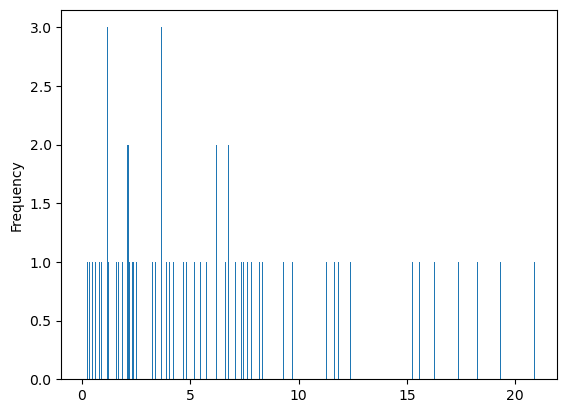

In [133]:
data_miller_favor[data_miller_favor['CageEnhancer.Valid']]['CaddPhred.Float64'].astype(float).plot.hist(by=None, bins=1000)

In [134]:
df = data_miller_favor[(data_miller_favor['CageEnhancer.Valid'] == True) & (data_miller_favor['CaddPhred.Float64']>=10)]
df

,VariantVcf.String,VariantVcf.Valid,Chromosome.String,Chromosome.Valid,Position.String,Position.Valid,BravoAn.Int32,BravoAn.Valid,BravoAc.Int32,BravoAc.Valid,...,Nucdiv.Float64,Nucdiv.Valid,AloftValue.String,AloftValue.Valid,AloftDescription.String,AloftDescription.Valid,FunseqValue.String,FunseqValue.Valid,FunseqDescription.String,FunseqDescription.Valid
691,2-57959584-G-T,True,2,True,57959584,True,0,False,0,False,...,2.30,True,NaN,False,NaN,False,NaN,False,noncoding,True
2153,1-27597679-G-A,True,1,True,27597679,True,0,False,0,False,...,1.45,True,NaN,False,NaN,False,NaN,False,noncoding,True
2249,1-40654224-G-C,True,1,True,40654224,True,0,False,0,False,...,2.95,True,NaN,False,NaN,False,NaN,False,noncoding,True
2602,2-215358016-A-G,True,2,True,215358016,True,0,False,0,False,...,3.75,True,NaN,False,NaN,False,NaN,False,noncoding,True
2748,2-240259416-T-G,True,2,True,240259416,True,0,False,0,False,...,7.15,True,NaN,False,NaN,False,NaN,False,noncoding,True
4867,4-152554332-A-G,True,4,True,152554332,True,0,False,0,False,...,2.30,True,NaN,False,NaN,False,NaN,False,noncoding,True
5874,5-134925481-G-C,True,5,True,134925481,True,0,False,0,False,...,2.60,True,NaN,False,NaN,False,NaN,False,noncoding,True
6436,6-42453841-G-A,True,6,True,42453841,True,264690,True,34,True,...,2.90,True,NaN,False,NaN,False,NaN,False,noncoding,True
6578,6-68636324-A-G,True,6,True,68636324,True,0,False,0,False,...,1.55,True,NaN,False,NaN,False,NaN,False,noncoding,True
6691,6-90274658-C-G,True,6,True,90274658,True,264690,True,1,True,...,2.45,True,NaN,False,NaN,False,NaN,False,noncoding,True


<Axes: ylabel='ApcProteinFunctionV3.Float64'>

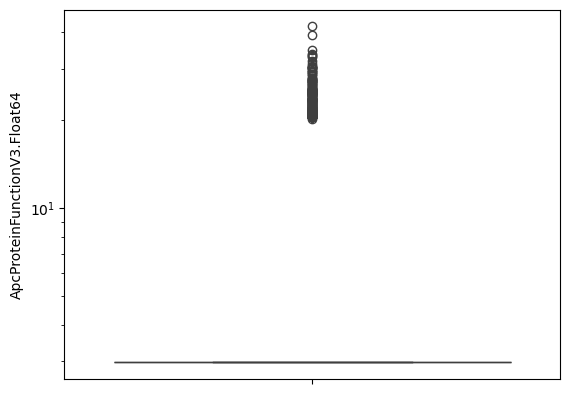

In [135]:
# data_miller_favor['ApcProteinFunctionV3.Float64'].astype(float).plot.hist(by=None, bins=100)
sns.boxplot(data_miller_favor['ApcProteinFunctionV3.Float64'].astype(float), log_scale=True)

<Axes: ylabel='Frequency'>

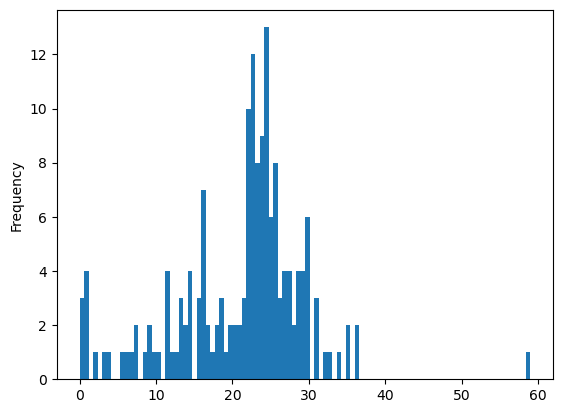

In [136]:
data_miller_favor[data_miller_favor['ApcProteinFunctionV3.Float64'].astype(float) > 10]['CaddPhred.Float64'].astype(float).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

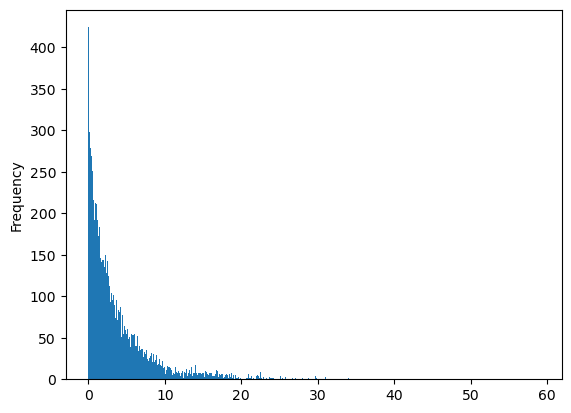

In [137]:
data_miller_favor['CaddPhred.Float64'].astype(float).plot.hist(by=None, bins=1000)

<Axes: ylabel='Frequency'>

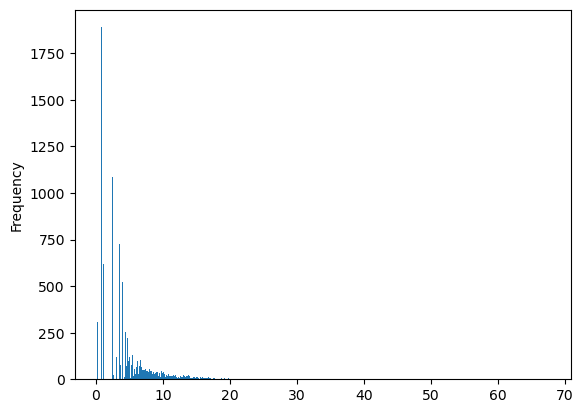

In [138]:
data_miller_favor['Linsight.Float64'].astype(float).plot.hist(by=None, bins=1000)

<Axes: ylabel='Frequency'>

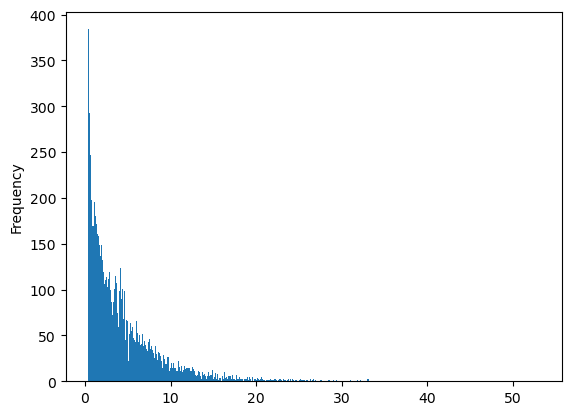

In [139]:
data_miller_favor['FathmmXf.Float64'].astype(float).plot.hist(by=None, bins=1000)

<Axes: ylabel='Frequency'>

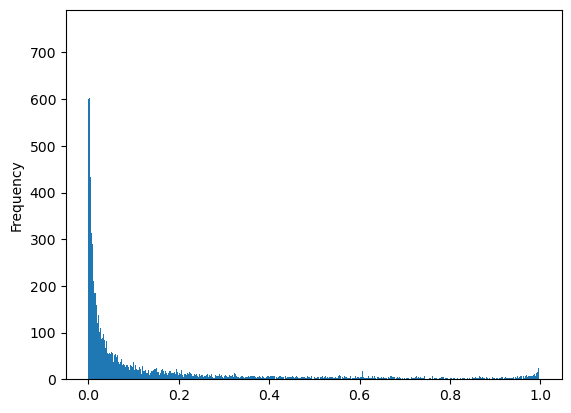

In [140]:
data_miller_favor['Priphcons.Float64'].astype(float).plot.hist(by=None, bins=1000)

<Axes: ylabel='Frequency'>

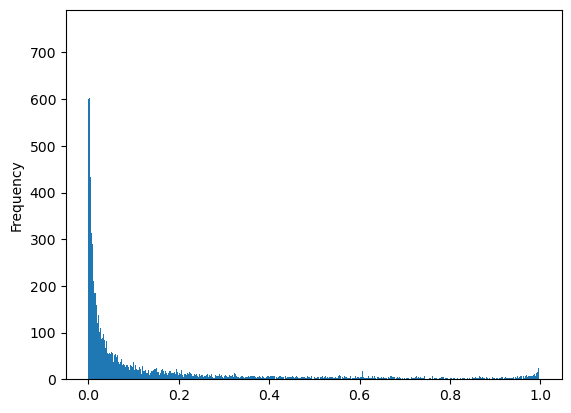

In [141]:
data_miller_favor['Priphcons.Float64'].astype(float).plot.hist(by=None, bins=1000)


## VEP + FAVOR helpers

### From VEP

In [11]:
consequences = {
    'CDS': ['synonymous_variant', 'missense_variant', 'inframe_insertion', 'inframe_deletion', 
            'start_gained', 'start_lost', 'stop_gained', 'stop_lost', 'start_retained_variant', 'stop_retained_variant',
            # 'coding_sequence_variant', 'coding_transcript_variant', 
            'incomplete_terminal_codon_variant', 'protein_altering_variant',
            'transcript_ablation', 'transcript_amplification', 'frameshift_variant', 'feature_elongation', 'feature_truncation'],

    'SPLICE': ['splice_acceptor_variant', 'splice_donor_variant', 'splice_region_variant', 'splice_donor_5th_base_variant', 'splice_donor_region_variant', 
               'splice_polypyrimidine_tract_variant'],

    'NCREG': ['5_prime_UTR_variant', '3_prime_UTR_variant', 'regulatory_region_variant', 'regulatory_region_ablation', 'regulatory_region_amplification', 
              'TF_binding_site_variant', 'TFBS_ablation', 'TFBS_amplification'],

    'NCRNA': ['mature_miRNA_variant', 'non_coding_transcript_exon_variant', 'non_coding_transcript_variant'],
    
    'NCOTH': ['upstream_gene_variant', 'downstream_gene_variant', 'intron_variant', 'intergenic_variant', 'sequence_variant', 'NMD_transcript_variant']
}

biotypes = {
    'CDS': ['protein_coding', 'protein_coding_LoF'],

    'SPLICE': [],

    'NCREG': ['promoter', 'enhancer', 'CTCF_binding_site', 'open_chromatin_region'],

    'NCRNA': ['lncRNA', 'miRNA', 'miRNA_pseudogene', 'sRNA', 'snRNA', 'snlRNA', 'snoRNA', 'scaRNA', 'rRNA', 'rRNA_pseudogene', 'tRNA', 'tRNA_pseudogene', 
              'misc_RNA', 'misc_RNA_pseudogene', 'ribozyme'],
    
    'NCOTH': ['transcribed_processed_pseudogene', 'transcribed_unprocessed_pseudogene', 'processed_pseudogene', 'unprocessed_pseudogene', 
              'unitary_pseudogene', 'transcribed_unitary_pseudogene', 'TR_V_pseudogene', 'TR_V_gene', 'IG_C_pseudogene', 'IG_V_gene', 'IG_V_pseudogene',
              'TEC']
}

severity_order = [
    'transcript_ablation','splice_acceptor_variant','splice_donor_variant','stop_gained','frameshift_variant','stop_lost','start_lost',
    'transcript_amplification','feature_elongation','feature_truncation',

    'inframe_insertion', 'inframe_deletion', 'missense_variant', 'protein_altering_variant',
    
    'splice_donor_5th_base_variant', 'splice_region_variant', 'splice_donor_region_variant', 'splice_polypyrimidine_tract_variant', 
    'incomplete_terminal_codon_variant', 'start_retained_variant', 'stop_retained_variant', 'synonymous_variant',
    
    'coding_sequence_variant', 'mature_miRNA_variant', '5_prime_UTR_variant', '3_prime_UTR_variant', 'non_coding_transcript_exon_variant', 'intron_variant',
    'NMD_transcript_variant', 'non_coding_transcript_variant', 'coding_transcript_variant', 'upstream_gene_variant', 'downstream_gene_variant',
    'TFBS_ablation', 'TFBS_amplification', 'TF_binding_site_variant', 'regulatory_region_ablation', 'regulatory_region_amplification', 'regulatory_region_variant',
    'intergenic_variant', 'sequence_variant'
]

severity_rank = {c: i for i, c in enumerate(severity_order[::-1])}  # low = less severe, high = more severe

In [12]:
vep_cols_shortlist = [
    'CHROM', 'POS', 'REF', 'ALT', 'CLASS',
    'Location', 'Consequence', 'IMPACT',
    'SYMBOL', 'Gene', 'Feature', 'BIOTYPE',
    'EXON', 'INTRON', 'DISTANCE', 'STRAND',
    'SIFT', 'PolyPhen', 'MutationAssessor_rankscore', 'MutationTaster_converted_rankscore',
    'miRNA',
    'PHENOTYPES', 'GO',
    'am_class', 'am_pathogenicity',
    'CADD_PHRED', 'CADD_RAW',
    'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref',
    'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL',
    'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
    'SpliceAI_pred_SYMBOL',
    'ClinPred',
    'REVEL',
    'pHaplo', 'pTriplo',
    'AlphaMissense_rankscore', 'BayesDel_addAF_rankscore', 'BayesDel_noAF_rankscore', 'DANN_rankscore', 'DEOGEN2_rankscore', 'ESM1b_rankscore',
    'Eigen-PC-phred_coding', 'Eigen-PC-raw_coding_rankscore', 'Eigen-raw_coding_rankscore',
    'LIST-S2_rankscore', 'MPC_rankscore', 'MVP_rankscore', 'MetaLR_rankscore', 'MetaRNN_rankscore', 'MetaSVM_rankscore', 'MutFormer_rankscore',
    'PROVEAN_converted_rankscore', 'PrimateAI_rankscore',
    'VARITY_ER_LOO_rankscore', 'VARITY_R_LOO_rankscore',
    'fathmm-XF_coding_rankscore',
    'gMVP_rankscore',
    'LOEUF',
    'CDS', 'CDS_biotype', 'SPLICE', 'SPLICE_biotype', 'NCREG', 'NCREG_biotype', 'NCRNA', 'NCRNA_biotype', 'NCOTH', 'NCOTH_biotype']

### From FAVOR

In [13]:
favor_cols = [
    'VariantVcf.String', 'Chromosome.String', 'Position.String',
    'Rsid.String',

    # genomic regions
    'GenecodeComprehensiveCategory.String', # regions
    'GenecodeComprehensiveInfo.String', 'UcscInfo.String', 'RefseqInfo.String', # genes
    'GenecodeComprehensiveExonicCategory.String', # syn/non-syn/stop
    'GenecodeComprehensiveExonicInfo.String', 'UcscExonicInfo.String', 'RefseqExonicInfo.String', # exons
    'CagePromoter.String', #'CagePromoter.Valid', # promoters
    'CageEnhancer.String', 'Genehancer.String', 'SuperEnhancer.String', # enhancers
    # 'CageEnhancer.Valid', 'Genehancer.Valid', 'SuperEnhancer.Valid', 
    
    # high-coverage scores
    'CaddPhred.Float64', 'CaddRawscore.Float64', 'Linsight.Float64', 'FathmmXf.Float64', 
    
    # low-coverage scores
    'Polyphen2HdivScore.Float64', 'Polyphen2HvarScore.Float64', 'MutationTasterScore.Float64', 'MutationAssessorScore.Float64', 'MetasvmPred.String',
    'SiftCat.String', 'SiftVal.Float64', 'PolyphenCat.String', 'PolyphenVal.Float64', 'Grantham.Float64',
    'AloftValue.String', 'AloftDescription.String', # recessive/dominant/benign; putative LoF variants in protein-coding genes
    'FunseqValue.String', 'FunseqDescription.String', # coding/noncoding; regulatory mutations from cancer genome sequencing

    # genomic details
    'Origin.String',
    'Gc.Float64', 'Cpg.Float64', # Percent in +/- 75bp
    'MinDistTss.Int32', 'MinDistTse.Int32',

    # aPCs are in PHRED scale [0,100]
    'ApcProteinFunctionV3.Float64', # low-coverage scores: SIFTval, PolyPhenVal, Grantham, Polyphen2_HDIV_score, Polyphen2_HVAR_score, MutationTaster_score, MutationAssessor_score
    'ApcConservationV2.Float64', # GerpN, GerpS, priPhCons, mamPhCons, verPhCons, priPhyloP, mamPhyloP, verPhyloP
    # 'ApcEpigeneticsActive.Float64', # EncodeH3K4me1.max, EncodeH3K4me2.max, EncodeH3K4me3.max, EncodeH3K9ac.max, EncodeH3K27ac.max, EncodeH4K20me1.max，EncodeH2AFZ.max
    # 'ApcEpigeneticsRepressed.Float64', # EncodeH3K9me3.max, EncodeH3K27me3.max
    # 'ApcEpigeneticsTranscription.Float64', # EncodeH3K36me3.max, EncodeH3K79me2.max
    # 'ApcTranscriptionFactor.Float64', # RemapOverlapTF, RemapOverlapCL - number of binding TFs/cell-line combinations 
    # 'ApcLocalNucleotideDiversityV3.Float64', # bStatistic, RecombinationRate, NuclearDiversity
    # 'ApcMappability.Float64', # umap_k100, bismap_k100, umap_k50, bismap_k50, umap_k36, bismap_k36, umap_k24, bismap_k24
    # 'ApcMutationDensity.Float64', # Common100bp, Rare100bp, Sngl100bp, Common1000bp, Rare1000bp, Sngl1000bp, Common10000bp, Rare10000bp, Sngl10000bp

    # 'EncodeDnaseSum.Float64', 'EncodetotalRnaSum.Float64', # other Encodes
    # 'TgAll.Float64', 'AfTotal.Float64', 'AfFemale.Float64', 'AfMale.Float64', # genome allele frequencies
]

favor_cols_shortlist = [x.split('.')[0] for x in favor_cols]

## Load FAVOR-annotated datasets

In [179]:
dfs_favor = {}
for t in tissues_full:

    favor_fname = f'{favor_dir}/{t.lower()}_favor.tsv.gz'

    if os.path.exists(favor_fname):
        df = pd.read_csv(favor_fname, sep='\t', index_col=False)
        
        df = df[favor_cols].copy()
        df.columns = df.columns.str.split('.', expand=True).get_level_values(0)
        df[COLS_MAIN] = df['VariantVcf'].str.split('-', expand=True)

        dfs_favor[t] = df.copy()
    
    else:
        dfs_favor[t] = pd.DataFrame()

# dfs_favor[t]

/tmp/ipykernel_752490/3393720815.py:7: DtypeWarning: Columns (19,25,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(favor_fname, sep='\t', index_col=False)
/tmp/ipykernel_752490/3393720815.py:7: DtypeWarning: Columns (18,19,21,25,27,29,31,33,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(favor_fname, sep='\t', index_col=False)
/tmp/ipykernel_752490/3393720815.py:7: DtypeWarning: Columns (19,25,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(favor_fname, sep='\t', index_col=False)
/tmp/ipykernel_752490/3393720815.py:7: DtypeWarning: Columns (19,25,27,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(favor_fname, sep='\t', index_col=False)


In [180]:
# df_lung_favor = dfs_favor['Lung'].copy()
# df_heart_favor = dfs_favor['Heart'].copy()
# df_heart_favor

In [181]:
# df_lung_favor.query('ApcProteinFunctionV3 > 3')['ApcProteinFunctionV3'].plot.hist(bins=100)
# df_lung_favor['Linsight'].plot.box()
# df_lung_favor['FathmmXf'].plot.box()

In [182]:
# def phred_to_prob(x):
#     return 1 - 10 ** (-x / 10)

# def cadd_to_prob(x):
#     A, B = 1, 2.5
#     return 1 / (1 + np.exp(-A-x+B))

# # x = np.arange(-2,10,0.1)
# # sns.lineplot(x=x, y=cadd_to_prob(x))

# df_lung_favor['Cadd_transformed'] = cadd_to_prob(df_lung_favor['CaddRawscore'])
# # sns.boxplot(df_lung_favor[df_lung_favor['GenecodeComprehensiveCategory'] != 'exonic']['Cadd_transformed'])
# sns.boxplot(df_lung_favor['apc'])

# # df_lung_favor['noncoding'] = df_lung_favor[['CaddPhred', 'Linsight', 'FathmmXf']].median(axis=1)
# # df_lung_favor['noncoding'] = df_lung_favor[['CaddPhred', 'Linsight', 'FathmmXf']].apply(lambda x: phred_to_prob(x)).median(axis=1)
# # sns.scatterplot(data=df_lung_favor, x='Linsight', y='FathmmXf', hue='noncoding')

## Load MutScore data

In [26]:
mutscore_df = pd.read_parquet('/tank/projects/computagehub/annotation/snvs/mutscore-v1.0-hg38.parquet')
mutscore_df

,CHROM,POS,REF,ALT,MutScore
0,1,69091,A,C,0.131
1,1,69091,A,G,0.063
2,1,69091,A,T,0.131
3,1,69092,T,A,0.198
4,1,69092,T,C,0.142
...,...,...,...,...,...
71718770,17_KI270857v1_alt,489178,G,C,0.053
71718771,17_KI270857v1_alt,489178,G,T,0.047
71718772,17_KI270857v1_alt,489180,G,A,0.030
71718773,17_KI270857v1_alt,489180,G,C,0.122


## CLASSIFICATION

In [183]:
def postprocess_annotations(df_vep, df_favor=None, indel=False):
    df_vep = df_vep.copy()
    
    df_vep[['CHROM', 'POS']] = df_vep['Location'].str.split(':', expand=True)
    df_vep['POS'] = df_vep['POS'].str.split('-', expand=True)[0]
    df_vep['REF'] = df_vep['REF_ALLELE']
    df_vep['ALT'] = df_vep['Allele']

    df_vep = df_vep.replace('-', np.nan)

    df_vep['POS'] = df_vep['POS'].astype(int)
    mutscore_df['POS'] = mutscore_df['POS'].astype(int)
    
    if not indel:
        df_favor['POS'] = df_favor['POS'].astype(int)
            
        df_ann = df_vep.merge(df_favor, left_on=COLS_MAIN, right_on=COLS_MAIN, how='left')
        df_ann = df_ann.merge(mutscore_df, left_on=COLS_MAIN, right_on=COLS_MAIN, how='left')
        df_ann = df_ann.sort_values(['CHROM', 'POS'], ascending=True, ignore_index=True)
    
    else:
        df_vep[['REF', 'ALT']] = df_vep[['REF', 'ALT']].fillna('-')

        df_ann = df_vep.merge(mutscore_df, left_on=COLS_MAIN, right_on=COLS_MAIN, how='left')
        df_ann = df_ann.sort_values(['CHROM', 'POS'], ascending=True, ignore_index=True)
    
    return df_ann

def classify(df_ann, indel=False):

    for region in consequences:
        df_ann[region] = df_ann['Consequence'].str.contains('|'.join(consequences[region]), case=False, na=False)
        df_ann[f'{region}_biotype'] = df_ann['BIOTYPE'].str.contains('|'.join(biotypes[region]), case=False, na=False)

    if not indel:

        df_ann['CLASS'] = df_ann.apply(lambda x:
            'CDS' if (x['CDS'] == True) else
            'SPLICE' if (x['SPLICE'] == True and x['NCRNA_biotype'] == False) or (x['GenecodeComprehensiveCategory'] in ['splicing', 'exonic;splicing']) else
            'NCREG' if (
                x['NCREG'] == True or 
                x['NCREG_biotype'] == True or 
                x['GenecodeComprehensiveCategory'] in ['UTR5', 'UTR3'] or
                x[['CagePromoter', 'CageEnhancer', 'Genehancer', 'SuperEnhancer']].any() == True
                ) else
            'NCRNA' if (
                x['NCRNA_biotype'] == True or
                x['GenecodeComprehensiveCategory'] in ['ncRNA_exonic', 'ncRNA_intronic']
                ) else
            'NCOTH',
            axis=1
        )

        df_ann = df_ann[vep_cols_shortlist + favor_cols_shortlist + ['MutScore']].copy()

    else:

        df_ann['CLASS'] = df_ann.apply(lambda x:
            'CDS' if (x['CDS'] == True) else
            'SPLICE' if ((x['SPLICE'] == True) and (x['NCRNA_biotype'] == False)) else
            'NCREG' if (x['NCREG'] == True or x['NCREG_biotype'] == True) else
            'NCRNA' if (x['NCRNA_biotype'] == True) else
            'NCOTH',
            axis=1
        )

        df_ann = df_ann[vep_cols_shortlist + ['MutScore']].copy()

    # df_ann['CLASS'] = df_ann.apply(lambda x: 
    #     'CDS' if x['GenecodeComprehensiveCategory'] == 'exonic' else
    #     # 'SPLICE' if (x['SPLICE'] == True) and (x['NCRNA_biotype'] == False) else
    #     'SPLICE' if x['GenecodeComprehensiveCategory'] in ['splicing', 'exonic;splicing'] else
    #     'NCREG' if 
    #         x['GenecodeComprehensiveCategory'] in ['UTR5', 'UTR3', 'upstream', 'downstream', 'upstream;downstream'] or
    #         x[['CagePromoter', 'CageEnhancer', 'Genehancer', 'SuperEnhancer']].any() == True 
    #         else
    #     'NCRNA' if x['GenecodeComprehensiveCategory'] in ['ncRNA_exonic', 'ncRNA_intronic'] else
    #     'NCOTH',
    #     axis=1
    # )
    # df_ann = df_ann[vep_cols_shortlist + favor_cols_shortlist + ['MutScore']]
    # df_vep = df_vep[vep_cols_shortlist]

    return df_ann

## Annotation starts

### SNVs

In [187]:
dfs_ann, dfs_vep = {}, {}

for t in tissues_full:

    if len(ann_dict[t]) > 1:
        # dfs_vep[t] = pd.concat([
        #     pd.read_csv(f'{vep_dir}/{dataset}_vep.txt', sep='\t')
        #     for dataset in ann_dict[t]
        # ], ignore_index=True, copy=False)
        dfs_vep[t] = pd.concat([
            pd.read_csv(f'{vep_dir}/{ann_dict[t][dataset]}_vep.txt', sep='\t')
            for dataset in ann_dict[t] if os.path.exists(f'{vep_dir}/{ann_dict[t][dataset]}_vep.txt')
        ], ignore_index=True, copy=False)
    else:
        vep_fname = f'{vep_dir}/{list(ann_dict[t].values())[0]}_vep.txt'
        if os.path.exists(vep_fname):
            dfs_vep[t] = pd.read_csv(vep_fname, sep='\t')
        else:
            dfs_vep[t] = pd.DataFrame()
    
    print(f'{t}: {dfs_vep[t].shape[0]} SNV annotations observed')
        
    if dfs_vep[t].shape[0] != 0:
        if dfs_favor[t].shape[0] != 0:

            dfs_ann[t] = postprocess_annotations(df_vep=dfs_vep[t], df_favor=dfs_favor[t])
            dfs_ann[t] = classify(dfs_ann[t])

            ann_path = f'{ann_dir}/{t}_ann.tsv.gz'
            dfs_ann[t].to_csv(ann_path, sep='\t', compression='gzip')

# print(t)
# dfs_ann[t]
# df_lung_ann = postprocess_vep(f'{processed_dir}/vep/2022huang_vep.txt', df_favor=df_lung_favor)
# df_lung_ann = classify(df_lung_ann)
# df_heart_ann = postprocess_vep(f'{processed_dir}/vep/2025choudhury_hg38_vep.txt', df_favor=df_heart_favor)
# df_heart_ann = classify(df_heart_ann)
# df_heart_ann

/tmp/ipykernel_752490/3044258185.py:11: DtypeWarning: Columns (218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'{vep_dir}/{ann_dict[t][dataset]}_vep.txt', sep='\t')


Brain: 55300 SNV annotations observed


/tmp/ipykernel_752490/3044258185.py:17: DtypeWarning: Columns (215,216) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_vep[t] = pd.read_csv(vep_fname, sep='\t')


Heart: 36753 SNV annotations observed
Liver: 62288 SNV annotations observed
Liver_LSC: 20225 SNV annotations observed
Lung: 29743 SNV annotations observed


### Indels

In [188]:
dfs_ann_indel, dfs_vep_indel = {}, {}

for t in tissues_full:

    if len(ann_dict[t]) > 1:
        dfs_vep_indel[t] = pd.concat([
            pd.read_csv(f'{vep_dir}/{ann_dict[t][dataset]}_indel_vep.txt', sep='\t')
            for dataset in ann_dict[t] if os.path.exists(f'{vep_dir}/{ann_dict[t][dataset]}_indel_vep.txt')
        ], ignore_index=True, copy=False)
    else:
        vep_fname = f'{vep_dir}/{list(ann_dict[t].values())[0]}_indel_vep.txt'
        if os.path.exists(vep_fname):
            dfs_vep_indel[t] = pd.read_csv(vep_fname, sep='\t')
        else:
            dfs_vep_indel[t] = pd.DataFrame()
            
    print(f'{t}: {dfs_vep_indel[t].shape[0]} indel annotations observed')
    
    if dfs_vep_indel[t].shape[0] != 0:

        dfs_ann_indel[t] = postprocess_annotations(df_vep=dfs_vep_indel[t], indel=True)
        dfs_ann_indel[t] = classify(dfs_ann_indel[t], indel=True)

        ann_path = f'{ann_dir}/{t}_indel_ann.tsv.gz'
        dfs_ann_indel[t].to_csv(ann_path, sep='\t', compression='gzip')


Brain: 6898 indel annotations observed
Heart: 0 indel annotations observed
Liver: 2130 indel annotations observed
Liver_LSC: 379 indel annotations observed
Lung: 1034 indel annotations observed


In [127]:
# df_test = dfs_ann_indel[t].copy()
# df_test

,CHROM,POS,REF,ALT,CLASS,Location,Consequence,IMPACT,SYMBOL,Gene,...,CDS_biotype,SPLICE,SPLICE_biotype,NCREG,NCREG_biotype,NCRNA,NCRNA_biotype,NCOTH,NCOTH_biotype,MutScore
0,1,10778329,A,-,NCOTH,1:10778329-10778330,intron_variant,MODIFIER,CASZ1,ENSG00000130940,...,True,False,True,False,False,False,False,True,False,NaN
1,1,10778329,A,-,NCOTH,1:10778329-10778330,intron_variant,MODIFIER,CASZ1,ENSG00000130940,...,True,False,True,False,False,False,False,True,False,NaN
2,1,12231754,A,-,NCOTH,1:12231754-12231755,intron_variant,MODIFIER,VPS13D,ENSG00000048707,...,True,False,True,False,False,False,False,True,False,NaN
3,1,12231754,A,-,NCOTH,1:12231754-12231755,intron_variant,MODIFIER,VPS13D,ENSG00000048707,...,True,False,True,False,False,False,False,True,False,NaN
4,1,12231754,A,-,NCRNA,1:12231754-12231755,downstream_gene_variant,MODIFIER,NaN,ENSG00000297053,...,False,False,True,False,False,False,True,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,X,113724831,A,-,NCRNA,X:113724831-113724832,"intron_variant,non_coding_transcript_variant",MODIFIER,XACT,ENSG00000241743,...,False,False,True,False,False,True,True,True,False,NaN
1030,X,115895510,-,T,NCRNA,X:115895510-115895510,"intron_variant,non_coding_transcript_variant",MODIFIER,DANT2,ENSG00000235244,...,False,False,True,False,False,True,True,True,False,NaN
1031,X,115895510,-,T,NCRNA,X:115895510-115895510,"intron_variant,non_coding_transcript_variant",MODIFIER,DANT1,ENSG00000229335,...,False,False,True,False,False,True,True,True,False,NaN
1032,X,143703851,T,-,NCOTH,X:143703851-143703852,intergenic_variant,MODIFIER,NaN,NaN,...,False,False,False,False,False,False,False,True,False,NaN


# Deleteriousness

In [189]:
score_cols = {
    'CODING': [
        # 'SIFT', 'PolyPhen', 
        'MutationAssessor_rankscore', 'MutationTaster_converted_rankscore',
        'ClinPred', 'REVEL', 'fathmm-XF_coding_rankscore', 'am_pathogenicity',
        'AlphaMissense_rankscore', 'BayesDel_addAF_rankscore', 'BayesDel_noAF_rankscore', 'DANN_rankscore', 'DEOGEN2_rankscore', 'ESM1b_rankscore',
        # 'Eigen-PC-phred_coding', 
        'Eigen-PC-raw_coding_rankscore', 'Eigen-raw_coding_rankscore',
        'LIST-S2_rankscore', 'MPC_rankscore', 'MVP_rankscore', 'MetaLR_rankscore', 'MetaRNN_rankscore', 'MetaSVM_rankscore', 'MutFormer_rankscore',
        'PROVEAN_converted_rankscore', 'PrimateAI_rankscore',
        'VARITY_ER_LOO_rankscore', 'VARITY_R_LOO_rankscore',
        'gMVP_rankscore',
        # 'LOEUF',
        'MutScore',
        # 'ApcProteinFunctionV3', 
        'ApcConservationV2',
        'CADD_transformed',
        ],
    'NON_CODING':
        ['CADD_transformed', 'Linsight', 'FathmmXf'],
}
score_cols_list = [v for vs in score_cols.values() for v in vs]

In [190]:
# row = annotate_deleteriousness(df_lung_ann).loc[2381, score_cols['CODING']]#.apply(lambda x: log_odds(x), axis=1)

In [191]:
# def log_odds(x):
#     x = x.astype(float)
#     logO = np.log(x / (1-x))
#     Omean = np.exp(logO.mean())
#     M_odds = Omean / (1 + Omean)
#     return M_odds
# # row = df_lung_del.loc[8346, score_cols['CODING']]#.apply(lambda x: log_odds(x), axis=1)
# row = df_lung_del.loc[8346, score_cols['NON_CODING']]#.apply(lambda x: log_odds(x), axis=1)
# log_odds(row.astype(float)), row.median(), row.mean(), st.gmean(row.astype(float).dropna())

In [192]:
# class_weights = {'CDS':1.0, 'SPLICE':1.0, 'NCREG':0.75, 'NCRNA':0.5, 'NCOTH':0.25}

def phred_to_prob(x):
    return 1 - 10 ** (-x / 10)

def cadd_to_prob(x):
    A, B = 1, 2.5
    return 1 / (1 + np.exp(-A-x+B))

def log_odds(x):
    x = x.astype(float).dropna()
    if len(x) == 0:
        return np.nan
    else: 
        logO = np.log(x / (1-x))
        Omean = np.exp(logO.mean())
        M_odds = Omean / (1 + Omean)
        return M_odds

# Estimate deleteriousness per annotation (= per row)
def annotate_deleteriousness(df, indel=False):
    df = df.copy()
    
    # Transform raw CADD scores to "probabilities" using a sigmoid
    # df['CADD_transformed'] = cadd_to_prob(df['CaddRawscore'].copy())
    df['CADD_transformed'] = cadd_to_prob(df['CADD_RAW'].astype(float).copy())
    
    if not indel:
        # # Drop the floor values of ApcProteinFunctionV3 (mostly in non-coding regions)
        # df['ApcProteinFunctionV3'] = df['ApcProteinFunctionV3'].mask(df['ApcProteinFunctionV3'] < 3, other=np.nan)
        # Transform PHRED-scaled scores from FAVOR to "probabilities"
        # df[['ApcProteinFunctionV3', 'ApcConservationV2']] = df[['ApcProteinFunctionV3', 'ApcConservationV2']].apply(lambda x: phred_to_prob(x))
        df['ApcConservationV2'] = df['ApcConservationV2'].apply(lambda x: phred_to_prob(x))
        # Convert percentage-based scores to fractions
        df[['Linsight', 'FathmmXf']] = df[['Linsight', 'FathmmXf']] / 100 

    coding_score_cols = [col for col in score_cols['CODING'] if col in df.columns]
    noncoding_score_cols = [col for col in score_cols['NON_CODING'] if col in df.columns]
    
    df[coding_score_cols] = df[coding_score_cols].apply(lambda x: x.astype(float))
    df[noncoding_score_cols] = df[noncoding_score_cols].apply(lambda x: x.astype(float))

    df[combined_score_col] = df.apply(lambda x: x[coding_score_cols].median() if x['CLASS'] in ['CDS', 'SPLICE'] else x[noncoding_score_cols].median(), axis=1)
    # df[combined_score_col] = df.apply(lambda x: log_odds(x[score_cols['CODING']]) if x['CLASS'] in ['CDS', 'SPLICE'] else log_odds(x[score_cols['NON_CODING']]), axis=1)
    # [score_cols['CODING']].median(axis=1).fillna(df[score_cols['NON_CODING']].median(axis=1))

    # Multiply the combined score by the probability of a mutation to be haploinsufficient
    df['pHaplo'] = df['pHaplo'].astype(float)
    # df[f'{del_col}_raw'] = df[[combined_score_col, 'pHaplo']].prod(axis=1, min_count=2)
    df[del_col] = df[[combined_score_col, 'pHaplo']].prod(axis=1, min_count=2)

    # df['CLASS_WEIGHTS'] = df['CLASS'].map(class_weights)
    # df[del_col] = df[[f'{del_col}_raw', 'CLASS_WEIGHTS']].prod(axis=1, min_count=2)

    return df

# Filter the annotation table, keeping only the most severe annotations
def collapse_annotations(df):
    df = df.copy()

    df[feat_col] = df[feat_col].fillna('nan').astype(str)

    # 1. Helper function to find the most severe consequence for a row
    def get_most_severe(conseq_str):
        if pd.isna(conseq_str) or conseq_str == '': return -1
        return max(severity_rank.get(c, -1) for c in conseq_str.split(','))
    df[conseq_num_col] = df[conseq_col].apply(get_most_severe)

    # 2. Keep the exact duplicates
    exact_dupes = df[df.duplicated(subset=COLS_MAIN + [feat_col, conseq_col], keep=False)].copy()

    # 3. Pick representative rows per variant (rank inside each group by severity -> DEL -> first)
    ## find rows with maximum Consequence_num per variant
    maxC = df.groupby(COLS_MAIN)[conseq_num_col].transform('max')
    topC = df[df[conseq_num_col] == maxC].copy()
    ## among those, keep rows with max COMBINED_SCORE per variant
    maxDEL = topC.groupby(COLS_MAIN)[combined_score_col].transform('max')
    topC_maxDEL = topC[(topC[combined_score_col] == maxDEL) | maxDEL.isna()] # all rows are kept if combined_score_col is NaN-only
    ## if still multiple, take the first occurrence per group (deterministic)
    best_idx = topC_maxDEL.groupby(COLS_MAIN, sort=False).head(1).index
    best_rows = df.loc[best_idx].copy()

    # 4. Compute SYMBOL aggregation (unique, sorted, skip NaN)
    symbol_agg = df.groupby(COLS_MAIN)[gene_symbol_col].agg(lambda x: ','.join(sorted(set(x.dropna()))) or np.nan).reset_index()
    best_rows = best_rows.merge(symbol_agg, on=COLS_MAIN, how='left', suffixes=('','_agg'))
    best_rows[gene_symbol_col] = best_rows.pop(f'{gene_symbol_col}_agg')

    # 5. Keep only those exact-duplicate groups that match a chosen representative
    dup_group_cols = COLS_MAIN + [feat_col, conseq_col]
    exact_groups = exact_dupes[dup_group_cols].drop_duplicates()
    best_groups  = best_rows[dup_group_cols].drop_duplicates()
    common = exact_groups.merge(best_groups, on=dup_group_cols)   # intersection of groups

    # filter exact duplicates only to groups present in the representatives
    exact_dupes_filtered = exact_dupes.merge(common, on=dup_group_cols, how="inner")

    # remove representatives that correspond to the kept exact groups (avoid double-count)
    best_rows_no_common = best_rows.merge(common, on=dup_group_cols, how='left', indicator=True)
    best_rows_no_common = best_rows_no_common[best_rows_no_common['_merge'] == 'left_only'].drop(columns=['_merge'])

    # 6. Final concat: preserved exact-duplicate rows + remaining representatives
    final = pd.concat(
        [exact_dupes_filtered.reset_index(drop=True), best_rows_no_common.reset_index(drop=True)],
        ignore_index=True) \
        .sort_values(['CHROM', 'POS'], ignore_index=True)
    final.drop(columns=[conseq_num_col], inplace=True)

    return final


## SNVs

In [193]:
# dfs_ann = {}
dfs_del = {}

for t in tissues_full:
    ann_path = f'{ann_dir}/{t}_ann.tsv.gz'
    if os.path.exists(ann_path):
        # dfs_ann[t] = pd.read_csv(ann_path, sep='\t', index_col=0)

        dfs_del[t] = annotate_deleteriousness(dfs_ann[t], indel=False)
        dfs_del[t] = collapse_annotations(dfs_del[t])
        print(f'{t}: {dfs_ann[t].shape[0]} entries before collapsing, {dfs_del[t].shape[0]} after')
    
        print(f'{t}: {dfs_del[t][del_col].dropna().shape[0]} annotations evaluated by deleteriousness out of {dfs_del[t].shape[0]}\n')
    
    else: dfs_del[t] = pd.DataFrame()

# dfs_del[t]

Brain: 55596 entries before collapsing, 28124 after
Brain: 12389 annotations evaluated by deleteriousness out of 28124

Heart: 42283 entries before collapsing, 23669 after
Heart: 8457 annotations evaluated by deleteriousness out of 23669

Liver: 62288 entries before collapsing, 33347 after
Liver: 12820 annotations evaluated by deleteriousness out of 33347

Lung: 29743 entries before collapsing, 15884 after
Lung: 6042 annotations evaluated by deleteriousness out of 15884



## Indels

In [210]:
# dfs_ann_indel = {}
dfs_del_indel = {}

for t in tissues_full:
    ann_path = f'{ann_dir}/{t}_indel_ann.tsv.gz'
    if os.path.exists(ann_path):
        dfs_ann_indel[t] = pd.read_csv(ann_path, sep='\t', index_col=0)

        dfs_del_indel[t] = annotate_deleteriousness(dfs_ann_indel[t], indel=True)
        dfs_del_indel[t] = collapse_annotations(dfs_del_indel[t])
        print(f'{t}: {dfs_ann_indel[t].shape[0]} entries before collapsing, {dfs_del_indel[t].shape[0]} after')
    
        print(f'{t}: {dfs_del_indel[t][del_col].dropna().shape[0]} annotations evaluated by deleteriousness out of {dfs_del_indel[t].shape[0]}\n')
    
    else: dfs_del_indel[t] = pd.DataFrame()

# dfs_del_indel[t]

Brain: 6898 entries before collapsing, 2984 after
Brain: 220 annotations evaluated by deleteriousness out of 2984

Liver: 2130 entries before collapsing, 1042 after
Liver: 111 annotations evaluated by deleteriousness out of 1042

Liver_LSC: 379 entries before collapsing, 202 after
Liver_LSC: 30 annotations evaluated by deleteriousness out of 202

Lung: 1034 entries before collapsing, 504 after
Lung: 65 annotations evaluated by deleteriousness out of 504



In [211]:
dfs_ann_indel[t]

,CHROM,POS,REF,ALT,CLASS,Location,Consequence,IMPACT,SYMBOL,Gene,...,CDS_biotype,SPLICE,SPLICE_biotype,NCREG,NCREG_biotype,NCRNA,NCRNA_biotype,NCOTH,NCOTH_biotype,MutScore
0,1,10778329,A,-,NCOTH,1:10778329-10778330,intron_variant,MODIFIER,CASZ1,ENSG00000130940,...,True,False,True,False,False,False,False,True,False,NaN
1,1,10778329,A,-,NCOTH,1:10778329-10778330,intron_variant,MODIFIER,CASZ1,ENSG00000130940,...,True,False,True,False,False,False,False,True,False,NaN
2,1,12231754,A,-,NCOTH,1:12231754-12231755,intron_variant,MODIFIER,VPS13D,ENSG00000048707,...,True,False,True,False,False,False,False,True,False,NaN
3,1,12231754,A,-,NCOTH,1:12231754-12231755,intron_variant,MODIFIER,VPS13D,ENSG00000048707,...,True,False,True,False,False,False,False,True,False,NaN
4,1,12231754,A,-,NCRNA,1:12231754-12231755,downstream_gene_variant,MODIFIER,NaN,ENSG00000297053,...,False,False,True,False,False,False,True,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,X,113724831,A,-,NCRNA,X:113724831-113724832,"intron_variant,non_coding_transcript_variant",MODIFIER,XACT,ENSG00000241743,...,False,False,True,False,False,True,True,True,False,NaN
1030,X,115895510,-,T,NCRNA,X:115895510-115895510,"intron_variant,non_coding_transcript_variant",MODIFIER,DANT2,ENSG00000235244,...,False,False,True,False,False,True,True,True,False,NaN
1031,X,115895510,-,T,NCRNA,X:115895510-115895510,"intron_variant,non_coding_transcript_variant",MODIFIER,DANT1,ENSG00000229335,...,False,False,True,False,False,True,True,True,False,NaN
1032,X,143703851,T,-,NCOTH,X:143703851-143703852,intergenic_variant,MODIFIER,NaN,NaN,...,False,False,False,False,False,False,False,True,False,NaN


In [195]:
# df_test_del = dfs_del_indel[t]
# df_test_del

In [196]:
# df_test_del[del_col].dropna()
# dfs_del_indel[t][del_col].dropna()

In [197]:
# df_test_del[[combined_score_col, 'pHaplo']].prod(axis=1, min_count=1)
# df_test_del[combined_score_col] * df_test_del['pHaplo']

In [198]:
# df_test_del.query('DELETERIOUS > 0.99')['pHaplo']

# Essentiality

## Essentialomes

In [ ]:
ess = {}
lfc_thresh = 0
pval_thresh = 0.1

# Mouse to human gene names liftover
bm = Biomart()
m2h_df = bm.query(
    dataset='mmusculus_gene_ensembl',
    attributes=['ensembl_gene_id','external_gene_name',
                'hsapiens_homolog_ensembl_gene',
                'hsapiens_homolog_associated_gene_name'])

def m2h(mouse_gene_list, m2h_df=m2h_df):
    input_regex = '|'.join([f'^{g}$' for g in mouse_gene_list])

    m2h_df = m2h_df.dropna(subset='external_gene_name').copy()
    m2h_df = m2h_df[m2h_df['external_gene_name'].str.contains(input_regex, regex=True)] \
        .dropna(subset='hsapiens_homolog_associated_gene_name')
    
    return m2h_df['hsapiens_homolog_associated_gene_name'].sort_values().unique().tolist()

In [ ]:
# Brain

ess_brain_wertz = pd.read_excel(
    f'{essentialomes_dir}/essential_brain_wertz.xlsx', sheet_name=['WTEssential_shRNA_Screen_DrugZ', 'WTEssential_CRISPR_Screen_DrugZ'], skiprows=1)

# ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ'] = ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ'][ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ']['wt_normZ'] < lfc_thresh_wertz]
# ess_brain_wertz = pd.concat(ess_brain_wertz.values()).reset_index(drop=True)
ess_brain_wertz = ess_brain_wertz['WTEssential_CRISPR_Screen_DrugZ'].copy()

ess_brain_ramani = pd.read_excel(
    f'{essentialomes_dir}/essential_brain_ramani.xlsx', 
    sheet_name=['M1+M3 hsyn_Fig 3', 'M1_CaMKII_Fig4', 'M1_hI56i_Fig5', 
                'M1_hsyn_allsgrnas_Fig5', 'M1_hsyn_invsgRNAs_Fig5', 'M1_hi56i_allsgrnas_Fig5', 'M1_hi56i_invsgRNAs_Fig5',
                'chaperone_hsyn_Fig7'], skiprows=0)
ess_brain_ramani = pd.concat(ess_brain_ramani.values())
ess_brain_ramani = ess_brain_ramani[(ess_brain_ramani['log2fc (knockdown phenotype)'] < lfc_thresh) & (ess_brain_ramani['fdr'] <= pval_thresh)]
ess_brain_ramani = ess_brain_ramani.drop_duplicates(subset='gene').reset_index(drop=True)

print(ess_brain_wertz['Gene'].shape[0], ess_brain_ramani['gene'].shape[0])

ess['Brain'] = ess_brain_wertz['Gene'].tolist() + ess_brain_ramani['gene'].tolist()
ess['Brain'] = m2h(ess['Brain'])
len(ess['Brain'])

668 213


808

In [ ]:
# Heart
ess_heart_vandusen = pd.read_excel(f'{essentialomes_dir}/essential_heart_vandusen_sd3.xlsx', sheet_name=['FINAL_25samp_MaGeCK', 'FINAL_25samp_DESeq2'], skiprows=0)
ess_heart_vandusen['FINAL_25samp_MaGeCK'] = ess_heart_vandusen['FINAL_25samp_MaGeCK'][
    (ess_heart_vandusen['FINAL_25samp_MaGeCK']['neg|lfc'] < lfc_thresh) & \
    (ess_heart_vandusen['FINAL_25samp_MaGeCK']['neg|p-value'] <= pval_thresh)].copy()
ess_heart_vandusen['FINAL_25samp_DESeq2'] = ess_heart_vandusen['FINAL_25samp_DESeq2'][
    (ess_heart_vandusen['FINAL_25samp_DESeq2']['log fold change (to basis 2)'] < lfc_thresh) & \
    (ess_heart_vandusen['FINAL_25samp_DESeq2']['p value adjusted for multiple testing with the Benjamini-Hochberg procedure which controls false discovery rate (FDR)'] <= pval_thresh)].copy()

ess['Heart'] = list(set(
    ess_heart_vandusen['FINAL_25samp_MaGeCK']['id'].tolist() + \
    ess_heart_vandusen['FINAL_25samp_DESeq2']['gene_gRNAidentifier'].str.rpartition('_', expand=True)[0].tolist()
))
print(len(ess['Heart']))
ess['Heart'] = m2h(ess['Heart'])

ess_heart_cacheiro = pd.read_csv(f'{essentialomes_dir}/essential_heart_cacheiro.txt', sep='\t')
ess_heart_cacheiro = ess_heart_cacheiro[ess_heart_cacheiro['viability'].isin(['lethal', 'subviable'])]
print(len(ess['Heart']), ess_heart_cacheiro['gene_symbol'].unique().shape[0])

ess['Heart'] = sorted(list(set(ess['Heart'] + ess_heart_cacheiro['gene_symbol'].to_list())))

len(ess['Heart'])

568
545 43


583

In [ ]:
# Liver

ess_liver_jia = pd.read_excel(f'{essentialomes_dir}/essential_liver_jia.xlsx', sheet_name=['CRISPRa results', 'CRISPRko results'], skiprows=1)
ess_liver_jia['CRISPRa results'] = ess_liver_jia['CRISPRa results'][(ess_liver_jia['CRISPRa results']['LFC'] > lfc_thresh) & (ess_liver_jia['CRISPRa results']['p_val'] <= pval_thresh)].copy()
ess_liver_jia['CRISPRko results'] = ess_liver_jia['CRISPRko results'][(ess_liver_jia['CRISPRko results']['LFC'] < lfc_thresh) & (ess_liver_jia['CRISPRko results']['p_val'] <= pval_thresh)].copy()
ess_liver_jia = pd.concat(ess_liver_jia.values()).reset_index(drop=True)

ess_liver_keys = pd.read_excel(f'{essentialomes_dir}/essential_liver_keys.xlsx', sheet_name=['SuppTab3_gene_summary_negative'], skiprows=1)['SuppTab3_gene_summary_negative']
ess_liver_keys = ess_liver_keys[(ess_liver_keys['median.lfc.all'] < lfc_thresh) & (ess_liver_keys['p.wilcox.bh'] <= pval_thresh)].copy()

print(ess_liver_jia.shape[0], ess_liver_keys.shape[0])
ess['Liver'] = sorted(list(set(
    ess_liver_jia['id'].tolist() + ess_liver_jia['alternative name'].dropna().tolist() + \
    ess_liver_keys['id'].to_list()
)))

ess['Liver'] = m2h(ess['Liver'])
len(ess['Liver'])

35 1052


988

In [ ]:
# Lungs - from OGEEv3 lung cancer-essential genes

ess_ness_pct_thresh = 50
ess_ogee_tissue = pd.read_csv(f'{essentialomes_dir}/OGEEv3_tissueSpecific.txt.gz', sep='\t', skiprows=0)
ess_ogee_lung = ess_ogee_tissue[(ess_ogee_tissue['tissue'] == 'lung') & (ess_ogee_tissue['percent'] >= ess_ness_pct_thresh)]
ess['Lung'] = ess_ogee_lung['genes'].unique().tolist()
print(len(ess['Lung']))

621


In [ ]:
# Adding from human scEssentials and OGEEv3 CEGs (core-essential genes across 80+% cell lines)

ess_scessential = pd.read_csv(
    f'{essentialomes_dir}/scEssential_hsa.csv') \
    .sort_values('ES_score').reset_index(drop=True).drop(columns=['Unnamed: 0'])
ess['scEssential'] = ess_scessential['Gene'].sort_values().unique().tolist()
print(len(ess['scEssential']))

ess_ogee = pd.read_csv(f'{essentialomes_dir}/OGEEv3_CSEGs_CEGs.txt.gz', sep='\t', skiprows=11)
ess_ogee = ess_ogee[ess_ogee['essentiality'] == 'CEGs']
ess['OGEE'] = ess_ogee['gene'].sort_values().tolist()
print(len(ess['OGEE']))

1969
606


In [ ]:
import itertools
def lists_of_genes_to_overlap_matrix(input_dict):
    keys = list(input_dict.keys())

    # Compute overlap sizes for all unordered (i, j) pairs (incl. diagonal)
    pairs = list(itertools.combinations_with_replacement(keys, 2))
    
    records = []
    for k1, k2 in pairs:
        inter_size = len(set(input_dict[k1]) & set(input_dict[k2]))
        flags = {cat: (cat == k1 or cat == k2) for cat in keys}
        flags['value'] = inter_size
        records.append(flags)

    df_expanded = pd.DataFrame(records)

    # Group by Boolean presence pattern and sum values
    grouped = df_expanded.groupby(keys)['value'].sum()

    # Fill in missing combinations (2^N) with 0s
    full_index = pd.MultiIndex.from_product(
        [[False, True]] * len(keys),
        names=keys
    )
    return grouped.reindex(full_index, fill_value=0).astype(int)

ess_overlaps = lists_of_genes_to_overlap_matrix(ess)
ess_overlaps = ess_overlaps[ess_overlaps > 0]
ess_overlaps

Brain  Heart  Liver  Lung   scEssential  OGEE 
False  False  False  False  False        True      606
                            True         False    1969
                                         True      280
                     True   False        False     621
                                         True      290
                            True         False     260
              True   False  False        False     988
                                         True      373
                            True         False     468
                     True   False        False     327
       True   False  False  False        False     583
                                         True       28
                            True         False     147
                     True   False        False      31
              True   False  False        False      67
True   False  False  False  False        False     808
                                         True       92
                  

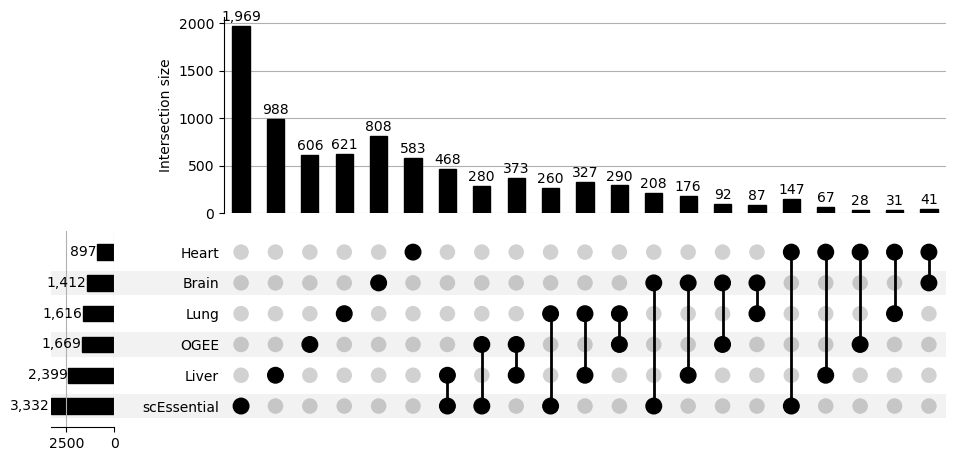

In [171]:
from upsetplot import generate_counts, plot
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    plot(ess_overlaps, show_counts="{:,}")
plt.show()

In [ ]:
ess_combined = {
    t.capitalize(): sorted(list(set(ess[t.capitalize()] + ess['OGEE'])))
    # t: sorted(list(set(ess[t] + ess['OGEE'] + ess['scEssential'])))
    for t in tissues}

print({k:len(v) for k,v in ess.items()})
print({k:len(v) for k,v in ess_combined.items()})

{'Brain': 808, 'Heart': 583, 'Liver': 988, 'Lung': 621, 'scEssential': 1969, 'OGEE': 606}
{'Brain': 1322, 'Heart': 1161, 'Liver': 1221, 'Lung': 937}


In [ ]:
ess_combined_overlaps = lists_of_genes_to_overlap_matrix(ess_combined)
ess_combined_overlaps = ess_combined_overlaps[ess_combined_overlaps > 0]
ess_combined_overlaps

Brain  Heart  Liver  Lung 
False  False  False  True      937
              True   False    1221
                     True      741
       True   False  False    1161
                     True      623
              True   False     651
True   False  False  False    1322
                     True      644
              True   False     703
       True   False  False     641
Name: value, dtype: int64

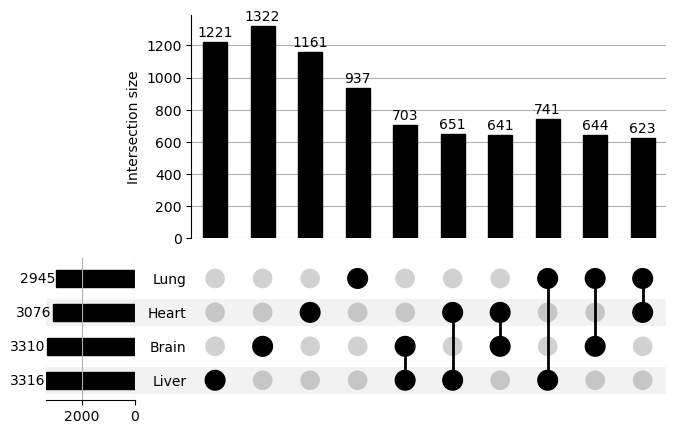

In [172]:
from upsetplot import generate_counts, plot

fig = plt.figure(figsize=(8, 5))
# plot(ess_combined_overlaps, show_counts="%d", element_size=40)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    plot(ess_combined_overlaps, fig=fig, show_counts="%d", element_size=None)
plt.show()

## Annotation by essentiality

In [199]:
# Essential-relatedness
def annotate_essentiality(df, ess_genes_list, indel=False):
    df = df.copy()
    ess_regex = r'(?i)' + '|'.join(ess_genes_list)

    if not indel:
        df[ess_col] = pd.DataFrame(np.vstack([
            df['GenecodeComprehensiveInfo'].str.contains(ess_regex, regex=True),
            df['GenecodeComprehensiveExonicInfo'].str.contains(ess_regex, regex=True),
            df['RefseqInfo'].str.contains(ess_regex, regex=True),
            df['RefseqExonicInfo'].str.contains(ess_regex, regex=True),
            df['Genehancer'].str.contains(ess_regex, regex=True)
            ])).T.any(axis=1, skipna=True)
    else:
        df[ess_col] = pd.DataFrame(np.vstack([
            df[gene_symbol_col].str.contains(ess_regex, regex=True),
            df['SpliceAI_pred_SYMBOL'].str.contains(ess_regex, regex=True)
            ])).T.any(axis=1, skipna=True)
    
    df[del_trans_col] = 0.9 * df[del_col]**6
    # df[del_trans_col] = df[del_col]**4

    # df[deless_col] = df[[ess_col, del_col]].prod(axis=1, min_count=2).astype(float)
    df[deless_col] = df[[ess_col, del_trans_col]].prod(axis=1, min_count=2).astype(float)

    return df


## SNVs

In [218]:
dfs_deless = {}
for t in tissues_full:
    if dfs_del[t].shape[0] != 0:
        if t == 'Liver_LSC': t_ess = 'Liver'
        else: t_ess = t
        dfs_deless[t] = annotate_essentiality(dfs_del[t], ess_genes_list=ess_combined[t_ess], indel=False)
        dfs_deless[t].to_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', compression='gzip')
    else:
        dfs_deless[t] = pd.DataFrame()


## Indels

In [219]:
dfs_deless_indel = {}
for t in tissues_full:
    if dfs_del_indel[t].shape[0] != 0:
        if t == 'Liver_LSC': t_ess = 'Liver'
        else: t_ess = t
        dfs_deless_indel[t] = annotate_essentiality(dfs_del_indel[t], ess_genes_list=ess_combined[t_ess], indel=True)
        dfs_deless_indel[t].to_csv(f'{deless_dir}/{t}_deless_indel.tsv.gz', sep='\t', compression='gzip')
    else:
        dfs_deless_indel[t] = pd.DataFrame()

# df_test_deless = annotate_essentiality(df_test_del, ess_genes_list=ess_combined['Heart'])
# df_test_deless = dfs_deless_indel[t]
# df_test_deless

# FINAL

In [16]:
dfs_deless, dfs_deless_indel = {}, {}

for t in tissues_full:
    try:
        dfs_deless[t] = pd.read_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', index_col=0)
    except FileNotFoundError:
        dfs_deless[t] = pd.DataFrame()
    try:
        dfs_deless_indel[t] = pd.read_csv(f'{deless_dir}/{t}_deless_indel.tsv.gz', sep='\t', index_col=0)
    except FileNotFoundError:
        dfs_deless_indel[t] = pd.DataFrame()


/tmp/ipykernel_650286/1253725906.py:5: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_deless[t] = pd.read_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', index_col=0)
/tmp/ipykernel_650286/1253725906.py:5: DtypeWarning: Columns (21,84) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_deless[t] = pd.read_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', index_col=0)
/tmp/ipykernel_650286/1253725906.py:5: DtypeWarning: Columns (1,21,77,80,81,82,83,84,85,86,87,88,89,90,91,92,101,102,104,108,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_deless[t] = pd.read_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', index_col=0)
/tmp/ipykernel_650286/1253725906.py:5: DtypeWarning: Columns (1,21,84) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs_deless[t] = pd.read_csv(f'{deless_dir}/{t}_deless.tsv.gz', sep='\t', index_col=0)


In [17]:
df_regress = pd.read_csv(f'{processed_dir}/accumulation_rates_modeled.csv', index_col=0)
df_regress

,Slope,CI_low,CI_high,Pval,Intercept
Brain,17.488561,16.112460,18.864662,5.981918e-137,73.699282
Brain_indel,6.925812,5.484467,8.367158,4.605208e-21,-41.082601
Heart,36.368590,19.519484,53.217696,2.331118e-05,97.972560
Heart_indel,14.402674,6.644173,23.603968,1.794622e+111,-54.613390
Liver,52.783359,36.646834,68.919884,1.444378e-10,572.414057
Liver_indel,1.158189,0.721054,1.595323,2.070136e-07,9.208597
Liver_LSC,33.725514,23.415207,44.035820,9.228739e-11,365.739478
Liver_LSC_indel,0.693215,0.431575,0.954855,1.239046e-07,5.511657
Liver_stem_mlm,-16.175931,-83.626545,51.274683,6.383290e-01,1021.476330
Lung,28.518815,20.725173,36.312458,7.392050e-13,648.586246


In [34]:
pd.DataFrame({t: df_regress.loc[t, ['Slope', 'CI_low', 'CI_high']].tolist() for t in tissues_full}).T

,0,1,2
Brain,17.488561,16.112460,18.864662
Heart,36.368590,19.519484,53.217696
Liver,52.783359,36.646834,68.919884
Liver_LSC,33.725514,23.415207,44.035820
Lung,28.518815,20.725173,36.312458


In [38]:
{t: [dfs_deless[t][deless_col].sum()] if dfs_deless[t].shape[0] != 0 else np.nan for t in tissues_full}

{'Brain': np.float64(3.4693817951644674),
 'Heart': np.float64(1.3427090304616218),
 'Liver': np.float64(0.7914062431821933),
 'Liver_LSC': nan,
 'Lung': np.float64(1.1653907736741087)}

In [255]:
lethal_df = pd.DataFrame(
    index=tissues_full
    # columns=['N_lethal', 'p_lethal']
)

lethal_df[['mu_0_snv', 'mu_0_lo_snv', 'mu_0_hi_snv']] = pd.DataFrame({t: df_regress.loc[t, ['Slope', 'CI_low', 'CI_high']].tolist() for t in tissues_full}).T

lethal_df['N_lethal_snv'] = {t: dfs_deless[t][deless_col].sum() if dfs_deless[t].shape[0] != 0 else np.nan for t in tissues_full}
lethal_df['p_lethal_snv'] = {t: lethal_df['N_lethal_snv'][t] / dfs_deless[t].shape[0] for t in tissues_full}

# lethal_df['mu_0_indel'] = {t: df_regress.loc[f'{t}_indel', 'Slope'] for t in tissues_full}
lethal_df[['mu_0_indel', 'mu_0_lo_indel', 'mu_0_hi_indel']] = pd.DataFrame({t: df_regress.loc[f'{t}_indel', ['Slope', 'CI_low', 'CI_high']].tolist() for t in tissues_full}).T

lethal_df['N_lethal_indel'] = {t: dfs_deless_indel[t][deless_col].sum() if dfs_deless_indel[t].shape[0] != 0 else np.nan for t in tissues_full}
lethal_df['p_lethal_indel'] = {t: lethal_df['N_lethal_indel'][t] / dfs_deless_indel[t].shape[0] for t in tissues_full}

# temp
lethal_df.loc['Heart', 'p_lethal_indel'] = lethal_df.loc['Brain', 'p_lethal_indel'].copy()
lethal_df.loc['Liver_LSC', 'p_lethal_snv'] = lethal_df.loc['Liver', 'p_lethal_snv'].copy()

# lethal_df['mu'] = lethal_df[['mu_0_snv', 'p_lethal_snv']].prod(axis=1) + lethal_df[['mu_0_indel', 'p_lethal_indel']].prod(axis=1)

lethal_df.index.name = 'Tissue'
lethal_df

,mu_0_snv,mu_0_lo_snv,mu_0_hi_snv,N_lethal_snv,p_lethal_snv,mu_0_indel,mu_0_lo_indel,mu_0_hi_indel,N_lethal_indel,p_lethal_indel
Tissue,,,,,,,,,,
Brain,17.488561,16.112460,18.864662,3.469382,0.000123,6.925812,5.484467,8.367158,0.115525,3.871495e-05
Heart,36.368590,19.519484,53.217696,1.342709,0.000057,14.402674,6.644173,23.603968,NaN,3.871495e-05
Liver,52.783359,36.646834,68.919884,0.791406,0.000024,1.158189,0.721054,1.595323,0.000911,8.741590e-07
Liver_LSC,33.725514,23.415207,44.035820,NaN,0.000024,0.693215,0.431575,0.954855,0.000006,3.168280e-08
Lung,28.518815,20.725173,36.312458,1.165391,0.000073,2.572529,1.181669,3.963388,0.000003,5.936690e-09


In [272]:
N = 5*10**5

# get SE from CI (normal distribution assumed)
def ci_to_se(lo, hi, ci_lvl=0.95):
    z = st.norm.ppf(1 - (1 - ci_lvl)/2)
    return (hi - lo) / (2 * z)

# build truncated lognormal from median and CI
def p_lethal_trunc_lognormal(median, factor=2, N=500, ci_lvl=0.99):
    z = st.norm.ppf(1 - (1 - ci_lvl)/2)
    mu_log = np.log(median)
    sigma_log = (np.log(median*factor) - np.log(median/factor)) / (2*z)
    samples = np.random.lognormal(mu_log, sigma_log, size=N)
    return np.clip(samples, median/factor, median*factor)

# MC sampling per tissue
def mc_mu(t, p_lethal_sampler_snv, p_lethal_sampler_indel, N=500):
    # mu_0 samples
    se_snv = ci_to_se(t["mu_0_lo_snv"], t["mu_0_hi_snv"])
    se_indel = ci_to_se(t["mu_0_lo_indel"], t["mu_0_hi_indel"])
    snv_samples = np.random.normal(t["mu_0_snv"], se_snv, size=N)
    indel_samples = np.random.normal(t["mu_0_indel"], se_indel, size=N)
    
    # p_lethal samples
    p_snv_samples = p_lethal_sampler_snv(t["p_lethal_snv"], N=N)
    p_indel_samples = p_lethal_sampler_indel(t["p_lethal_indel"], N=N)
    
    # combined mu samples
    mu_samples = snv_samples * p_snv_samples + indel_samples * p_indel_samples
    
    return pd.Series({
        'mu_mc': np.median(mu_samples),  # median for robustness
        'mu_lo': np.percentile(mu_samples, 2.5),
        'mu_hi': np.percentile(mu_samples, 97.5)
    })

lethal_df[['mu_mc', 'mu_lo', 'mu_hi']] = lethal_df.apply(
    lambda t: mc_mu(t, p_lethal_trunc_lognormal, p_lethal_trunc_lognormal, N=N), axis=1)

lethal_df.to_csv(f'{results_dir}/mu_plethal.csv')
lethal_df

,mu_0_snv,mu_0_lo_snv,mu_0_hi_snv,N_lethal_snv,p_lethal_snv,mu_0_indel,mu_0_lo_indel,mu_0_hi_indel,N_lethal_indel,p_lethal_indel,mu_mc,mu_lo,mu_hi
Tissue,,,,,,,,,,,,,
Brain,17.488561,16.112460,18.864662,3.469382,0.000123,6.925812,5.484467,8.367158,0.115525,3.871495e-05,0.002435,0.001528,0.003967
Heart,36.368590,19.519484,53.217696,1.342709,0.000057,14.402674,6.644173,23.603968,NaN,3.871495e-05,0.002615,0.001410,0.004588
Liver,52.783359,36.646834,68.919884,0.791406,0.000024,1.158189,0.721054,1.595323,0.000911,8.741590e-07,0.001243,0.000666,0.002264
Liver_LSC,33.725514,23.415207,44.035820,NaN,0.000024,0.693215,0.431575,0.954855,0.000006,3.168280e-08,0.000793,0.000425,0.001443
Lung,28.518815,20.725173,36.312458,1.165391,0.000073,2.572529,1.181669,3.963388,0.000003,5.936690e-09,0.002077,0.001134,0.003735


In [16]:
df_test_indel = dfs_deless_indel['Brain']
df_test_indel

,CHROM,POS,REF,ALT,CLASS,Location,Consequence,IMPACT,SYMBOL,Gene,...,NCRNA_biotype,NCOTH,NCOTH_biotype,MutScore,CADD_transformed,COMBINED_SCORE,DELETERIOUS,ESSENTIAL_RELATED,DELETERIOUS_TRANSFORMED,DELETERIOUS|ESSENTIAL_RELATED
0,1,1123174,TAA,-,NCRNA,1:1123174-1123177,downstream_gene_variant,MODIFIER,NaN,ENSG00000299943,...,True,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
1,1,2231503,CC,-,NCOTH,1:2231503-2231505,intron_variant,MODIFIER,SKI,ENSG00000157933,...,False,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
2,1,2402615,G,-,NCOTH,1:2402615-2402616,intron_variant,MODIFIER,"PEX10,RER1",ENSG00000157916,...,False,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
3,1,3750949,TAGA,-,NCRNA,1:3750949-3750953,"intron_variant,non_coding_transcript_variant",MODIFIER,"CCDC27,GFOD3P",ENSG00000296834,...,True,True,False,NaN,0.179191,0.179191,NaN,True,NaN,NaN
4,1,7027006,-,ATAA,NCOTH,1:7027006-7027006,intron_variant,MODIFIER,CAMTA1,ENSG00000171735,...,False,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,22,43451318,T,-,NCOTH,22:43451318-43451319,intron_variant,MODIFIER,MPPED1,ENSG00000186732,...,False,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
2980,22,47131083,AACTAAC,-,NCOTH,22:47131083-47131090,intron_variant,MODIFIER,TBC1D22A,ENSG00000054611,...,False,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
2981,22,47226930,ATGA,-,NCRNA,22:47226930-47226934,downstream_gene_variant,MODIFIER,NaN,ENSG00000296742,...,True,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN
2982,22,47469927,-,A,NCRNA,22:47469927-47469927,"intron_variant,non_coding_transcript_variant",MODIFIER,LINC01644,ENSG00000218357,...,True,True,False,NaN,NaN,NaN,NaN,False,NaN,NaN


# LEGACY

3.4693817951644674 0.000123360183301254 0.002157446245755631
236.77327987705087
947.0931195082035


<Axes: >

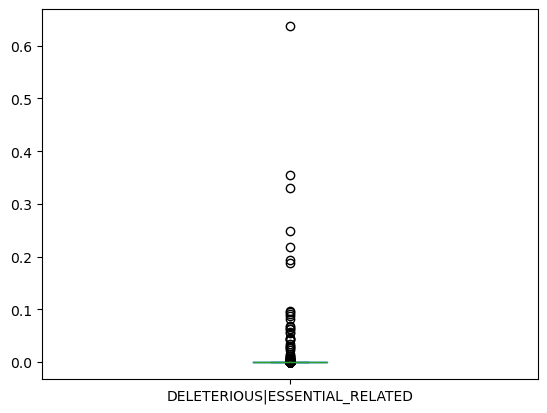

In [19]:
# df_top = data_favor_select['Liver'].copy()
# df_top = data_favor_select['Liver'][data_favor_select['Liver']['CaddPhred'] >= 15].copy()
# print(df_top.shape)

# class_weights = {'CDS':1, 'NCREG':0.75, 'NCRNA':0.5, 'NCOTH':0.25}
# class_weights = {'CDS':1, 'NCREG':0.5, 'NCRNA':0.25, 'NCOTH':0.1}

# def final_score(df):
#     df['FINAL_SCORE'] = df['ess']
#     # ( \
#     #     df['ESSENTIAL_RELATED'].apply(lambda x: 1 if x else 0) * \
#     #     df['CLASS'].apply(lambda x: class_weights[x]) * \
#     #     df[['CLASS', 'MutScore', 'AloftValue']].apply(lambda x: np.mean(x[['MutScore', 'AloftValue']]) if x['CLASS']=='CDS' else 1, axis=1) * \
#     #     df[['CLASS', 'Linsight']].apply(lambda x: x['Linsight']/100 if x['CLASS']!='CDS' else 1, axis=1) * \
#     #     (df[['CaddPhred', 'FathmmXf']]/100).mean(axis=1)
#     #     )

t = 'Brain'
df_deless_test = dfs_deless[t].copy()

N_lethal = df_deless_test[deless_col].sum()
p_lethal = N_lethal / df_deless_test.shape[0]

mu = {'Brain':17.489, 'Heart':36.369, 'Liver':52.783, 'Liver_LSC':33.726, 'Lung':28.519}
thresh = {'Brain':0.60, 'Heart':0.55, 'Liver':0.20, 'Lung':0.23}

print(N_lethal, p_lethal, p_lethal * mu[t])

print(-(np.log(thresh[t])) / (p_lethal * mu[t]))
print(-(np.log(thresh[t])) / (p_lethal/4 * mu[t]))
# print(-(np.log(thresh[organ])) / (p_lethal/10**2 * mu[organ]))

# df_deless_test[deless_col].plot.hist(bins=100)
df_deless_test[deless_col].plot.box()

In [20]:
# df_deless_test[df_deless_test['CLASS'] == 'CDS'][deless_col].plot.box()
df_deless_test[df_deless_test['CLASS'] == 'CDS'][deless_col].sum()

np.float64(3.0598433508331793)

In [275]:
# df_check = df_test_final.set_index(['CHROM', 'POS']).loc[('1', 5434362)]
# df_check = df_test_final.set_index(['CHROM', 'POS']).loc[('1', 5434362)]
# df_check

<Axes: ylabel='COMBINED_SCORE'>

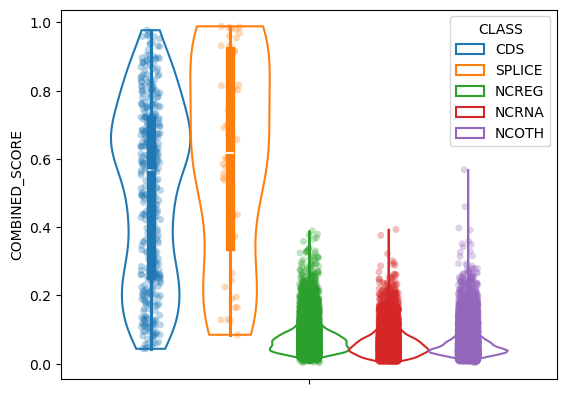

In [27]:
sns.stripplot(df_deless_test, y=combined_score_col, hue='CLASS', hue_order=classes, dodge=True, legend=False, alpha=0.3)
sns.violinplot(df_deless_test, y=combined_score_col, hue='CLASS', hue_order=classes, cut=0, fill=False)

<Axes: ylabel='DELETERIOUS|ESSENTIAL_RELATED'>

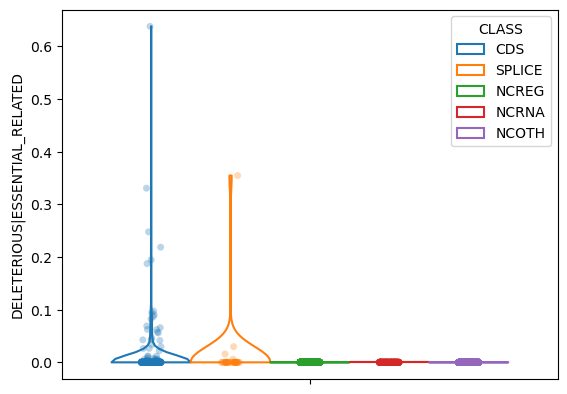

In [28]:
# df_deless_test['DEL'].plot.box()
# sns.scatterplot(df_deless_test, x='DEL', y='')
# sns.boxplot(df_deless_test, x=deless_col, hue='CLASS')
sns.stripplot(df_deless_test, y=deless_col, hue='CLASS', hue_order=classes, dodge=True, legend=False, alpha=0.3)
sns.violinplot(df_deless_test, y=deless_col, hue='CLASS', hue_order=classes, cut=0, fill=False)

(7596, 124) 3.3877617484124505 0.00012045803400698515
283.780168302661


<Axes: ylabel='DELETERIOUS|ESSENTIAL_RELATED'>

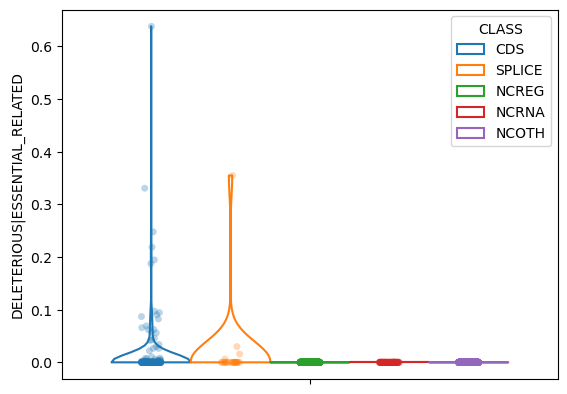

In [29]:
df_top = df_deless_test[df_deless_test['CADD_PHRED'].astype(float) > 5]
p_lethal = df_top[deless_col].sum() / df_deless_test.shape[0]

print(df_top.shape, df_top[deless_col].sum(), p_lethal)
print(-(np.log(0.55)) / (p_lethal * mu[t]))
sns.stripplot(df_top, y=deless_col, hue='CLASS', hue_order=classes, dodge=True, legend=False, alpha=0.3)
sns.violinplot(df_top, y=deless_col, hue='CLASS', hue_order=classes, cut=0, fill=False)

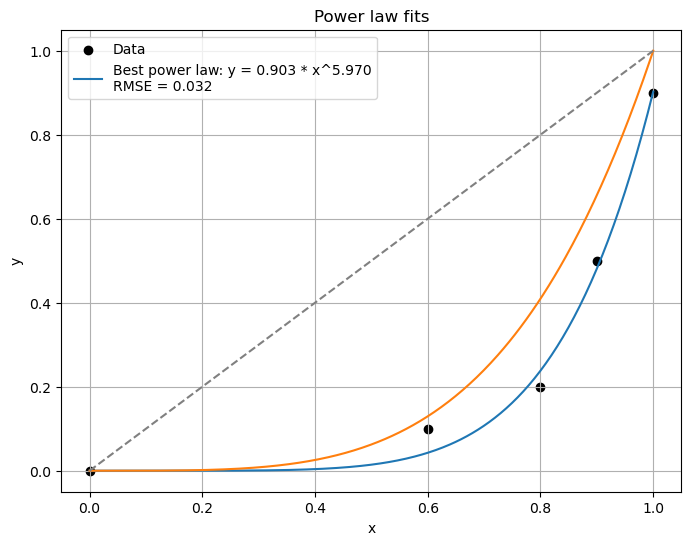

Best fit: a = 0.9026, k = 5.9697, RMSE = 0.0319


In [243]:
from sklearn.metrics import mean_squared_error

# Data including (0,0)
x = np.array([0.0, 0.6, 0.8, 0.9, 1.0])
y = np.array([0.0, 0.1, 0.2, 0.5, 0.9])

# Power law model
def powerlaw(xx, a, k):
    return a * (xx ** k)

# Search range for exponents k
k_values = np.linspace(0.5, 10, 100)
results = {}

for k in k_values:
    mask = x > 0  # exclude x=0 to avoid 0**k in denominator when fitting a
    # Best-fit scaling factor a for this k (least squares)
    a_opt = np.sum((x[mask]**k) * y[mask]) / np.sum((x[mask]**k)**2)
    
    yhat = powerlaw(x, a_opt, k)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    results[k] = (a_opt, rmse)

# Find best fit
best_k = min(results, key=lambda k: results[k][1])
best_a, best_rmse = results[best_k]

# Plot
xx = np.linspace(0, 1, 400)
xx_trans = xx**4

plt.figure(figsize=(8,6))
plt.scatter(x, y, color="black", label="Data")
plt.plot(xx, powerlaw(xx, best_a, best_k),
         label=f"Best power law: y = {best_a:.3f} * x^{best_k:.3f}\nRMSE = {best_rmse:.3f}")
plt.plot(xx, xx_trans)
plt.plot(xx, xx, linestyle='--', c='grey')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Power law fits")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best fit: a = {best_a:.4f}, k = {best_k:.4f}, RMSE = {best_rmse:.4f}")

In [118]:
data_huang_clean

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED
0,1,190911,.,G,A,14.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:25,10:0.75:14:156,105,92,819"
1,1,268833,.,T,A,9.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:23,9:0.609:9:140,95,86,817"
2,1,1016837,.,G,A,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:13,10:0.681:27:154,98,72,426"
3,1,1581817,.,G,A,34.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:19,13:0.561:34:200,128,94,748"
4,1,1735842,.,C,T,16.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:18,9:0.59:16:139,92,76,660"
...,...,...,...,...,...,...,...,...,...,...
15879,X,154928241,.,C,A,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:32,16:0.75:27:247,163,136,1217"
15880,X,154969951,.,A,G,94.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:8,18:0.8:94:274,167,73,279"
15881,X,154993533,.,C,T,25.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:12,10:0.712:25:153,97,72,396"
15882,X,155326630,.,A,G,27.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:20,12:0.568:27:185,120,93,720"


In [133]:
data_huang_clean[data_huang_clean.duplicated(['#CHROM', 'POS', 'REF', 'ALT'], keep=False)]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE_INFO_FORMATTED
23,1,5035060,.,G,A,39.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:38,20:0.692:39:307,202,163,1432"
24,1,5035060,.,G,A,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:8,33:0.853:150:503,303,89,309"
28,1,5434362,.,G,A,95.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:5,16:0.669:95:244,147,52,191"
29,1,5434362,.,G,A,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:37,42:0.576:150:643,401,239,1375"
38,1,7237626,.,C,A,30.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:18,12:0.652:30:185,119,89,664"
...,...,...,...,...,...,...,...,...,...,...
15867,X,150313022,.,G,A,10.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:17,7:0.732:10:109,73,63,595"
15872,X,152779483,.,G,A,3.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:3,30:1.0:3:456,273,135,135"
15873,X,152779483,.,G,A,12.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:14,7:0.75:12:108,71,60,504"
15874,X,152852782,.,T,G,150.0,.,NS=1,GT:SO:AD:BI:GQ:PL,"0/1:True:24,40:0.583:150:610,375,185,908"


In [ ]:
# df_lung_vep = pd.read_csv(f'{processed_dir}/vep/2022huang_vep.txt', sep='\t')
# df_lung_vep

In [119]:
# df_brain_vep = data_luquette_vep.copy()
# df_brain_vep[['CHROM', 'POS']] = df_brain_vep['Location'].str.split(':', expand=True)
# df_brain_vep['POS'] = df_brain_vep['POS'].str.split('-', expand=True)[0]
# df_brain_vep['REF'] = df_brain_vep['REF_ALLELE']
# df_brain_vep['ALT'] = df_brain_vep['Allele']
# df_brain_vep

# # df_brain_vep['CLASS'] = df_brain_vep.apply(lambda x: 
# #     'CDS' if x['Consequence'].contains(['missense_variant', 'synonymous_variant', 'stop_gained', 'start_lost', 'stop_retained_variant']) #else 
# #     # 'SPLICE' if x['Consequence'].contains(['']) else
# #     # 'NCREG' if x['Consequence'] in 
# #     #     ['3_prime_UTR_variant', '5_prime_UTR_variant'] else 
# #     # 'NCRNA' if x['Consequence'] in ['ncRNA_exonic', 'ncRNA_intronic'] 
# #     else 'NCOTH', 
# #     axis=1 )

# for region in consequences:
#     df_brain_vep[region] = df_brain_vep['Consequence'].str.contains('|'.join(consequences[region]), case=False, na=False)
#     df_brain_vep[f'{region}_biotype'] = df_brain_vep['BIOTYPE'].str.contains('|'.join(biotypes[region]), case=False, na=False)

# df_brain_vep[['CDS', 'SPLICE', 'NCREG', 'NCRNA', 'NCOTH']].value_counts()
# df_brain_vep[['CDS', 'CDS_biotype', 'SPLICE', 'NCREG', 'NCREG_biotype', 'NCRNA', 'NCRNA_biotype', 'NCOTH', 'NCOTH_biotype']].value_counts()

# df_brain_vep['CLASS'] = df_brain_vep.apply(lambda x:
#     'CDS' if x['CDS'] == True else
#     'SPLICE' if (x['SPLICE'] == True) and (x['NCRNA_biotype'] == False) else
#     'NCREG' if (x['NCREG'] == True) or (x['NCREG_biotype'] == True) else
#     'NCRNA' if (x['NCRNA_biotype'] == True) else
#     'NCOTH',
#     axis=1
# )
# df_brain_vep['CLASS'].value_counts()

In [4]:
data_miller_vep = pd.read_csv(f'{processed_dir}/2022miller_ann_vep.tsv.gz', sep='\t')
data_miller_vep = data_miller_vep.replace('-', np.nan).dropna(how='all', axis=1)
data_miller_vep

,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,RiboseqORFs_CDS_position,RiboseqORFs_amino_acids,RiboseqORFs_cDNA_position,RiboseqORFs_codons,RiboseqORFs_consequences,RiboseqORFs_id,RiboseqORFs_impact,RiboseqORFs_protein_position,RiboseqORFs_publications,GO
0,.,1:25878122-25878122,A,downstream_gene_variant,MODIFIER,Y_RNA,ENSG00000207302,Transcript,ENST00000384572.1,misc_RNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.,1:25878122-25878122,A,upstream_gene_variant,MODIFIER,PAQR7,ENSG00000182749,Transcript,ENST00000675840.1,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GO:0016020:membrane
2,.,1:25878122-25878122,A,upstream_gene_variant,MODIFIER,PAQR7,164091,Transcript,NM_178422.6,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,.,1:25878122-25878122,A,upstream_gene_variant,MODIFIER,PAQR7,164091,Transcript,XM_005245746.4,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,.,1:25878122-25878122,A,upstream_gene_variant,MODIFIER,PAQR7,164091,Transcript,XM_011540862.3,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214495,.,9:137754950-137754950,T,intron_variant,MODIFIER,EHMT1,79813,Transcript,XM_047423885.1,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214496,.,9:137754950-137754950,T,intron_variant,MODIFIER,EHMT1,79813,Transcript,XM_047423886.1,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214497,.,9:137754950-137754950,T,intron_variant,MODIFIER,EHMT1,79813,Transcript,XM_047423887.1,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214498,.,9:137754950-137754950,T,intron_variant,MODIFIER,EHMT1,79813,Transcript,XM_047423888.1,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
set([x for xs in data_miller_vep['Consequence'].unique().tolist() for x in xs.split(',')])

{'3_prime_UTR_variant',
 '5_prime_UTR_variant',
 'NMD_transcript_variant',
 'downstream_gene_variant',
 'intergenic_variant',
 'intron_variant',
 'missense_variant',
 'non_coding_transcript_exon_variant',
 'non_coding_transcript_variant',
 'regulatory_region_variant',
 'splice_acceptor_variant',
 'splice_donor_5th_base_variant',
 'splice_donor_region_variant',
 'splice_donor_variant',
 'splice_polypyrimidine_tract_variant',
 'splice_region_variant',
 'start_lost',
 'stop_gained',
 'stop_lost',
 'synonymous_variant',
 'upstream_gene_variant'}

<Axes: ylabel='Frequency'>

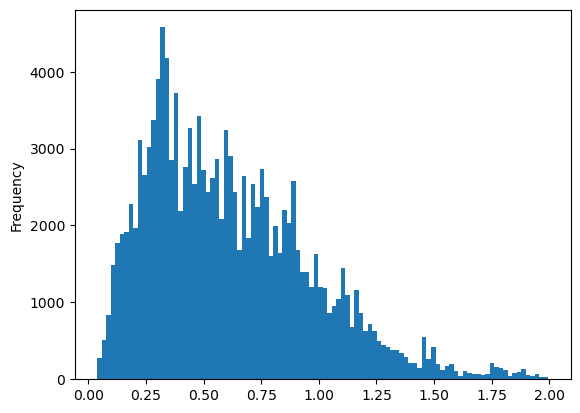

In [43]:
data_miller_vep['LOEUF'].astype(float).plot.hist(bins=100)

In [68]:
data_miller_vep['SYMBOL'].value_counts(dropna=False)

SYMBOL
-               23154
MIR99AHG         1264
DLG2              901
PTPRD             889
LINC-PINT         841
                ...  
LOC150935           1
LOC124901138        1
LOC105377739        1
NIFKP2              1
RN7SKP70            1
Name: count, Length: 9708, dtype: int64

<Axes: ylabel='Frequency'>

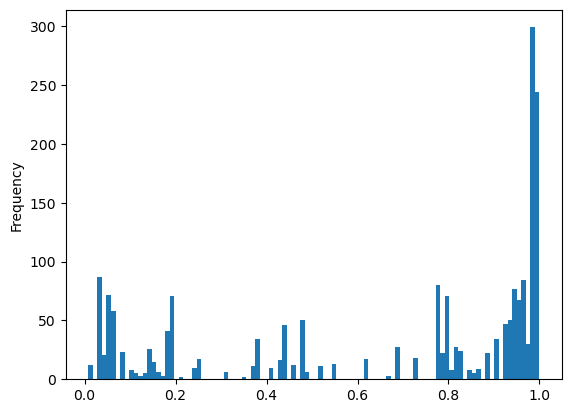

In [66]:
data_miller_vep['ClinPred'].replace('-', np.nan).astype(float).plot.hist(bins=100)


<Axes: ylabel='Frequency'>

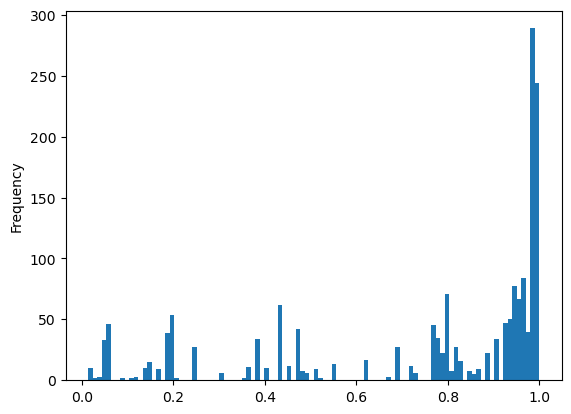

In [67]:
data_miller_vep[data_miller_vep['CADD_PHRED'] >= 10]['ClinPred'].replace('-', np.nan).astype(float).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

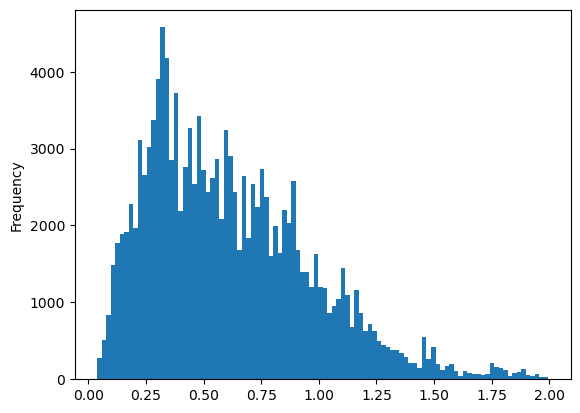

In [190]:
data_miller_vep['LOEUF'].replace('-', np.nan).astype(float).plot.hist(bins=100)

<Axes: ylabel='Frequency'>

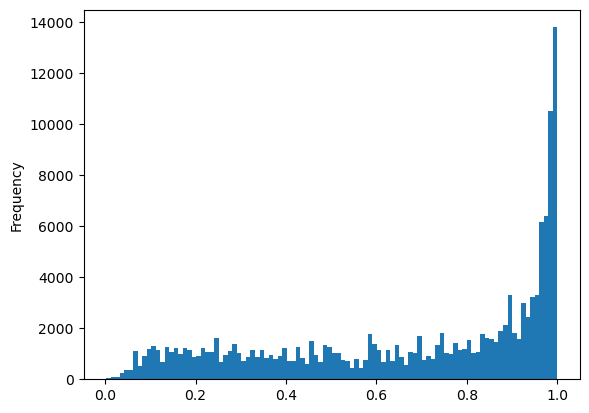

In [191]:
data_miller_vep['pHaplo'].replace('-', np.nan).astype(float).plot.hist(bins=100)


## SomaMutDB annotation

In [58]:
weeks_to_years = 1/52.17857

somamutdb_dir = f'{datasets_dir}/somamutdb'
somamutdb_brain = pd.read_csv(f'{somamutdb_dir}/somamutdb_brain.tsv', sep='\t', dtype={'age':'str', 'cadd_phred':'str'})
somamutdb_brain = somamutdb_brain.replace('.', np.nan)

somamutdb_brain['age'] = somamutdb_brain['age'].apply(lambda x: float(x.strip('W')) * weeks_to_years if x.endswith('W') else x).astype(float)
somamutdb_brain['cadd_phred'] = somamutdb_brain['cadd_phred'].replace('1(kidney)', 1.0).astype(float)

somamutdb_brain

,#chr,pos,ref,alt,tissue,tissue_detail,sex,age,gene_id,gbiotype,...,LIST_S2_rankscore,LIST_S2_score,M_CAP_rankscore,M_CAP_score,MPC_rankscore,MPC_score,MVP_rankscore,MVP_score,metaRNN_rankscore,metaRNN_score
0,chr1,2913619,C,T,Brain,Prefrontal cortex,Female,76.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,36562624,T,C,Brain,Prefrontal cortex,Female,76.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,68872405,T,G,Brain,Prefrontal cortex,Female,76.0,ENSG00000285407,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,111356313,G,T,Brain,Prefrontal cortex,Female,76.0,ENSG00000234020,unprocessed_pseudogene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,153196458,T,C,Brain,Prefrontal cortex,Female,76.0,ENSG00000229699,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98854,chr21,44600016,G,A,Brain,Prefrontal cortex,Male,20.0,ENSG00000175894,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98855,chr21,46130892,G,A,Brain,Prefrontal cortex,Male,20.0,ENSG00000142173,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98856,chr22,21762810,C,A,Brain,Prefrontal cortex,Male,20.0,ENSG00000100030,protein_coding,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98857,chrX,100000813,G,T,Brain,Prefrontal cortex,Male,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
somamutdb_brain.columns

Index(['#chr', 'pos', 'ref', 'alt', 'tissue', 'tissue_detail', 'sex', 'age',
       'gene_id', 'gbiotype', 'symbol', 'strand', 'feature',
       'distance_upstream_downstream', 'sift', 'polyphen', 'cadd_phred',
       'regulatory_id', 'regulatory_type', 'AlphaMissense_rankscore',
       'AlphaMissense_score', 'EVE_score', 'EVE_rankscore', 'FATHMM_MKL_C',
       'FATHMM_MKL_NC', 'PrimateAI_score', 'PrimateAI_rankscore',
       'REVEL_rankscore', 'REVEL_score', 'Enformer_SAD', 'Enformer_SAR',
       'BayesDel_addAF_pred', 'BayesDel_addAF_rankscore',
       'BayesDel_addAF_score', 'BayesDel_noAF_pred', 'BayesDel_noAF_rankscore',
       'BayesDel_noAF_score', 'DANN_rankscore', 'DANN_score',
       'DEOGEN2_rankscore', 'DEOGEN2_score', 'Eigen_PC_raw_coding',
       'Eigen_PC_raw_coding_rankscore', 'Eigen_phred_coding',
       'Eigen_raw_coding', 'Eigen_raw_coding_rankscore',
       'GenoCanyon_rankscore', 'GenoCanyon_score', 'LIST_S2_rankscore',
       'LIST_S2_score', 'M_CAP_rankscore', 'M

In [74]:
data_miller = pd.read_csv(f'{processed_dir}/data_2022miller.tsv.gz', sep='\t', index_col=None, header=None)
data_miller.columns = cols_short
data_miller['CHROM'] = 'chr' + data_miller['CHROM'].astype(str)
data_miller

,CHROM,POS,REF,ALT,SAMPLE_ID
0,chr1,917882,C,G,5657PFC-B
1,chr1,995442,A,G,UMB5451_B3
2,chr1,1133467,C,T,5087PFC-B
3,chr1,1279892,A,T,UMB5943_C5
4,chr1,2090048,T,G,5823PFC-A
...,...,...,...,...,...
15916,chr22,49785259,C,A,5823PFC-A
15917,chr22,49834396,C,G,UMB4976_E2
15918,chr22,50123599,A,G,UMB5451_B3
15919,chr22,50178561,C,T,UMB5943_C2


In [80]:
data_miller_ann = data_miller.merge(somamutdb_brain, left_on=['CHROM', 'POS', 'REF', 'ALT'], right_on=['#chr', 'pos', 'ref', 'alt'])
data_miller_ann.drop(['#chr', 'pos', 'ref', 'alt', 'tissue', 'tissue_detail', 'sex', 'age'], axis=1, inplace=True)
data_miller_ann.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], inplace=True)
# data_miller_ann.dropna(axis=1, how='all')
data_miller_ann

,CHROM,POS,REF,ALT,SAMPLE_ID,gene_id,gbiotype,symbol,strand,feature,...,LIST_S2_rankscore,LIST_S2_score,M_CAP_rankscore,M_CAP_score,MPC_rankscore,MPC_score,MVP_rankscore,MVP_score,metaRNN_rankscore,metaRNN_score
0,chr1,917882,C,G,5657PFC-B,ENSG00000223764,lncRNA,LINC02593,-,non_coding_transcript_exon_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,995442,A,G,UMB5451_B3,ENSG00000188290,protein_coding,HES4,-,downstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,1133467,C,T,5087PFC-B,ENSG00000223823,lncRNA,LINC01342,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,1279892,A,T,UMB5943_C5,ENSG00000230415,lncRNA,LINC01786,+,"intron_variant,non_coding_transcript_variant",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,2090048,T,G,5823PFC-A,ENSG00000067606,protein_coding,PRKCZ,+,intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15975,chr22,49785259,C,A,5823PFC-A,ENSG00000100425,protein_coding,BRD1,-,intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15976,chr22,49834396,C,G,UMB4976_E2,ENSG00000260613,lncRNA,Z98885.2,-,"intron_variant,non_coding_transcript_variant",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15977,chr22,50123599,A,G,UMB5451_B3,ENSG00000073146,protein_coding,MOV10L1,+,intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15978,chr22,50178561,C,T,UMB5943_C2,ENSG00000073150,protein_coding,PANX2,+,intron_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
data_miller_ann.to_csv(f'{processed_dir}/data_2022miller_ann_somamutdb.tsv.gz', sep='\t', index=None)

In [81]:
data_miller_ann.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'SAMPLE_ID', 'gene_id', 'gbiotype',
       'symbol', 'strand', 'feature', 'distance_upstream_downstream', 'sift',
       'polyphen', 'cadd_phred', 'regulatory_id', 'regulatory_type',
       'AlphaMissense_rankscore', 'AlphaMissense_score', 'EVE_score',
       'EVE_rankscore', 'FATHMM_MKL_C', 'FATHMM_MKL_NC', 'PrimateAI_score',
       'PrimateAI_rankscore', 'REVEL_rankscore', 'REVEL_score', 'Enformer_SAD',
       'Enformer_SAR', 'BayesDel_addAF_pred', 'BayesDel_addAF_rankscore',
       'BayesDel_addAF_score', 'BayesDel_noAF_pred', 'BayesDel_noAF_rankscore',
       'BayesDel_noAF_score', 'DANN_rankscore', 'DANN_score',
       'DEOGEN2_rankscore', 'DEOGEN2_score', 'Eigen_PC_raw_coding',
       'Eigen_PC_raw_coding_rankscore', 'Eigen_phred_coding',
       'Eigen_raw_coding', 'Eigen_raw_coding_rankscore',
       'GenoCanyon_rankscore', 'GenoCanyon_score', 'LIST_S2_rankscore',
       'LIST_S2_score', 'M_CAP_rankscore', 'M_CAP_score', 'MPC_rankscore',
    

In [16]:
data_miller_ann['gbiotype'].value_counts(dropna=False)

gbiotype
protein_coding                        8255
NaN                                   4471
lncRNA                                2599
processed_pseudogene                   234
transcribed_unprocessed_pseudogene     100
unprocessed_pseudogene                  76
transcribed_processed_pseudogene        37
misc_RNA                                33
transcribed_unitary_pseudogene          32
snRNA                                   23
TEC                                     21
IG_V_gene                                8
unitary_pseudogene                       6
snoRNA                                   6
miRNA                                    5
rRNA_pseudogene                          4
polymorphic_pseudogene                   3
IG_V_pseudogene                          3
scaRNA                                   2
TR_V_pseudogene                          1
IG_C_pseudogene                          1
ribozyme                                 1
Name: count, dtype: int64

In [17]:
data_miller_ann['gbiotype'].unique()

array(['protein_coding', 'lncRNA', nan,
       'transcribed_unprocessed_pseudogene', 'unprocessed_pseudogene',
       'processed_pseudogene', 'snoRNA', 'IG_V_gene',
       'unitary_pseudogene', 'polymorphic_pseudogene', 'misc_RNA', 'TEC',
       'transcribed_processed_pseudogene', 'snRNA',
       'transcribed_unitary_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'TR_V_pseudogene', 'IG_C_pseudogene', 'scaRNA', 'IG_V_pseudogene',
       'ribozyme'], dtype=object)

In [21]:
data_miller_ann['feature'].value_counts(dropna=False)

feature
intron_variant                                                        6922
NaN                                                                   4471
intron_variant,non_coding_transcript_variant                          2373
upstream_gene_variant                                                  649
downstream_gene_variant                                                512
non_coding_transcript_exon_variant                                     370
3_prime_UTR_variant                                                    233
missense_variant                                                       147
intron_variant,NMD_transcript_variant                                   76
synonymous_variant                                                      69
5_prime_UTR_variant                                                     47
3_prime_UTR_variant,NMD_transcript_variant                              14
splice_region_variant,intron_variant                                     7
missense_variant,

In [18]:
data_miller_ann['feature'].unique()

array(['intron_variant', 'upstream_gene_variant',
       'intron_variant,non_coding_transcript_variant', nan,
       'non_coding_transcript_exon_variant', 'downstream_gene_variant',
       '3_prime_UTR_variant', 'missense_variant', 'synonymous_variant',
       'splice_acceptor_variant', 'intron_variant,NMD_transcript_variant',
       '5_prime_UTR_variant', 'stop_gained,splice_region_variant',
       'splice_region_variant,intron_variant',
       '3_prime_UTR_variant,NMD_transcript_variant',
       'missense_variant,splice_region_variant',
       'splice_region_variant,intron_variant,non_coding_transcript_variant',
       'start_lost', 'splice_donor_variant',
       'splice_region_variant,non_coding_transcript_exon_variant',
       'missense_variant,NMD_transcript_variant', 'stop_gained',
       'splice_region_variant,synonymous_variant',
       'splice_acceptor_variant,non_coding_transcript_variant',
       'splice_region_variant,3_prime_UTR_variant'], dtype=object)

In [20]:
data_miller_ann['regulatory_type'].value_counts(dropna=False)

regulatory_type
NaN                                            12701
promoter_flanking_region                        1577
enhancer                                         491
promoter                                         392
CTCF_binding_site                                319
open_chromatin_region                            207
CTCF_binding_site, promoter_flanking_region       67
TF_binding_site                                   34
promoter, CTCF_binding_site                       31
promoter_flanking_region, CTCF_binding_site       30
CTCF_binding_site, TF_binding_site                20
CTCF_binding_site, enhancer                       20
CTCF_binding_site, open_chromatin_region          11
TF_binding_site, CTCF_binding_site                 8
enhancer, CTCF_binding_site                        6
CTCF_binding_site, promoter                        5
open_chromatin_region, CTCF_binding_site           2
Name: count, dtype: int64

In [19]:
data_miller_ann['regulatory_type'].unique()

array([nan, 'promoter_flanking_region', 'enhancer', 'CTCF_binding_site',
       'promoter', 'CTCF_binding_site, promoter_flanking_region',
       'open_chromatin_region', 'promoter, CTCF_binding_site',
       'promoter_flanking_region, CTCF_binding_site',
       'open_chromatin_region, CTCF_binding_site',
       'CTCF_binding_site, TF_binding_site', 'TF_binding_site',
       'CTCF_binding_site, open_chromatin_region',
       'TF_binding_site, CTCF_binding_site',
       'enhancer, CTCF_binding_site', 'CTCF_binding_site, enhancer',
       'CTCF_binding_site, promoter'], dtype=object)

In [272]:
print((data_miller_ann['cadd_phred'] >= 10).sum())
print((data_miller_ann['cadd_phred'] >= 10).sum() / data_miller_ann['cadd_phred'].dropna().shape[0] * 100)


1387
8.715596330275229


In [164]:
data_miller = pd.read_csv(f'{processed_dir}/data_2022miller.tsv.gz', sep='\t', index_col=None)
data_miller

,#CHROM,POS,REF,ALT,SAMPLE_ID
0,1,42200916,T,C,1278BA9-A
1,1,210881251,C,T,1278BA9-A
2,2,3523792,C,A,1278BA9-A
3,2,43120623,G,A,1278BA9-A
4,2,57959584,G,T,1278BA9-A
...,...,...,...,...,...
15998,22,30788410,T,C,UMB5943_C5
15999,22,31896288,T,C,UMB5943_C5
16000,22,40313963,G,T,UMB5943_C5
16001,22,48144357,C,T,UMB5943_C5


## CLASSIFICATION

In [11]:
classes = ['CDS', 'NCREG', 'NCRNA', 'NCOTH']

In [7]:
data_neurons_favor = pd.read_csv(f'{processed_dir}/data_neurons_favor.tsv.gz', sep='\t', index_col=None)
data_heart_favor = pd.read_csv(f'{processed_dir}/data_heart_favor.tsv.gz', sep='\t', index_col=None)
data_neurons_favor

/tmp/ipykernel_1694895/475318078.py:1: DtypeWarning: Columns (38,50,54,58,62,66,324) have mixed types. Specify dtype option on import or set low_memory=False.
  data_neurons_favor = pd.read_csv(f'{processed_dir}/data_neurons_favor.tsv.gz', sep='\t', index_col=None)
/tmp/ipykernel_1694895/475318078.py:2: DtypeWarning: Columns (38,50,54,58,62,66,324) have mixed types. Specify dtype option on import or set low_memory=False.
  data_heart_favor = pd.read_csv(f'{processed_dir}/data_heart_favor.tsv.gz', sep='\t', index_col=None)


,VariantVcf.String,VariantVcf.Valid,Chromosome.String,Chromosome.Valid,Position.String,Position.Valid,BravoAn.Int32,BravoAn.Valid,BravoAc.Int32,BravoAc.Valid,...,Nucdiv.Float64,Nucdiv.Valid,AloftValue.String,AloftValue.Valid,AloftDescription.String,AloftDescription.Valid,FunseqValue.String,FunseqValue.Valid,FunseqDescription.String,FunseqDescription.Valid
0,1-917882-C-G,True,1,True,917882,True,0,False,0,False,...,5.80,True,NaN,False,NaN,False,NaN,False,noncoding,True
1,1-917882-C-G,True,1,True,917882,True,0,False,0,False,...,5.80,True,NaN,False,NaN,False,NaN,False,noncoding,True
2,1-917882-C-G,True,1,True,917882,True,0,False,0,False,...,5.80,True,NaN,False,NaN,False,NaN,False,noncoding,True
3,1-983862-C-T,True,1,True,983862,True,0,False,0,False,...,5.00,True,NaN,False,NaN,False,NaN,False,noncoding,True
4,1-995442-A-G,True,1,True,995442,True,0,False,0,False,...,5.20,True,NaN,False,NaN,False,NaN,False,noncoding,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,22-50425306-C-T,True,22,True,50425306,True,0,False,0,False,...,5.15,True,NaN,False,NaN,False,NaN,False,noncoding,True
99303,22-50425306-C-T,True,22,True,50425306,True,0,False,0,False,...,5.15,True,NaN,False,NaN,False,NaN,False,noncoding,True
99304,22-50477706-C-T,True,22,True,50477706,True,264690,True,6,True,...,4.10,True,NaN,False,NaN,False,NaN,False,noncoding,True
99305,22-50658460-C-T,True,22,True,50658460,True,264690,True,12,True,...,3.60,True,NaN,False,NaN,False,NaN,False,noncoding,True


In [8]:
data_heart_favor

,VariantVcf.String,VariantVcf.Valid,Chromosome.String,Chromosome.Valid,Position.String,Position.Valid,BravoAn.Int32,BravoAn.Valid,BravoAc.Int32,BravoAc.Valid,...,Nucdiv.Float64,Nucdiv.Valid,AloftValue.String,AloftValue.Valid,AloftDescription.String,AloftDescription.Valid,FunseqValue.String,FunseqValue.Valid,FunseqDescription.String,FunseqDescription.Valid
0,1-100446161-G-A,True,1,True,100446161,True,264690,True,7,True,...,2.35,True,NaN,False,NaN,False,NaN,False,noncoding,True
1,1-100486042-G-C,True,1,True,100486042,True,0,False,0,False,...,1.60,True,NaN,False,NaN,False,NaN,False,noncoding,True
2,1-100486042-G-C,True,1,True,100486042,True,0,False,0,False,...,1.60,True,NaN,False,NaN,False,NaN,False,noncoding,True
3,1-100515223-C-T,True,1,True,100515223,True,0,False,0,False,...,2.20,True,NaN,False,NaN,False,NaN,False,noncoding,True
4,1-100603983-C-T,True,1,True,100603983,True,264690,True,1,True,...,3.20,True,NaN,False,NaN,False,NaN,False,noncoding,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26358,9-99621999-C-T,True,9,True,99621999,True,0,False,0,False,...,1.90,True,NaN,False,NaN,False,NaN,False,noncoding,True
26359,9-99636680-T-G,True,9,True,99636680,True,0,False,0,False,...,2.05,True,NaN,False,NaN,False,NaN,False,noncoding,True
26360,9-99646097-C-A,True,9,True,99646097,True,0,False,0,False,...,1.70,True,NaN,False,NaN,False,NaN,False,noncoding,True
26361,9-99714963-T-G,True,9,True,99714963,True,0,False,0,False,...,1.35,True,NaN,False,NaN,False,NaN,False,noncoding,True


In [244]:
# data_miller_favor = pd.read_csv(f'{processed_dir}/2022miller_ann_favor.tsv.gz', sep='\t', index_col=None, dtype={38:str, 50:str, 54:str, 58:str, 62:str, 66:str})
# data_miller_favor.columns.tolist()

In [12]:
favor_cols_selected = [
    'VariantVcf.String', 'Chromosome.String', 'Position.String',
    'Rsid.String',

    # genomic regions
    'GenecodeComprehensiveCategory.String', # regions
    'GenecodeComprehensiveInfo.String', 'UcscInfo.String', 'RefseqInfo.String', # genes
    'GenecodeComprehensiveExonicCategory.String', # syn/non-syn/stop
    'GenecodeComprehensiveExonicInfo.String', 'UcscExonicInfo.String', 'RefseqExonicInfo.String', # exons
    'CagePromoter.String', 'CagePromoter.Valid', # promoters
    'CageEnhancer.String', 'CageEnhancer.Valid', 'Genehancer.String', 'Genehancer.Valid', 'SuperEnhancer.String', 'SuperEnhancer.Valid', # enhancers
    
    # high-coverage scores
    'CaddPhred.Float64', 'CaddRawscore.Float64', 'Linsight.Float64', 'FathmmXf.Float64', 
    
    # low-coverage scores
    # 'Polyphen2HdivScore.Float64', 'Polyphen2HvarScore.Float64', 'MutationTasterScore.Float64', 'MutationAssessorScore.Float64', 'MetasvmPred.String',
    # 'SiftCat.String', 'SiftVal.Float64', 'PolyphenCat.String', 'PolyphenVal.Float64', 'Grantham.Float64',
    'AloftValue.String', 'AloftDescription.String', # recessive/dominant/benign; putative LoF variants in protein-coding genes
    'FunseqValue.String', 'FunseqDescription.String', # coding/noncoding; regulatory mutations from cancer genome sequencing

    # genomic details
    'Origin.String',
    'Gc.Float64', 'Cpg.Float64', # Percent in +/- 75bp
    'MinDistTss.Int32', 'MinDistTse.Int32',

    # aPCs are in PHRED scale [0,100]
    'ApcProteinFunctionV3.Float64', # low-coverage scores: SIFTval, PolyPhenVal, Grantham, Polyphen2_HDIV_score, Polyphen2_HVAR_score, MutationTaster_score, MutationAssessor_score
    'ApcConservationV2.Float64', # GerpN, GerpS, priPhCons, mamPhCons, verPhCons, priPhyloP, mamPhyloP, verPhyloP
    'ApcEpigeneticsActive.Float64', # EncodeH3K4me1.max, EncodeH3K4me2.max, EncodeH3K4me3.max, EncodeH3K9ac.max, EncodeH3K27ac.max, EncodeH4K20me1.max，EncodeH2AFZ.max
    'ApcEpigeneticsRepressed.Float64', # EncodeH3K9me3.max, EncodeH3K27me3.max
    'ApcEpigeneticsTranscription.Float64', # EncodeH3K36me3.max, EncodeH3K79me2.max
    'ApcTranscriptionFactor.Float64', # RemapOverlapTF, RemapOverlapCL - number of binding TFs/cell-line combinations 
    'ApcLocalNucleotideDiversityV3.Float64', # bStatistic, RecombinationRate, NuclearDiversity
    'ApcMappability.Float64', # umap_k100, bismap_k100, umap_k50, bismap_k50, umap_k36, bismap_k36, umap_k24, bismap_k24
    'ApcMutationDensity.Float64', # Common100bp, Rare100bp, Sngl100bp, Common1000bp, Rare1000bp, Sngl1000bp, Common10000bp, Rare10000bp, Sngl10000bp

    'EncodeDnaseSum.Float64', 'EncodetotalRnaSum.Float64', # other Encodes
    'TgAll.Float64', 'AfTotal.Float64', 'AfFemale.Float64', 'AfMale.Float64', # genome allele frequencies
]

In [10]:
# data_neurons_favor['GenecodeComprehensiveExonicInfo.String'].value_counts(dropna=False)
# data_neurons_favor['ApcProteinFunctionV3.Float64'].value_counts(dropna=False)
# data_neurons_favor['ApcProteinFunctionV3.Float64'].plot.hist(bins=1000)
# data_neurons_favor['MinDistTss.Int32'].plot.hist(bins=1000)

GenecodeComprehensiveExonicInfo.String
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Essentialomes

In [138]:
ess = {}
lfc_thresh = 0
pval_thresh = 0.1

# Mouse to human gene names liftover
bm = Biomart()
m2h_df = bm.query(
    dataset='mmusculus_gene_ensembl',
    attributes=['ensembl_gene_id','external_gene_name',
                'hsapiens_homolog_ensembl_gene',
                'hsapiens_homolog_associated_gene_name'])

def m2h(mouse_gene_list, m2h_df=m2h_df):
    input_regex = '|'.join([f'^{g}$' for g in mouse_gene_list])

    m2h_df = m2h_df.dropna(subset='external_gene_name').copy()
    m2h_df = m2h_df[m2h_df['external_gene_name'].str.contains(input_regex, regex=True)] \
        .dropna(subset='hsapiens_homolog_associated_gene_name')
    
    return m2h_df['hsapiens_homolog_associated_gene_name'].sort_values().unique().tolist()

In [139]:
# Brain

ess_brain_wertz = pd.read_excel(
    f'{essentialomes_dir}/essential_brain_wertz.xlsx', sheet_name=['WTEssential_shRNA_Screen_DrugZ', 'WTEssential_CRISPR_Screen_DrugZ'], skiprows=1)

/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


<Axes: xlabel='wt_normZ', ylabel='Count'>

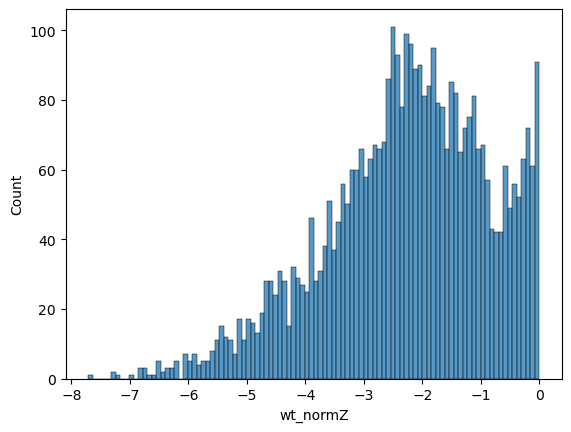

In [140]:
sns.histplot(ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ'], x='wt_normZ', bins=100)

In [141]:
# def local_min(array, range, bins=10**3):
#     counts, edges = np.histogram(array, bins=bins)
#     centers = (edges[:-1] + edges[1:]) / 2

#     # Smooth lightly to remove noise
#     smooth = np.convolve(counts, np.ones(3)/3, mode='same')

#     # Identify local minima in the smoothed curve
#     is_min = (smooth[1:-1] < smooth[:-2]) & (smooth[1:-1] < smooth[2:])
#     minima_idxs = np.where(is_min)[0] + 1  # shift back to full-array indices

#     # Restrict to the region range[0] ≤ center ≤ range[1]
#     mask = (centers[minima_idxs] >= range[0]) & (centers[minima_idxs] <= range[1])
#     candidates = minima_idxs[mask]

#     # Pick the deepest of those minima
#     i = candidates[np.argmin(smooth[candidates])]

#     # 6. Parabolic interpolation around bin i
#     x0, x1, x2 = centers[i-1], centers[i], centers[i+1]
#     y0, y1, y2 = counts[i-1], counts[i], counts[i+1]
#     delta = (y0 - y2) / (2*(y0 - 2*y1 + y2))
#     refined_min = x1 + delta * (x2 - x1)

#     return refined_min

# lfc_thresh_wertz = local_min(ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ']['wt_normZ'], range=[-2,0]).round(3)
# lfc_thresh_wertz

In [142]:
# ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ'] = ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ'][ess_brain_wertz['WTEssential_shRNA_Screen_DrugZ']['wt_normZ'] < lfc_thresh_wertz]
# ess_brain_wertz = pd.concat(ess_brain_wertz.values()).reset_index(drop=True)
ess_brain_wertz = ess_brain_wertz['WTEssential_CRISPR_Screen_DrugZ'].copy()

ess_brain_ramani = pd.read_excel(
    f'{essentialomes_dir}/essential_brain_ramani.xlsx', 
    sheet_name=['M1+M3 hsyn_Fig 3', 'M1_CaMKII_Fig4', 'M1_hI56i_Fig5', 
                'M1_hsyn_allsgrnas_Fig5', 'M1_hsyn_invsgRNAs_Fig5', 'M1_hi56i_allsgrnas_Fig5', 'M1_hi56i_invsgRNAs_Fig5',
                'chaperone_hsyn_Fig7'], skiprows=0)
ess_brain_ramani = pd.concat(ess_brain_ramani.values())
ess_brain_ramani = ess_brain_ramani[(ess_brain_ramani['log2fc (knockdown phenotype)'] < lfc_thresh) & (ess_brain_ramani['fdr'] <= pval_thresh)]
ess_brain_ramani = ess_brain_ramani.drop_duplicates(subset='gene').reset_index(drop=True)

print(ess_brain_wertz['Gene'].shape[0], ess_brain_ramani['gene'].shape[0])

ess['Brain'] = ess_brain_wertz['Gene'].tolist() + ess_brain_ramani['gene'].tolist()
ess['Brain'] = m2h(ess['Brain'])
len(ess['Brain'])

668 213


808

In [143]:
# Heart
ess_heart_vandusen = pd.read_excel(f'{essentialomes_dir}/essential_heart_vandusen_sd3.xlsx', sheet_name=['FINAL_25samp_MaGeCK', 'FINAL_25samp_DESeq2'], skiprows=0)
ess_heart_vandusen['FINAL_25samp_MaGeCK'] = ess_heart_vandusen['FINAL_25samp_MaGeCK'][
    (ess_heart_vandusen['FINAL_25samp_MaGeCK']['neg|lfc'] < lfc_thresh) & \
    (ess_heart_vandusen['FINAL_25samp_MaGeCK']['neg|p-value'] <= pval_thresh)].copy()
ess_heart_vandusen['FINAL_25samp_DESeq2'] = ess_heart_vandusen['FINAL_25samp_DESeq2'][
    (ess_heart_vandusen['FINAL_25samp_DESeq2']['log fold change (to basis 2)'] < lfc_thresh) & \
    (ess_heart_vandusen['FINAL_25samp_DESeq2']['p value adjusted for multiple testing with the Benjamini-Hochberg procedure which controls false discovery rate (FDR)'] <= pval_thresh)].copy()

ess['Heart'] = list(set(
    ess_heart_vandusen['FINAL_25samp_MaGeCK']['id'].tolist() + \
    ess_heart_vandusen['FINAL_25samp_DESeq2']['gene_gRNAidentifier'].str.rpartition('_', expand=True)[0].tolist()
))
print(len(ess['Heart']))
ess['Heart'] = m2h(ess['Heart'])

ess_heart_cacheiro = pd.read_csv(f'{essentialomes_dir}/essential_heart_cacheiro.txt', sep='\t')
ess_heart_cacheiro = ess_heart_cacheiro[ess_heart_cacheiro['viability'].isin(['lethal', 'subviable'])]
print(len(ess['Heart']), ess_heart_cacheiro['gene_symbol'].unique().shape[0])

ess['Heart'] = sorted(list(set(ess['Heart'] + ess_heart_cacheiro['gene_symbol'].to_list())))

len(ess['Heart'])

568
545 43


583

In [144]:
# Liver

ess_liver_jia = pd.read_excel(f'{essentialomes_dir}/essential_liver_jia.xlsx', sheet_name=['CRISPRa results', 'CRISPRko results'], skiprows=1)
ess_liver_jia['CRISPRa results'] = ess_liver_jia['CRISPRa results'][(ess_liver_jia['CRISPRa results']['LFC'] > lfc_thresh) & (ess_liver_jia['CRISPRa results']['p_val'] <= pval_thresh)].copy()
ess_liver_jia['CRISPRko results'] = ess_liver_jia['CRISPRko results'][(ess_liver_jia['CRISPRko results']['LFC'] < lfc_thresh) & (ess_liver_jia['CRISPRko results']['p_val'] <= pval_thresh)].copy()
ess_liver_jia = pd.concat(ess_liver_jia.values()).reset_index(drop=True)

ess_liver_keys = pd.read_excel(f'{essentialomes_dir}/essential_liver_keys.xlsx', sheet_name=['SuppTab3_gene_summary_negative'], skiprows=1)['SuppTab3_gene_summary_negative']
ess_liver_keys = ess_liver_keys[(ess_liver_keys['median.lfc.all'] < lfc_thresh) & (ess_liver_keys['p.wilcox.bh'] <= pval_thresh)].copy()

print(ess_liver_jia.shape[0], ess_liver_keys.shape[0])
ess['Liver'] = sorted(list(set(
    ess_liver_jia['id'].tolist() + ess_liver_jia['alternative name'].dropna().tolist() + \
    ess_liver_keys['id'].to_list()
)))

ess['Liver'] = m2h(ess['Liver'])
len(ess['Liver'])

35 1052


988

In [145]:
# Lungs - from OGEEv3 lung cancer-essential genes

ess_ness_pct_thresh = 50
ess_ogee_tissue = pd.read_csv(f'{essentialomes_dir}/OGEEv3_tissueSpecific.txt.gz', sep='\t', skiprows=0)
ess_ogee_lung = ess_ogee_tissue[(ess_ogee_tissue['tissue'] == 'lung') & (ess_ogee_tissue['percent'] >= ess_ness_pct_thresh)]
ess['Lung'] = ess_ogee_lung['genes'].unique().tolist()
print(len(ess['Lung']))

621


In [146]:
ess_ogee_tissue[ess_ogee_tissue['percent'] >= ess_ness_pct_thresh]['tissue'].value_counts()

tissue
prostate                              1925
salivary gland                        1170
biliary tract                          974
thyroid                                968
pleura                                 911
breast                                 764
ovary                                  740
haematopoietic and lymphoid tissue     692
skin                                   690
pancreas                               622
soft tissue                            622
lung                                   621
large intestine                        566
soft tissue                            390
Name: count, dtype: int64

In [147]:
# Adding from human scEssentials and OGEEv3 CEGs (core-essential genes across 80+% cell lines)

ess_scessential = pd.read_csv(
    f'{essentialomes_dir}/scEssential_hsa.csv') \
    .sort_values('ES_score').reset_index(drop=True).drop(columns=['Unnamed: 0'])
ess['scEssential'] = ess_scessential['Gene'].sort_values().unique().tolist()
print(len(ess['scEssential']))

ess_ogee = pd.read_csv(f'{essentialomes_dir}/OGEEv3_CSEGs_CEGs.txt.gz', sep='\t', skiprows=11)
ess_ogee = ess_ogee[ess_ogee['essentiality'] == 'CEGs']
ess['OGEE'] = ess_ogee['gene'].sort_values().tolist()
print(len(ess['OGEE']))

1969
606


In [148]:
# # DEG15
# es_deg = pd.read_csv(f'{essentialomes_dir}/deg_annotation_e.csv', sep='";"', header=None)
# es_deg = es_deg.rename(columns={2:'Gene', 7:'Species', 10:'GeneAlt'}).replace('-', 'nan')
# es_deg = es_deg.query('Species == "Homo sapiens"').drop_duplicates('Gene')
# es_deg = es_deg.replace({'5-Mar':'MARCH5', '6-Mar':'MARCH6', '5-Sep':'SEPT5'})

# ess['DEG'] = sorted(es_deg['Gene'].tolist())
# len(ess['DEG'])

In [149]:
# # DEG15
# es_ceg = pd.read_csv(f'{essentialomes_dir}/DEG_eukaryotes.dat', sep='\t')
# # es_deg = es_deg.rename(columns={2:'Gene', 7:'Species', 10:'GeneAlt'}).replace('-', 'nan')
# # es_deg = es_deg.query('Species == "Homo sapiens"').drop_duplicates('Gene')
# # es_deg = es_deg.replace({'5-Mar':'MARCH5', '6-Mar':'MARCH6', '5-Sep':'SEPT5'})

# # ess['DEG'] = sorted(es_deg['Gene'].tolist())
# # len(ess['DEG'])
# es_ceg

In [150]:
import itertools
def lists_of_genes_to_overlap_matrix(input_dict):
    keys = list(input_dict.keys())

    # Compute overlap sizes for all unordered (i, j) pairs (incl. diagonal)
    pairs = list(itertools.combinations_with_replacement(keys, 2))
    
    records = []
    for k1, k2 in pairs:
        inter_size = len(set(input_dict[k1]) & set(input_dict[k2]))
        flags = {cat: (cat == k1 or cat == k2) for cat in keys}
        flags['value'] = inter_size
        records.append(flags)

    df_expanded = pd.DataFrame(records)

    # Group by Boolean presence pattern and sum values
    grouped = df_expanded.groupby(keys)['value'].sum()

    # Fill in missing combinations (2^N) with 0s
    full_index = pd.MultiIndex.from_product(
        [[False, True]] * len(keys),
        names=keys
    )
    return grouped.reindex(full_index, fill_value=0).astype(int)

ess_overlaps = lists_of_genes_to_overlap_matrix(ess)
ess_overlaps = ess_overlaps[ess_overlaps > 0]
ess_overlaps

Brain  Heart  Liver  Lung   scEssential  OGEE 
False  False  False  False  False        True      606
                            True         False    1969
                                         True      280
                     True   False        False     621
                                         True      290
                            True         False     260
              True   False  False        False     988
                                         True      373
                            True         False     468
                     True   False        False     327
       True   False  False  False        False     583
                                         True       28
                            True         False     147
                     True   False        False      31
              True   False  False        False      67
True   False  False  False  False        False     808
                                         True       92
                  

/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

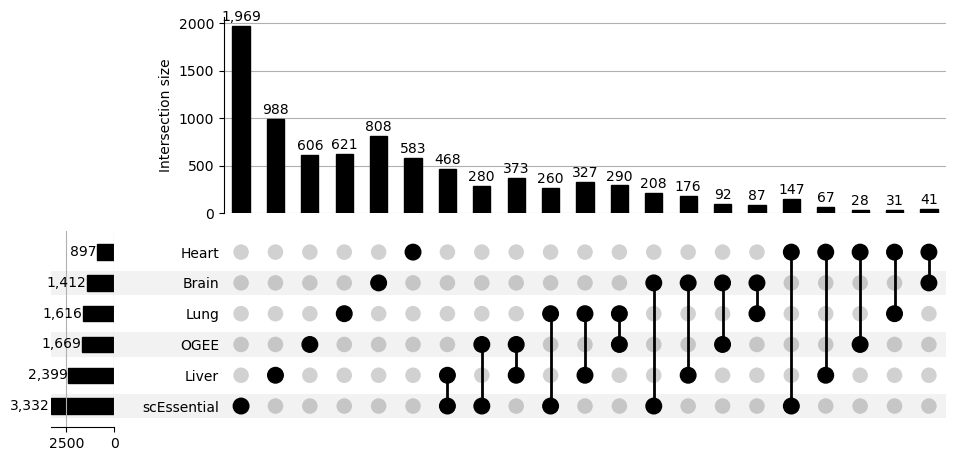

In [151]:
from upsetplot import generate_counts, plot
plot(ess_overlaps, show_counts="{:,}")
plt.show()

In [152]:
ess_combined = {
    t.capitalize(): sorted(list(set(ess[t.capitalize()] + ess['OGEE'])))
    # t: sorted(list(set(ess[t] + ess['OGEE'] + ess['scEssential'])))
    for t in tissues}

print({k:len(v) for k,v in ess.items()})
print({k:len(v) for k,v in ess_combined.items()})

{'Brain': 808, 'Heart': 583, 'Liver': 988, 'Lung': 621, 'scEssential': 1969, 'OGEE': 606}
{'Brain': 1322, 'Heart': 1161, 'Liver': 1221, 'Lung': 937}


In [153]:
ess_combined_overlaps = lists_of_genes_to_overlap_matrix(ess_combined)
ess_combined_overlaps = ess_combined_overlaps[ess_combined_overlaps > 0]
ess_combined_overlaps

Brain  Heart  Liver  Lung 
False  False  False  True      937
              True   False    1221
                     True      741
       True   False  False    1161
                     True      623
              True   False     651
True   False  False  False    1322
                     True      644
              True   False     703
       True   False  False     641
Name: value, dtype: int64

/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/efimov/miniconda3/envs/soma_mut/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

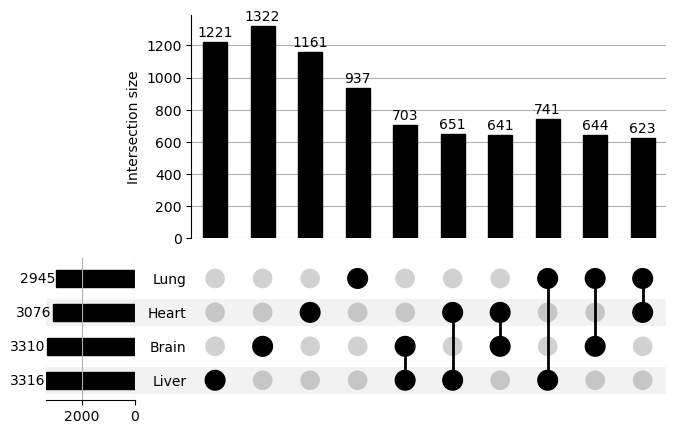

In [154]:
from upsetplot import generate_counts, plot

fig = plt.figure(figsize=(8, 5))
# plot(ess_combined_overlaps, show_counts="%d", element_size=40)
plot(ess_combined_overlaps, fig=fig, show_counts="%d", element_size=None)
plt.show()

### Annotation starts

In [30]:
mutscore_df = pd.read_csv('/tank/projects/computagehub/annotation/snvs/mutscore-v1.0-hg38.tsv.gz', sep='\t', 
                          names=['CHROM', 'POS', 'REF', 'ALT', 'MutScore'],
                          dtype={'CHROM':str, 'POS':str, 'REF':str, 'ALT':str})
mutscore_df.to_parquet('/tank/projects/computagehub/annotation/snvs/mutscore-v1.0-hg38.parquet')

In [4]:
mutscore_df = pd.read_parquet('/tank/projects/computagehub/annotation/snvs/mutscore-v1.0-hg38.parquet')
mutscore_df

,CHROM,POS,REF,ALT,MutScore
0,1,69091,A,C,0.131
1,1,69091,A,G,0.063
2,1,69091,A,T,0.131
3,1,69092,T,A,0.198
4,1,69092,T,C,0.142
...,...,...,...,...,...
71718770,17_KI270857v1_alt,489178,G,C,0.053
71718771,17_KI270857v1_alt,489178,G,T,0.047
71718772,17_KI270857v1_alt,489180,G,A,0.030
71718773,17_KI270857v1_alt,489180,G,C,0.122


In [7]:
mutscore_df_kill = mutscore_df[mutscore_df['MutScore'] > .95].copy()
mutscore_df_kill

,CHROM,POS,REF,ALT,MutScore
7534,1,943317,G,C,0.967
7535,1,943317,G,T,0.967
7631,1,943361,G,A,0.961
7844,1,943782,G,A,0.960
7845,1,943782,G,C,0.960
...,...,...,...,...,...
71697253,Y,2787320,C,A,0.982
71697255,Y,2787320,C,T,0.969
71697294,Y,2787338,T,A,0.963
71697295,Y,2787338,T,C,0.958


In [8]:
mutscore_df_kill.drop_duplicates(['CHROM', 'POS'])

,CHROM,POS,REF,ALT,MutScore
7534,1,943317,G,C,0.967
7631,1,943361,G,A,0.961
7844,1,943782,G,A,0.960
9613,1,946509,A,C,0.969
9646,1,946523,C,T,0.956
...,...,...,...,...,...
71697187,Y,2787290,T,A,0.951
71697235,Y,2787311,C,A,0.967
71697253,Y,2787320,C,A,0.982
71697294,Y,2787338,T,A,0.963


In [6]:
3767443/71718775

0.05253077733131945

#### FAVOR

In [135]:
data_favor = {t: pd.read_csv(f'{processed_dir}/data_{t.lower()}_favor.tsv.gz', sep='\t', index_col=None, dtype={}) for t in tissues}
data_favor

/tmp/ipykernel_905997/1085838383.py:1: DtypeWarning: Columns (38,50,54,58,62,66,324) have mixed types. Specify dtype option on import or set low_memory=False.
  data_favor = {t: pd.read_csv(f'{processed_dir}/data_{t.lower()}_favor.tsv.gz', sep='\t', index_col=None, dtype={}) for t in tissues}
/tmp/ipykernel_905997/1085838383.py:1: DtypeWarning: Columns (38,50,54,58,62,66,324) have mixed types. Specify dtype option on import or set low_memory=False.
  data_favor = {t: pd.read_csv(f'{processed_dir}/data_{t.lower()}_favor.tsv.gz', sep='\t', index_col=None, dtype={}) for t in tissues}
/tmp/ipykernel_905997/1085838383.py:1: DtypeWarning: Columns (38,50,54,58,62,66) have mixed types. Specify dtype option on import or set low_memory=False.
  data_favor = {t: pd.read_csv(f'{processed_dir}/data_{t.lower()}_favor.tsv.gz', sep='\t', index_col=None, dtype={}) for t in tissues}
/tmp/ipykernel_905997/1085838383.py:1: DtypeWarning: Columns (20,22,26,36,38,40,42,50,54,58,62,66,80,84,324) have mixed ty

{'Brain':       VariantVcf.String  VariantVcf.Valid  Chromosome.String  \
 0          1-917882-C-G              True                  1   
 1          1-917882-C-G              True                  1   
 2          1-983862-C-T              True                  1   
 3          1-995442-A-G              True                  1   
 4          1-995442-A-G              True                  1   
 ...                 ...               ...                ...   
 83381   22-50425306-C-T              True                 22   
 83382   22-50425306-C-T              True                 22   
 83383   22-50477706-C-T              True                 22   
 83384   22-50658460-C-T              True                 22   
 83385   22-50714586-A-G              True                 22   
 
        Chromosome.Valid  Position.String  Position.Valid  BravoAn.Int32  \
 0                  True           917882            True              0   
 1                  True           917882            True

In [15]:
data_favor['Heart']

,VariantVcf.String,VariantVcf.Valid,Chromosome.String,Chromosome.Valid,Position.String,Position.Valid,BravoAn.Int32,BravoAn.Valid,BravoAc.Int32,BravoAc.Valid,...,Nucdiv.Float64,Nucdiv.Valid,AloftValue.String,AloftValue.Valid,AloftDescription.String,AloftDescription.Valid,FunseqValue.String,FunseqValue.Valid,FunseqDescription.String,FunseqDescription.Valid
0,1-100446161-G-A,True,1,True,100446161,True,264690,True,7,True,...,2.35,True,NaN,False,NaN,False,NaN,False,noncoding,True
1,1-100486042-G-C,True,1,True,100486042,True,0,False,0,False,...,1.60,True,NaN,False,NaN,False,NaN,False,noncoding,True
2,1-100486042-G-C,True,1,True,100486042,True,0,False,0,False,...,1.60,True,NaN,False,NaN,False,NaN,False,noncoding,True
3,1-100515223-C-T,True,1,True,100515223,True,0,False,0,False,...,2.20,True,NaN,False,NaN,False,NaN,False,noncoding,True
4,1-100603983-C-T,True,1,True,100603983,True,264690,True,1,True,...,3.20,True,NaN,False,NaN,False,NaN,False,noncoding,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26358,9-99621999-C-T,True,9,True,99621999,True,0,False,0,False,...,1.90,True,NaN,False,NaN,False,NaN,False,noncoding,True
26359,9-99636680-T-G,True,9,True,99636680,True,0,False,0,False,...,2.05,True,NaN,False,NaN,False,NaN,False,noncoding,True
26360,9-99646097-C-A,True,9,True,99646097,True,0,False,0,False,...,1.70,True,NaN,False,NaN,False,NaN,False,noncoding,True
26361,9-99714963-T-G,True,9,True,99714963,True,0,False,0,False,...,1.35,True,NaN,False,NaN,False,NaN,False,noncoding,True


In [385]:
cadd_phred_thresh = 15

def classify_snvs(df_favor, ess_genes_list, dedup=False):
    df_favor_select = df_favor[favor_cols_selected].copy()
    df_favor_select.rename(columns={
        'Chromosome.String':'CHROM', 'Position.String':'POS', 'CagePromoter.Valid':'CagePromoter_Valid', 
        'CageEnhancer.Valid':'CageEnhancer_Valid', 'Genehancer.Valid':'Genehancer_Valid', 'SuperEnhancer.Valid':'SuperEnhancer_Valid'}, inplace=True)
    df_favor_select.columns = df_favor_select.columns.str.split('.', expand=True).get_level_values(0)

    df_favor_select[['CHROM', 'POS', 'REF', 'ALT']] = df_favor_select['VariantVcf'].str.split('-', expand=True)

    # Genomic region classes
    df_favor_select['CLASS'] = df_favor_select.apply(lambda x: 
        'CDS' if x['GenecodeComprehensiveCategory'] == 'exonic' else
        'NCREG' if 
            x['GenecodeComprehensiveCategory'] in ['UTR5', 'UTR3', 'splicing', 'exonic;splicing', 'upstream', 'downstream', 'upstream;downstream'] or
            x[['CagePromoter_Valid', 'CageEnhancer_Valid', 'Genehancer_Valid', 'SuperEnhancer_Valid']].any() == True 
            else
        'NCRNA' if x['GenecodeComprehensiveCategory'] in ['ncRNA_exonic', 'ncRNA_intronic'] else
        'NCOTH',
        axis=1
    )

    # Essential-relatedness
    ess_regex = r'(?i)' + '|'.join(ess_genes_list)
    df_favor_select['ESSENTIAL_RELATED'] = pd.DataFrame(np.vstack([
        df_favor_select['GenecodeComprehensiveInfo'].str.contains(ess_regex, regex=True),
        df_favor_select['GenecodeComprehensiveExonicInfo'].str.contains(ess_regex, regex=True),
        df_favor_select['RefseqInfo'].str.contains(ess_regex, regex=True),
        df_favor_select['RefseqExonicInfo'].str.contains(ess_regex, regex=True),
        df_favor_select['Genehancer'].str.contains(ess_regex, regex=True)
        ])).T.any(axis=1, skipna=True)

    # Deleteriousness
    df_favor_select['DELETERIOUS'] = df_favor_select['CaddPhred'] >= cadd_phred_thresh

    df_favor_select[['CHROM', 'POS', 'REF', 'ALT']] = df_favor_select[['CHROM', 'POS', 'REF', 'ALT']].astype(str)
    df_favor_select = df_favor_select.merge(
        mutscore_df, left_on=['CHROM', 'POS', 'REF', 'ALT'], right_on=['CHROM', 'POS', 'REF', 'ALT'], how='left')
    
    # Combining essentiality and deleteriousness
    df_favor_select['DELETERIOUS|ESSENTIAL_RELATED'] = df_favor_select[['ESSENTIAL_RELATED', 'DELETERIOUS']].prod(axis=1)

    if dedup:
        df_favor_select = df_favor_select.drop_duplicates().reset_index(drop=True)

    return df_favor_select.reset_index(drop=True)

data_favor_select = {}
for t in tissues:
    data_favor_select[t] = classify_snvs(data_favor[t], ess_genes_list=ess_combined[t], dedup=False)
    data_favor_select[t].to_csv(f'{processed_dir}/{t}_final.tsv.gz', sep='\t', index=None, compression='gzip')
    data_favor_select[t].to_parquet(f'{processed_dir}/{t}_final.parquet')

In [386]:
data_favor_select[t]

,VariantVcf,CHROM,POS,Rsid,GenecodeComprehensiveCategory,GenecodeComprehensiveInfo,UcscInfo,RefseqInfo,GenecodeComprehensiveExonicCategory,GenecodeComprehensiveExonicInfo,...,AfTotal,AfFemale,AfMale,REF,ALT,CLASS,ESSENTIAL_RELATED,DELETERIOUS,MutScore,DELETERIOUS|ESSENTIAL_RELATED
0,9-380030-TGCAGGGGCTCACATCTGCAACCCCAGCACTCTAGGA...,9,380030,rs1563986691,intronic,DOCK8,ENST00000495184.5,NaN,NaN,NaN,...,0.000874,0.000909,0.000837,TGCAGGGGCTCACATCTGCAACCCCAGCACTCTAGGAGGCTGAGAT...,T,NCOTH,False,False,NaN,0
1,9-6872948-CAG-C,9,6872948,rs1197292911,intronic,KDM4C,ENST00000489243.5,NaN,NaN,NaN,...,0.000007,0.000000,0.000014,CAG,C,NCOTH,False,False,NaN,0
2,9-26473230-G-GA,9,26473230,NaN,intergenic,"AL353753.1(dist=354822),AL442639.1(dist=169467)","ENST00000612217.2(dist=354822),ENST00000625030...",NaN,NaN,NaN,...,0.000077,0.000081,0.000072,G,GA,NCOTH,False,False,NaN,0
3,9-29008377-C-CA,9,29008377,rs1161914669,intergenic,"MIR873(dist=119422),AL162388.2(dist=205945)","ENST00000401120.3(dist=119422),ENST00000450912...",NaN,NaN,NaN,...,0.000014,0.000014,0.000014,C,CA,NCOTH,False,False,NaN,0
4,9-41027128-GAC-G,9,41027128,rs1175999708,intergenic,"AL353763.2(dist=12996),AL353763.1(dist=34160)","ENST00000611606.4,ENST00000613141.1,ENST000006...",NaN,NaN,NaN,...,0.000400,0.000327,0.000479,GAC,G,NCOTH,False,False,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20514,9-99603961-T-C,9,99603961,rs1034579178,ncRNA_intronic,"AL359710.1,STX17-AS1",ENST00000427039.1,NaN,NaN,NaN,...,0.000042,0.000041,0.000043,T,C,NCRNA,False,False,NaN,0
20515,9-99624297-G-A,9,99624297,NaN,ncRNA_intronic,"AL359710.1,STX17-AS1",ENST00000427039.1,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,G,A,NCRNA,False,False,NaN,0
20516,9-99629859-G-T,9,99629859,NaN,ncRNA_intronic,"AL359710.1,STX17-AS1",ENST00000427039.1,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,G,T,NCRNA,False,False,NaN,0
20517,9-9978332-G-C,9,9978332,rs1246037006,intronic,PTPRD,"ENST00000381196.8,ENST00000463477.5",NaN,NaN,NaN,...,0.000014,0.000027,0.000000,G,C,NCOTH,False,False,NaN,0


In [399]:
data_favor_select = {}
for t in tissues:
    data_favor_select[t] = pd.read_parquet(f'{processed_dir}/{t}_final.parquet')

In [400]:
data_favor_select['Liver'].columns

Index(['VariantVcf', 'CHROM', 'POS', 'Rsid', 'GenecodeComprehensiveCategory',
       'GenecodeComprehensiveInfo', 'UcscInfo', 'RefseqInfo',
       'GenecodeComprehensiveExonicCategory',
       'GenecodeComprehensiveExonicInfo', 'UcscExonicInfo', 'RefseqExonicInfo',
       'CagePromoter', 'CagePromoter_Valid', 'CageEnhancer',
       'CageEnhancer_Valid', 'Genehancer', 'Genehancer_Valid', 'SuperEnhancer',
       'SuperEnhancer_Valid', 'CaddPhred', 'CaddRawscore', 'Linsight',
       'FathmmXf', 'AloftValue', 'AloftDescription', 'FunseqValue',
       'FunseqDescription', 'Origin', 'Gc', 'Cpg', 'MinDistTss', 'MinDistTse',
       'ApcProteinFunctionV3', 'ApcConservationV2', 'ApcEpigeneticsActive',
       'ApcEpigeneticsRepressed', 'ApcEpigeneticsTranscription',
       'ApcTranscriptionFactor', 'ApcLocalNucleotideDiversityV3',
       'ApcMappability', 'ApcMutationDensity', 'EncodeDnaseSum',
       'EncodetotalRnaSum', 'TgAll', 'AfTotal', 'AfFemale', 'AfMale', 'REF',
       'ALT', 'CLASS', 'ES

<Axes: ylabel='Frequency'>

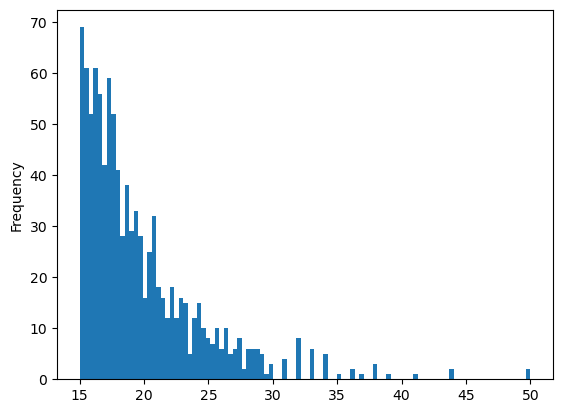

In [195]:
data_favor_select['Liver'][data_favor_select['Liver']['CaddPhred'] >= 15]['CaddPhred'].plot.hist(bins=100)
# data_favor_select['Liver']['CaddPhred'].plot.hist(bins=1000)

In [236]:
df_top = data_favor_select['Liver'][data_favor_select['Liver']['CaddPhred'] >= 15].copy()
df_top

,VariantVcf,CHROM,POS,Rsid,GenecodeComprehensiveCategory,GenecodeComprehensiveInfo,UcscInfo,RefseqInfo,GenecodeComprehensiveExonicCategory,GenecodeComprehensiveExonicInfo,...,AfTotal,AfFemale,AfMale,REF,ALT,CLASS,ESSENTIAL_RELATED,DELETERIOUS,MutScore,DELETERIOUS|ESSENTIAL_RELATED
91,1-107123471-T-A,1,107123471,None,intergenic,"PRMT6(dist=55835),NTNG1(dist=16536)","ENST00000650338.1(dist=55835),ENST00000370071....","PRMT6(dist=64177),NTNG1(dist=16617)",None,None,...,0.0,0.0,0.0,T,A,NCOTH,False,True,NaN,0
96,1-10746401-T-A,1,10746401,None,intronic,CASZ1,"ENST00000344008.5,ENST00000377022.7",CASZ1,None,None,...,0.0,0.0,0.0,T,A,NCREG,False,True,NaN,0
137,1-110351154-T-G,1,110351154,None,ncRNA_intronic,LAMTOR5-AS1,ENST00000626572.2,"RBM15(dist=4473),SLC16A4(dist=11697)",None,None,...,0.0,0.0,0.0,T,G,NCREG,True,True,NaN,1
139,1-110492991-G-A,1,110492991,None,intergenic,"CYMP-AS1(dist=2733),KCNA10(dist=24226)","ENST00000474680.5(dist=1714),ENST00000369771.4...","CYMP(dist=1722),KCNA10(dist=24226)",None,None,...,0.0,0.0,0.0,G,A,NCOTH,False,True,NaN,0
149,1-111184300-A-T,1,111184300,None,exonic,CEPT1,"ENST00000357172.8,ENST00000545121.5",CEPT1,nonsynonymous SNV,CEPT1:ENST00000545121.5:exon9:c.A1241T:p.N414I...,...,0.0,0.0,0.0,A,T,CDS,False,True,0.338,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32405,9-86287720-A-T,9,86287720,None,downstream,TUT7,"ENST00000277141.10,ENST00000375957.5,ENST00000...",None,None,None,...,0.0,0.0,0.0,A,T,NCREG,False,True,NaN,0
32408,9-86396995-C-G,9,86396995,None,intergenic,"TUT7(dist=42541),AL158828.1(dist=17206)","ENST00000422735.1(dist=21289),ENST00000438582....",None,None,None,...,0.0,0.0,0.0,C,G,NCOTH,False,True,NaN,0
32415,9-87229259-G-A,9,87229259,None,intergenic,"C9orf170(dist=69703),RF00568(dist=31191)","ENST00000623052.1(dist=69703),ENST00000391119....",None,None,None,...,0.0,0.0,0.0,G,A,NCOTH,False,True,NaN,0
32509,9-93471324-C-A,9,93471324,None,exonic,FAM120A,"ENST00000277165.10,ENST00000375389.7,ENST00000...",None,nonsynonymous SNV,FAM120A:ENST00000375389.7:exon2:c.C658A:p.H220...,...,0.0,0.0,0.0,C,A,CDS,False,True,0.256,0


(996, 55)
3.9553208571866714 0.00012132141761814217
173.1598762582514
346.3197525165028


<Axes: ylabel='Frequency'>

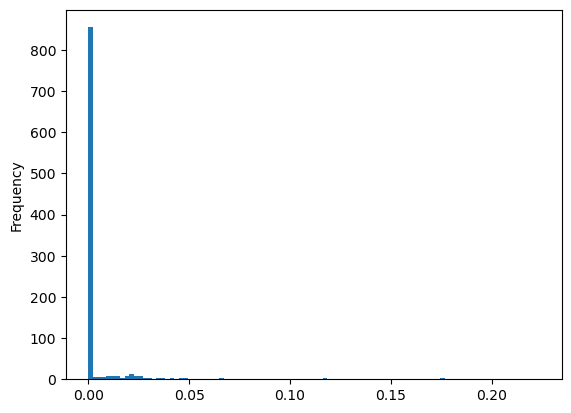

In [388]:
df_top = data_favor_select['Liver'].copy()
df_top = data_favor_select['Liver'][data_favor_select['Liver']['CaddPhred'] >= 15].copy()
print(df_top.shape)

class_weights = {'CDS':1, 'NCREG':0.75, 'NCRNA':0.5, 'NCOTH':0.25}
# class_weights = {'CDS':1, 'NCREG':0.5, 'NCRNA':0.25, 'NCOTH':0.1}
df_top['FINAL_SCORE'] = ( \
    df_top['ESSENTIAL_RELATED'].apply(lambda x: 1 if x else 0) * \
    df_top['CLASS'].apply(lambda x: class_weights[x]) * \
    df_top[['CLASS', 'MutScore', 'AloftValue']].apply(lambda x: np.mean(x[['MutScore', 'AloftValue']]) if x['CLASS']=='CDS' else 1, axis=1) * \
    df_top[['CLASS', 'Linsight']].apply(lambda x: x['Linsight']/100 if x['CLASS']!='CDS' else 1, axis=1) * \
    (df_top[['CaddPhred', 'FathmmXf']]/100).mean(axis=1)
    )

N_lethal = df_top['FINAL_SCORE'].sum()
p_lethal = N_lethal / data_favor_select['Liver'].shape[0]

print(N_lethal, p_lethal)
print(-(np.log(0.33)) / (p_lethal * 52.773350))
print(-(np.log(0.33)) / (p_lethal/2 * 52.773350))

df_top['FINAL_SCORE'].plot.hist(bins=100)

In [378]:
print(-(np.log(0.5)) / (p_lethal/2 * 16))

714.1640715302412


In [386]:
x0 = 86e9
mu = (p_lethal/2 * 16)
t = 100

(x0 * np.exp(-mu*t)) / x0 * 100

np.float64(90.75041552238832)

In [381]:
68e6/86e9

0.0007906976744186047

<Axes: xlabel='Linsight', ylabel='FathmmXf'>

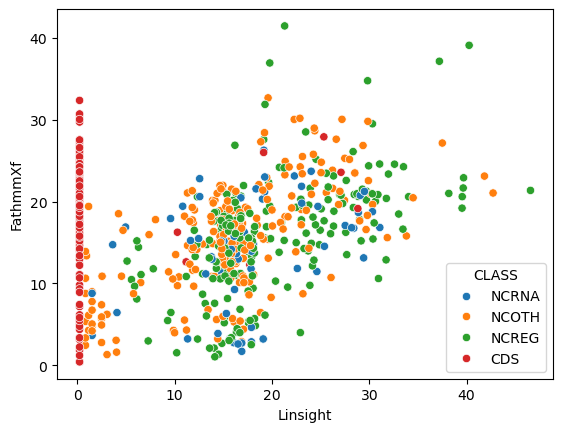

In [184]:
sns.scatterplot(df_top, x='Linsight', y='FathmmXf', hue='CLASS')

<Axes: xlabel='CaddPhred', ylabel='MutScore'>

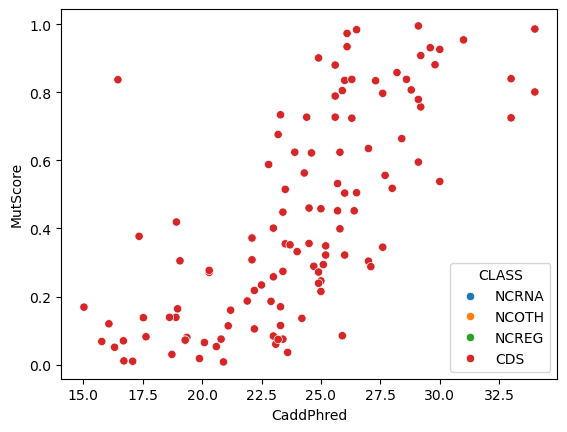

In [185]:
sns.scatterplot(df_top, x='CaddPhred', y='MutScore', hue='CLASS')

<Axes: xlabel='CaddPhred', ylabel='ApcProteinFunctionV3'>

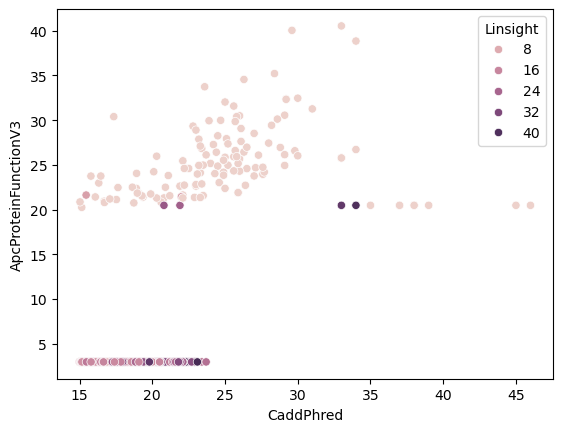

In [168]:
sns.scatterplot(df_top, x='CaddPhred', y='ApcProteinFunctionV3', hue='Linsight')

<Axes: ylabel='Frequency'>

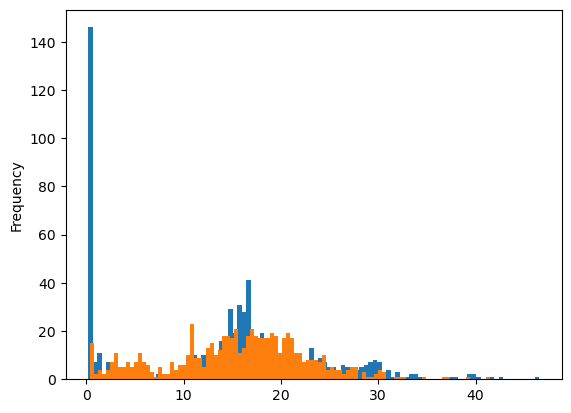

In [153]:
# data_favor_select['Heart'][data_favor_select['Heart']['CaddPhred'] >= 15]['MutScore'].plot.hist(bins=100)
data_favor_select['Heart'][data_favor_select['Heart']['CaddPhred'] >= 15]['Linsight'].plot.hist(bins=100)
data_favor_select['Heart'][data_favor_select['Heart']['CaddPhred'] >= 15]['FathmmXf'].plot.hist(bins=100)

In [387]:
# data_neurons_favor_select = data_neurons_favor_select.drop_duplicates().reset_index(drop=True)
# data_heart_favor_select = data_heart_favor_select.drop_duplicates().reset_index(drop=True)

#### VEP

In [411]:
vep_cols = [
    'CHROM', 'POS', 'REF', 'ALT',
    'Location', 'UPLOADED_ALLELE',
    'Consequence', 'IMPACT', 
    'SYMBOL', 'Gene', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON',
    'HGVSc', 'HGVSp',
    'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons',
    'Existing_variation',
    'DISTANCE', 'STRAND',
    'SYMBOL_SOURCE', 'HGNC_ID', 'CANONICAL', 'TSL', 'APPRIS',
    'CCDS',
    'ENSP',
    'SWISSPROT', 'TREMBL', 'UNIPARC', 'UNIPROT_ISOFORM',
    'SIFT', 'PolyPhen',
    'DOMAINS',
    'miRNA',
    'HGVS_OFFSET',
    'CLIN_SIG',
    'SOMATIC',
    'PHENO',
    'MOTIF_NAME',
    'MOTIF_POS',
    'HIGH_INF_POS',
    'MOTIF_SCORE_CHANGE',
    'TRANSCRIPTION_FACTORS',
    'LOEUF',
    'am_class', 'am_pathogenicity',
    'Geno2MP_HPO_count',
    'Geno2MP_URL',
    'CADD_PHRED', 'CADD_RAW',
    'GO',
    'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 
    'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', 'SpliceAI_pred_SYMBOL',
    'REVEL',
    'Mastermind_MMID3',
    'PHENOTYPES',
    '5UTR_annotation', '5UTR_consequence',
    'Existing_InFrame_oORFs',
    'Existing_OutOfFrame_oORFs',
    'Existing_uORFs',
    'pHaplo', 'pTriplo',
    'EVE_CLASS', 'EVE_SCORE',
    'ClinPred',
    'Enformer_SAD', 'Enformer_SAR',
    'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref',
    'ada_score',
    'rf_score',
    'Aloft_Confidence', 'Aloft_Fraction_transcripts_affected', 'Aloft_pred', 'Aloft_prob_Dominant', 'Aloft_prob_Recessive', 'Aloft_prob_Tolerant',
    'AlphaMissense_pred', 'AlphaMissense_rankscore', 'AlphaMissense_score',
    'BayesDel_addAF_pred', 'BayesDel_addAF_rankscore', 'BayesDel_addAF_score',
    'DANN_rankscore', 'DANN_score',
    'DEOGEN2_pred', 'DEOGEN2_rankscore', 'DEOGEN2_score',
    'ESM1b_pred', 'ESM1b_rankscore', 'ESM1b_score',
    'Eigen-PC-phred_coding', 'Eigen-PC-raw_coding', 'Eigen-PC-raw_coding_rankscore', 'Eigen-phred_coding', 'Eigen-raw_coding', 'Eigen-raw_coding_rankscore',
    'Ensembl_geneid', 'Ensembl_proteinid', 'Ensembl_transcriptid', 'Interpro_domain',
    'LIST-S2_pred', 'LIST-S2_rankscore', 'LIST-S2_score',
    'MPC_rankscore', 'MPC_score', 'MVP_rankscore', 'MVP_score',
    'MetaLR_pred', 'MetaLR_rankscore', 'MetaLR_score',
    'MetaRNN_pred', 'MetaRNN_rankscore', 'MetaRNN_score', 'MetaSVM_pred', 'MetaSVM_rankscore', 'MetaSVM_score',
    'MutFormer_rankscore', 'MutFormer_score',
    'MutationAssessor_pred', 'MutationAssessor_rankscore', 'MutationAssessor_score',
    'MutationTaster_converted_rankscore', 'MutationTaster_model', 'MutationTaster_pred', 'MutationTaster_score', 'MutationTaster_trees_benign', 'MutationTaster_trees_deleterious',
    'PROVEAN_converted_rankscore', 'PROVEAN_pred', 'PROVEAN_score',
    'PrimateAI_pred', 'PrimateAI_rankscore', 'PrimateAI_score',
    'Reliability_index',
    'Uniprot_acc',
    'Uniprot_entry',
    'fathmm-XF_coding_pred', 'fathmm-XF_coding_rankscore', 'fathmm-XF_coding_score',
    'gMVP_rankscore', 'gMVP_score',
    'genename',
    'AF', 'gnomADe_AF', 'gnomADg_AF',
    'AllOfUs', 'AllOfUs_gvs_all_af', 'AllOfUs_gvs_max_af']

In [435]:
data_luquette_vep = pd.read_csv(f'{processed_dir}/vep/2022luquette_hg38_vep.txt', sep='\t')
data_luquette_vep

/tmp/ipykernel_905997/702523891.py:1: DtypeWarning: Columns (218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  data_luquette_vep = pd.read_csv(f'{processed_dir}/vep/2022luquette_hg38_vep.txt', sep='\t')


,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,AllOfUs,AllOfUs_gvs_all_af,AllOfUs_gvs_max_af,AllOfUs_gvs_afr_af,AllOfUs_gvs_amr_af,AllOfUs_gvs_eas_af,AllOfUs_gvs_eur_af,AllOfUs_gvs_mid_af,AllOfUs_gvs_oth_af,AllOfUs_gvs_sas_af
0,.,1:150267807-150267807,T,intron_variant,MODIFIER,APH1A,ENSG00000117362,Transcript,ENST00000360244.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
1,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369098.3,protein_coding,...,-,-,-,-,-,-,-,-,-,-
2,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369099.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
3,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369102.5,protein_coding,...,-,-,-,-,-,-,-,-,-,-
4,.,1:150267807-150267807,T,intron_variant,MODIFIER,APH1A,ENSG00000117362,Transcript,ENST00000369109.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40225,.,9:137609811-137609811,G,intron_variant,MODIFIER,ARRDC1,ENSG00000197070,Transcript,ENST00000371421.9,protein_coding,...,-,-,-,-,-,-,-,-,-,-
40226,.,9:137644129-137644129,T,upstream_gene_variant,MODIFIER,SETP5,ENSG00000233998,Transcript,ENST00000437270.1,processed_pseudogene,...,-,-,-,-,-,-,-,-,-,-
40227,.,9:137644129-137644129,T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,Transcript,ENST00000460843.6,protein_coding,...,-,-,-,-,-,-,-,-,-,-
40228,.,9:137655214-137655214,T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,Transcript,ENST00000460843.6,protein_coding,...,-,-,-,-,-,-,-,-,-,-


In [436]:
data_luquette_vep[data_luquette_vep.duplicated(keep=False)]

,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,AllOfUs,AllOfUs_gvs_all_af,AllOfUs_gvs_max_af,AllOfUs_gvs_afr_af,AllOfUs_gvs_amr_af,AllOfUs_gvs_eas_af,AllOfUs_gvs_eur_af,AllOfUs_gvs_mid_af,AllOfUs_gvs_oth_af,AllOfUs_gvs_sas_af
0,.,1:150267807-150267807,T,intron_variant,MODIFIER,APH1A,ENSG00000117362,Transcript,ENST00000360244.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
1,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369098.3,protein_coding,...,-,-,-,-,-,-,-,-,-,-
2,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369099.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
3,.,1:150267807-150267807,T,upstream_gene_variant,MODIFIER,C1orf54,ENSG00000118292,Transcript,ENST00000369102.5,protein_coding,...,-,-,-,-,-,-,-,-,-,-
4,.,1:150267807-150267807,T,intron_variant,MODIFIER,APH1A,ENSG00000117362,Transcript,ENST00000369109.8,protein_coding,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34537,.,7:1880090-1880090,C,intron_variant,MODIFIER,MAD1L1,ENSG00000002822,Transcript,ENST00000402746.5,protein_coding,...,-,-,-,-,-,-,-,-,-,-
34538,.,7:1880090-1880090,C,intron_variant,MODIFIER,MAD1L1,ENSG00000002822,Transcript,ENST00000265854.12,protein_coding,...,-,-,-,-,-,-,-,-,-,-
34539,.,7:1880090-1880090,C,intron_variant,MODIFIER,MAD1L1,ENSG00000002822,Transcript,ENST00000402746.5,protein_coding,...,-,-,-,-,-,-,-,-,-,-
35380,.,7:65819966-65819966,A,intergenic_variant,MODIFIER,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [414]:
df_vep = data_luquette_vep.copy()

df_vep = df_vep.drop_duplicates(['Location', 'Allele', 'REF_ALLELE']).replace('-',np.nan)

df_vep[['CHROM', 'POS']] = df_vep['Location'].str.split(':', expand=True)
df_vep['POS'] = df_vep['POS'].str.split('-', expand=True)[0]
df_vep = df_vep.rename(columns={'Allele':'ALT', 'REF_ALLELE':'REF'})
df_vep = df_vep[vep_cols].copy()

df_vep = df_vep.merge(data_favor_select['Brain'], how='left', left_on=['CHROM', 'POS', 'REF', 'ALT'], right_on=['CHROM', 'POS', 'REF', 'ALT'])
df_vep

,CHROM,POS,REF,ALT,Location,UPLOADED_ALLELE,Consequence,IMPACT,SYMBOL,Gene,...,EncodetotalRnaSum,TgAll,AfTotal,AfFemale,AfMale,CLASS,ESSENTIAL_RELATED,DELETERIOUS,MutScore,DELETERIOUS|ESSENTIAL_RELATED
0,1,150267807,A,T,1:150267807-150267807,A/T,intron_variant,MODIFIER,APH1A,ENSG00000117362,...,0.27,0.0,0.000705,0.000590,0.000829,NCREG,True,True,NaN,1.0
1,1,150267807,A,T,1:150267807-150267807,A/T,intron_variant,MODIFIER,APH1A,ENSG00000117362,...,0.27,0.0,0.000705,0.000590,0.000829,NCREG,True,True,NaN,1.0
2,2,80656696,G,A,2:80656696-80656696,G/A,intergenic_variant,MODIFIER,NaN,NaN,...,0.01,0.0,0.000834,0.000829,0.000839,NCOTH,False,False,NaN,0.0
3,2,80656696,G,A,2:80656696-80656696,G/A,intergenic_variant,MODIFIER,NaN,NaN,...,0.01,0.0,0.000834,0.000829,0.000839,NCOTH,False,False,NaN,0.0
4,2,117039246,G,A,2:117039246-117039246,G/A,intergenic_variant,MODIFIER,NaN,NaN,...,0.00,0.0,0.000000,0.000000,0.000000,NCOTH,False,False,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38833,9,137644129,C,T,9:137644129-137644129,C/T,upstream_gene_variant,MODIFIER,SETP5,ENSG00000233998,...,0.31,0.0,0.000000,0.000000,0.000000,NCRNA,False,False,NaN,0.0
38834,9,137655214,C,T,9:137655214-137655214,C/T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,...,0.18,0.0,0.000000,0.000000,0.000000,NCRNA,False,False,NaN,0.0
38835,9,137655214,C,T,9:137655214-137655214,C/T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,...,0.18,0.0,0.000000,0.000000,0.000000,NCRNA,False,False,NaN,0.0
38836,9,137754950,G,T,9:137754950-137754950,G/T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,...,0.19,0.0,0.000000,0.000000,0.000000,NCREG,False,False,NaN,0.0


In [ ]:

# Genomic region classes
df_vep['CLASS'] = df_vep.apply(lambda x: 
    'CDS' if x['Consequence'] in [
        'missense_variant', 'synonymous_variant', 'start_lost', 'stop_gained', 'stop_retained_variant',
        'missense_variant,splice_region_variant'] else
    'NCREG' if 
        x['Consequence'] in [
            '5_prime_UTR_variant', '3_prime_UTR_variant', 'upstream_gene_variant', 'downstream_gene_variant',
            'splice_donor_variant', 'splice_polypyrimidine_tract_variant,intron_variant',
            'regulatory_region_variant', 'non_coding_transcript_exon_variant',
            'splice_donor_region_variant,intron_variant', 'splice_region_variant,synonymous_variant',
            'splice_region_variant,splice_polypyrimidine_tract_variant,intron_variant', 'splice_acceptor_variant', 'splice_region_variant,intron_variant',
            'splice_donor_variant,non_coding_transcript_variant', 'splice_polypyrimidine_tract_variant,intron_variant,non_coding_transcript_variant', 
            'splice_region_variant,non_coding_transcript_exon_variant', 'splice_region_variant,splice_polypyrimidine_tract_variant,intron_variant,non_coding_transcript_variant'
            'splice_donor_5th_base_variant,intron_variant', 'splice_donor_region_variant,intron_variant,non_coding_transcript_variant']
        # or x[['CagePromoter_Valid', 'CageEnhancer_Valid', 'Genehancer_Valid', 'SuperEnhancer_Valid']].any() == True 
        else
    # 'NCRNA' if x['GenecodeComprehensiveCategory'] in ['ncRNA_exonic', 'ncRNA_intronic'] else
    'NCOTH',
    axis=1
)

# Essential-relatedness
ess_regex = r'(?i)' + '|'.join(ess_combined['Brain'])
df_vep['ESSENTIAL_RELATED'] = \
    df_vep['SYMBOL'].str.contains(ess_regex, regex=True)
    # pd.DataFrame(np.vstack([
    # df_vep['SYMBOL'].str.contains(ess_regex, regex=True),
    # df_vep['GenecodeComprehensiveExonicInfo'].str.contains(ess_regex, regex=True),
    # df_vep['RefseqInfo'].str.contains(ess_regex, regex=True),
    # df_vep['RefseqExonicInfo'].str.contains(ess_regex, regex=True),
    # df_vep['Genehancer'].str.contains(ess_regex, regex=True)
    # ])).T.any(axis=1, skipna=True)

df_vep

,Location,Allele,REF_ALLELE,UPLOADED_ALLELE,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,...,gMVP_rankscore,gMVP_score,genename,AllOfUs,AllOfUs_gvs_all_af,AllOfUs_gvs_max_af,CHROM,POS,CLASS,ESSENTIAL_RELATED
0,1:150267807-150267807,T,A,A/T,intron_variant,MODIFIER,APH1A,ENSG00000117362,Transcript,ENST00000360244.8,...,NaN,NaN,NaN,NaN,NaN,NaN,1,150267807,NCOTH,False
16,2:80656696-80656696,A,G,G/A,intergenic_variant,MODIFIER,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,chr2:80656696-80656696,0.000687,0.001613,2,80656696,NCOTH,NaN
17,2:117039246-117039246,A,G,G/A,intergenic_variant,MODIFIER,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,chr2:117039246-117039246,2e-06,3.3e-05,2,117039246,NCOTH,NaN
18,2:117095638-117095638,G,C,C/G,downstream_gene_variant,MODIFIER,NaN,ENSG00000310388,Transcript,ENST00000849499.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,117095638,NCREG,NaN
19,2:117095643-117095643,C,G,G/C,downstream_gene_variant,MODIFIER,NaN,ENSG00000310388,Transcript,ENST00000849499.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,117095643,NCREG,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40224,9:137596963-137596963,A,G,G/A,intergenic_variant,MODIFIER,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9,137596963,NCOTH,NaN
40225,9:137609811-137609811,G,C,C/G,intron_variant,MODIFIER,ARRDC1,ENSG00000197070,Transcript,ENST00000371421.9,...,NaN,NaN,NaN,NaN,NaN,NaN,9,137609811,NCOTH,False
40226,9:137644129-137644129,T,C,C/T,upstream_gene_variant,MODIFIER,SETP5,ENSG00000233998,Transcript,ENST00000437270.1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,137644129,NCREG,False
40228,9:137655214-137655214,T,C,C/T,intron_variant,MODIFIER,EHMT1,ENSG00000181090,Transcript,ENST00000460843.6,...,NaN,NaN,NaN,NaN,NaN,NaN,9,137655214,NCOTH,False


In [ ]:
df_vep['Consequence'].value_counts()

Consequence
intron_variant                                                                                            8258
intergenic_variant                                                                                        4115
intron_variant,non_coding_transcript_variant                                                              4048
downstream_gene_variant                                                                                   1417
upstream_gene_variant                                                                                     1259
3_prime_UTR_variant                                                                                        203
missense_variant                                                                                           180
regulatory_region_variant                                                                                  147
non_coding_transcript_exon_variant                                                                  

In [ ]:
df_vep[df_vep['Consequence'].isin(['stop_gained', 'start_lost'])]

,Location,Allele,REF_ALLELE,UPLOADED_ALLELE,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,...,gMVP_rankscore,gMVP_score,genename,AllOfUs,AllOfUs_gvs_all_af,AllOfUs_gvs_max_af,CHROM,POS,CLASS,ESSENTIAL_RELATED
381,7:141919416-141919416,T,C,C/T,stop_gained,HIGH,OR9A4,ENSG00000258083,Transcript,ENST00000641559.1,...,NaN,NaN,OR9A4,chr7:141919416-141919416,1.4e-05,0.000215,7,141919416,CDS,False
8818,12:6538104-6538104,G,T,T/G,stop_gained,HIGH,GAPDH,ENSG00000111640,Transcript,ENST00000229239.10,...,NaN,NaN,GAPDH,NaN,NaN,NaN,12,6538104,CDS,False
10349,12:110503835-110503835,T,C,C/T,stop_gained,HIGH,RAD9B,ENSG00000151164,Transcript,ENST00000409300.6,...,NaN,NaN,RAD9B,chr12:110503835-110503835,1.2e-05,1.9e-05,12,110503835,CDS,False
25751,3:86978529-86978529,A,G,G/A,stop_gained,HIGH,VGLL3,ENSG00000206538,Transcript,ENST00000398399.7,...,NaN,NaN,VGLL3,NaN,NaN,NaN,3,86978529,CDS,False
26287,3:132446520-132446520,A,T,T/A,stop_gained,HIGH,DNAJC13,ENSG00000138246,Transcript,ENST00000260818.11,...,NaN,NaN,DNAJC13,NaN,NaN,NaN,3,132446520,CDS,False
31788,5:148394777-148394777,G,A,A/G,start_lost,HIGH,FBXO38,ENSG00000145868,Transcript,ENST00000296701.10,...,0.56723,NaN,FBXO38,NaN,NaN,NaN,5,148394777,CDS,False


In [ ]:
df_vep['CLASS'].value_counts()

CLASS
NCOTH    16423
NCREG     3226
CDS        261
Name: count, dtype: int64

In [ ]:
df_vep['ESSENTIAL_RELATED'].value_counts()

ESSENTIAL_RELATED
False    10896
True      1342
Name: count, dtype: int64

In [ ]:
df_vep['DELETERIOUS'] = df_vep['CADD_PHRED'].replace('-', np.nan).astype(float) >= 15
df_vep['DELETERIOUS'].value_counts()

DELETERIOUS
False    19225
True       685
Name: count, dtype: int64

In [ ]:
df_vep['DELETERIOUS_ESS'] = df_vep[['ESSENTIAL_RELATED', 'DELETERIOUS']].prod(axis=1)
df_vep['DELETERIOUS_ESS'].value_counts()

DELETERIOUS_ESS
0    19676
1      234
Name: count, dtype: int64

In [ ]:
N_lethal = df_vep['DELETERIOUS_ESS'].value_counts()[1]
p_lethal = N_lethal / df_vep.shape[0]
print(N_lethal, p_lethal)

234 0.011752887995981919


In [ ]:
data_ganz_vep.replace('-',np.nan).groupby(['Location', 'Allele', 'REF_ALLELE'], as_index=False).mean(numeric_only=True)

,Location,Allele,REF_ALLELE
0,10:101397668-101397668,C,T
1,10:10220594-10220594,A,G
2,10:102974550-102974550,G,A
3,10:105214748-105214748,C,A
4,10:105214749-105214749,T,C
...,...,...,...
2150,9:95968098-95968098,G,A
2151,9:98072102-98072102,A,C
2152,9:98336432-98336432,T,G
2153,9:98644659-98644659,C,T


<Axes: ylabel='Frequency'>

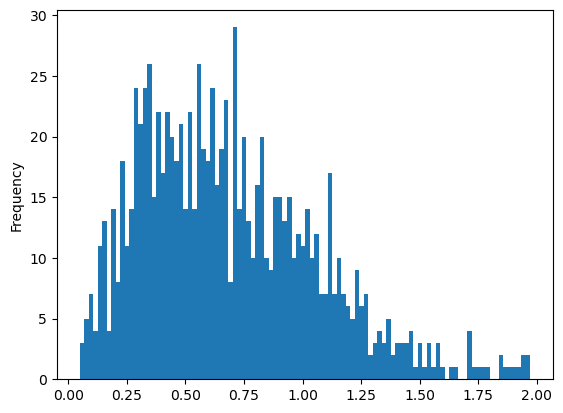

In [ ]:
data_ganz_vep.drop_duplicates(['Location', 'Allele', 'REF_ALLELE'])['LOEUF'].replace('-',np.nan).astype(float).plot.hist(bins=100)

# FINAL STATS

In [222]:
df_summary = pd.DataFrame(
    index=[
        'TOTAL',
        'CDS', 'NCREG', 'NCRNA', 'NCOTH', 
        'CDS_ratio', 'NCREG_ratio', 'NCRNA_ratio', 'NCOTH_ratio', 
        'ESSENTIAL', 'NON_ESSENTIAL', 
        'ESSENTIAL_ratio', 'NON_ESSENTIAL_ratio', 
        'DELETERIOUS', 'DELETERIOUS_ratio', 
        'DELETERIOUS_ESSENTIAL', 'DELETERIOUS_ESSENTIAL_ratio'
        ],
    columns=tissues,
)

df_summary.loc['TOTAL'] = [data_favor_select[t].shape[0] for t in tissues] #data_neurons_favor_select.shape[0], data_heart_favor_select.shape[0]

df_summary.loc[['CDS', 'NCREG', 'NCRNA', 'NCOTH'], tissues] = pd.concat(
    [data_favor_select[t]['CLASS'].value_counts(sort=False) for t in tissues], 
    keys=tissues, axis=1).reindex(labels=['CDS', 'NCREG', 'NCRNA', 'NCOTH'])

df_summary.loc[['CDS_ratio', 'NCREG_ratio', 'NCRNA_ratio', 'NCOTH_ratio'], tissues] = pd.concat(
    [data_favor_select[t]['CLASS'].value_counts(sort=False, normalize=True) for t in tissues], 
    keys=tissues, axis=1).reindex(labels=['CDS', 'NCREG', 'NCRNA', 'NCOTH']).values

df_summary.loc[['ESSENTIAL', 'NON_ESSENTIAL', 'ESSENTIAL_ratio', 'NON_ESSENTIAL_ratio'], tissues] = np.vstack([
    pd.concat([data_favor_select[t]['ESSENTIAL_RELATED'].value_counts(sort=False) for t in tissues], keys=tissues, axis=1).values,
    pd.concat([data_favor_select[t]['ESSENTIAL_RELATED'].value_counts(sort=False, normalize=True) for t in tissues], keys=tissues, axis=1).values])

df_summary.loc[['DELETERIOUS', 'DELETERIOUS_ratio'], tissues] = np.vstack([
    [data_favor_select[t]['DELETERIOUS'].value_counts(sort=False)[True] for t in tissues],
    [data_favor_select[t]['DELETERIOUS'].value_counts(sort=False, normalize=True)[True] for t in tissues]])

df_summary.loc[['DELETERIOUS_ESSENTIAL', 'DELETERIOUS_ESSENTIAL_ratio'], tissues] = np.vstack([
    [data_favor_select[t]['DELETERIOUS|ESSENTIAL_RELATED'].value_counts(sort=False)[1] for t in tissues],
    [data_favor_select[t]['DELETERIOUS|ESSENTIAL_RELATED'].value_counts(sort=False, normalize=True)[1] for t in tissues]])

df_summary

,Brain,Heart,Liver,Lung
TOTAL,83386,26363,32602,20519
CDS,1158,253,364,260
NCREG,20775,5908,8387,5690
NCRNA,11768,4112,4859,2865
NCOTH,49685,16090,18992,11704
CDS_ratio,0.013887,0.009597,0.011165,0.012671
NCREG_ratio,0.249143,0.224102,0.257254,0.277304
NCRNA_ratio,0.141127,0.155976,0.14904,0.139627
NCOTH_ratio,0.595843,0.610325,0.582541,0.570398
ESSENTIAL,10214.0,2330.0,2782.0,1614.0


In [374]:
-(np.log(0.5))/(0.00674*15)


np.float64(924.1962407465937)

In [389]:
data_favor_select[t]['MutScore'].notna().value_counts()

MutScore
False    20348
True       171
Name: count, dtype: int64